#  IE360 PROJECT REPORT
### Utku Boyar - Beyza Ünsal - Gözde Aygün

# 1-Introduction

Time series forecasting is used to make predictions by building a model with the statistic we have. There are various time series forecasting models that can be used and the decision of the model that is going to be used depends on model performance. However, to be able to make better predictions, some steps should be followed and the results of each step should be analyzed. Time series forecasting has a large scope of usage. Not only for business decisions but also for social life related decisions, time series forecasting has been used. As mentioned, one of the most popular areas of the time series is the business related decisions. Independent of the sector, there is always something to predict such as T-shirt sales for next summer or bread consumption for the next week.<br> 
	In this project we are expected to predict the production of the solar energy santral KIVANÇ II GES. It is an energy santral located at the Mersin’s province Gülnar. It is known to be the 6th biggest solar energy santral in Turkey. Due to the big production capacity of the santral, KIVANÇ II GES  is an important energy supplier.<br>
    The production amount of solar energy santrals depends on various things, some of which are the climate of the area it is located, and geological structure. In the project file, we are provided location of the santral with the coordinates, weather related variables and their values for every hour of the given days. These variables are described briefly below:
     
   * **TEMP**: Temperature at the provided location
   * **REL_HUMIDITY**:Relative humidity at the provided location
   * **DSWRF**: Downward shortwave radiation flux
   * **CLOUD_LOW_LAYER**:Total cloud cover data (in terms of percentage) for low-level type of clouds
   
With the given data and the insights we have about the problem, we have decided to try different models to be able to make better interpretations. Linear regression, ARIMA, SARIMA and decomposition models are built with various parameter selections. Final approach decision is made by looking at models’ error related results. Adjusted R^2, AICc and Residual Standard Error are some of the error measurements used. 



# 2-Related Literature

Day-Ahead Hourly forecasting power generation studies were examined for our project. Although some machine learning algorithms are generally used in this field, the time series regression method has also been used frequently. In addition, the ensemble method, that is, combining the obtained forecasts is mostly used. The parameters given to these algorithms are usually weather data. In the linear regression models we created, we created simpler models by taking the average of the weather data given for different latitudes and longitudes. The sources we benefited while doing our project are:
1.      Day-Ahead Hourly Forecasting of Power Generation from Photovoltaic Plants by Lorenzo Gigoni, Alessandro Betti, Emanuele Crisostomi,Alessandro Franco, Mauro Tucci, Fabrizio Bizzarri, Debora Mucci
2.      A benchmark of statistical regression methods for short-term forecasting of photovoltaic electricity production, part I: Deterministic forecast of hourly production by M. Zamo, O. Mestre, P. Arbogast, O. Pannekoucke

# 3-Approach

Before determining which model to apply to the data and with which parameters we will work, we analyzed the characteristics of the data visually. We made a separate production plot for each hour and observed the behavior of them. We followed two different approaches in the models we implemented. One of them is to take the data as a whole and apply a model to a dataset with seasonality on both day and hour basis. The other is to focus on the trend of each hour by splitting the data into each hour.


The models we decided to make predictions were linear regression, ARIMA, SARIMA and decomposition together with remainder regression and ARIMA.
We used the WMAPE measure which is also used in the submission phase to evaluate the models. In the submission phase, we sometimes switched to different models on an hourly basis according to the performance of our models, and sometimes we averaged the outputs from these models.


# 4- Data Preparation & Exploratory Analysis 

In [2]:
require(data.table)
require(lubridate)
require(zoo)
require(forecast)
library(ggplot2)
library(lubridate)
library(readr)
library(tidyverse)
library(party)
library(rattle)
library(class)
require(GGally)
library(ggfortify)  
library(xts)       
library(ggcorrplot) 
library(openxlsx)                      
library(zoo)
library(dplyr)
library(stringr)
library(skimr)

todays_date = as.Date("2022-05-26")
weather_file='2022-05-26_weather.csv'
production_file='2022-05-26_production.csv'

weather <- fread(weather_file)
prod <- fread(production_file)

# linear regression for each hour

str(weather)
str(prod)


weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")

weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
prod$date <- as.Date(prod$date, format = "%Y-%m-%d")

merged <- merge(weather, prod, by = c("date","hour"), all = T)
merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
show_na <-merged[rowSums(is.na(merged)) > 0, ]

merged[,month:=months(as.Date(date))]
for (i in c(0:4,21:23)){
  merged[merged$hour==i]$production=0
}
merged$month=as.factor(merged$month)
merged$hour=as.factor(merged$hour)
days<-unique((as.Date(show_na$date)))



Classes 'data.table' and 'data.frame':	419040 obs. of  6 variables:
 $ date    : IDate, format: "2021-02-01" "2021-02-01" ...
 $ hour    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ lat     : num  36.2 36.2 36.2 36.2 36.2 ...
 $ lon     : num  33 33 33 33 33 33 33 33 33 33 ...
 $ variable: chr  "DSWRF" "DSWRF" "DSWRF" "DSWRF" ...
 $ value   : num  0 0 0 0 0 0 0 0 0 3 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes 'data.table' and 'data.frame':	11328 obs. of  3 variables:
 $ date      : IDate, format: "2021-02-01" "2021-02-01" ...
 $ hour      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ production: num  0 0 0 0 0 0 0 0 0.189 1.35 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Warning message in `[.data.table`(merged, , `:=`(month, months(as.Date(date)))):
"Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved."

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 144 rows containing non-finite values (stat_smooth)."

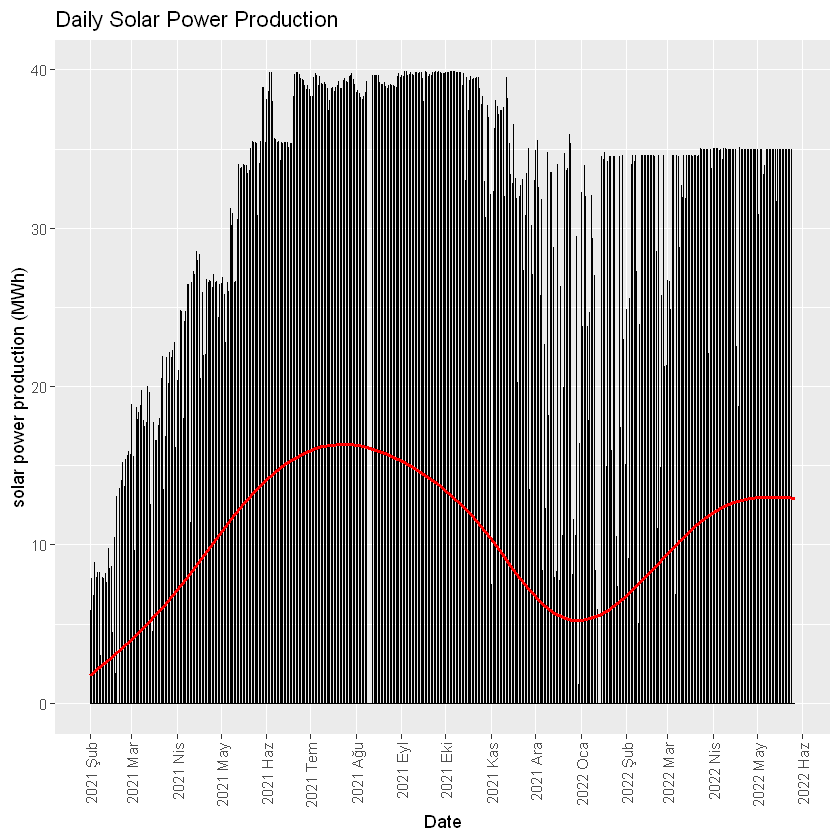

In [4]:

# plot the whole data
ggplot(merged,aes(x=date,y=production)) +  geom_line()+
  xlab("Date") + ylab("solar power production (MWh)")+ ggtitle("Daily Solar Power Production ")+
  scale_x_date(date_breaks = '1 month', date_labels = '%Y %b', date_minor_breaks = '1 month') +
  geom_smooth(color='red',linetype='solid',fill=NA)+theme(axis.text.x=element_text(angle=90,hjust=1, vjust = 0.5))




`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


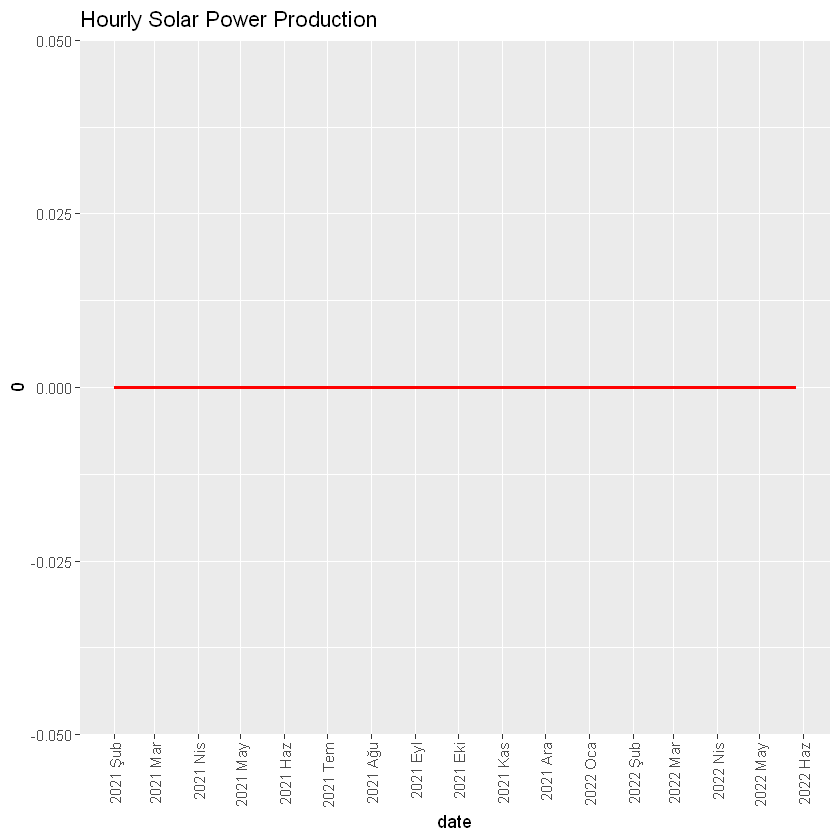

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


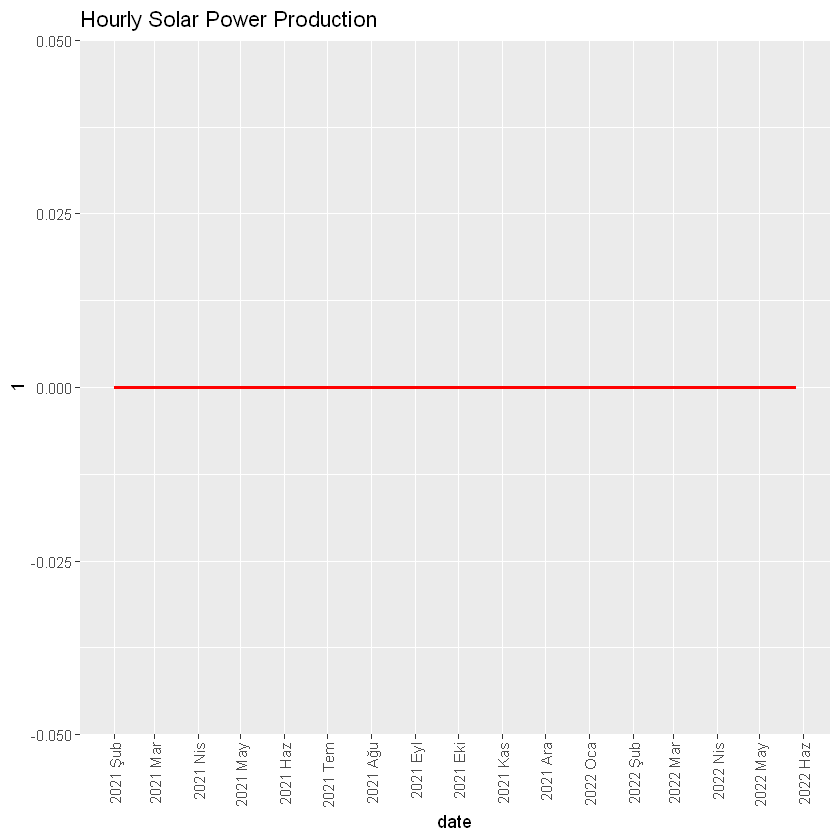

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


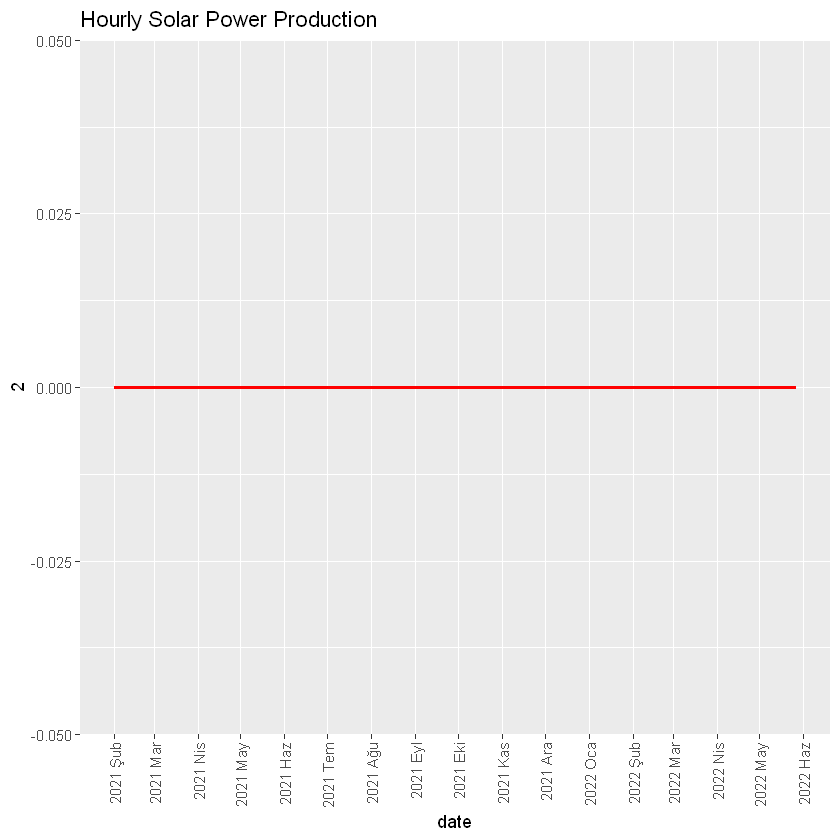

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


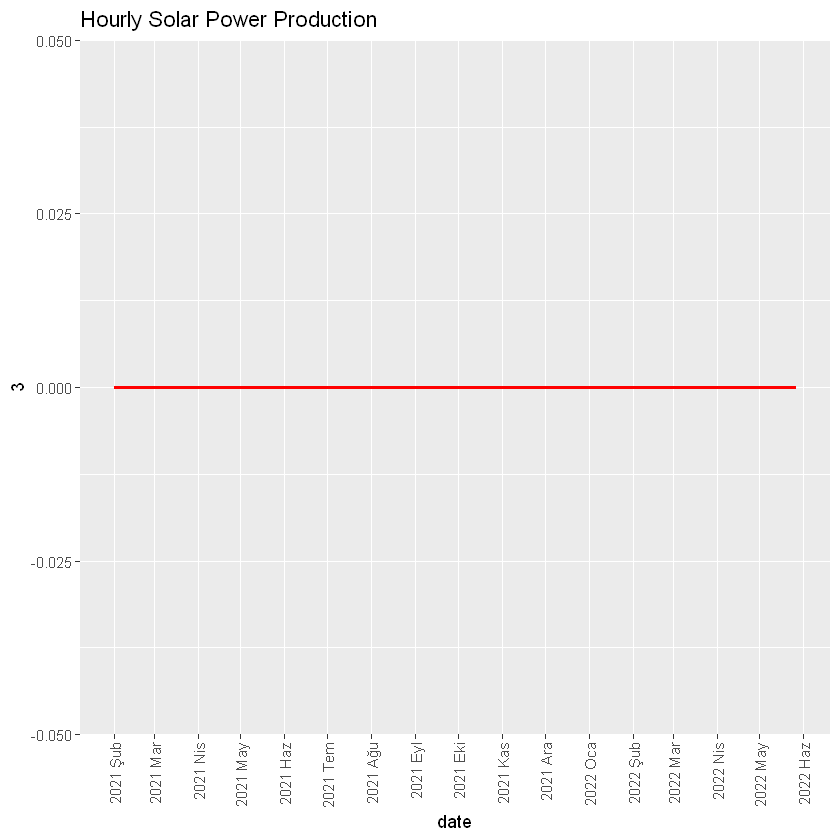

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

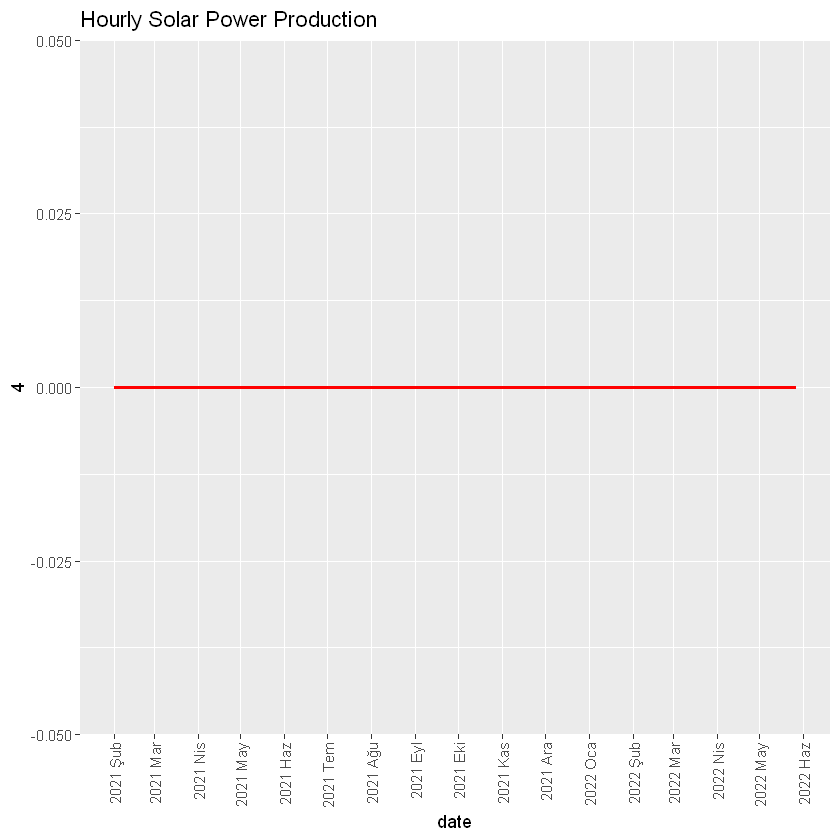

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

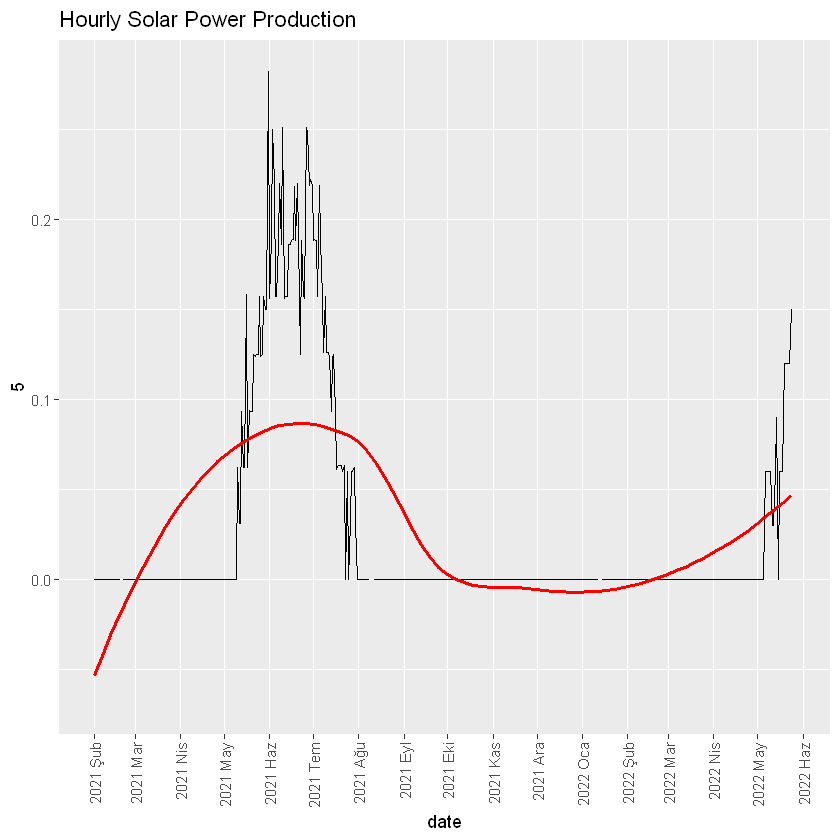

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

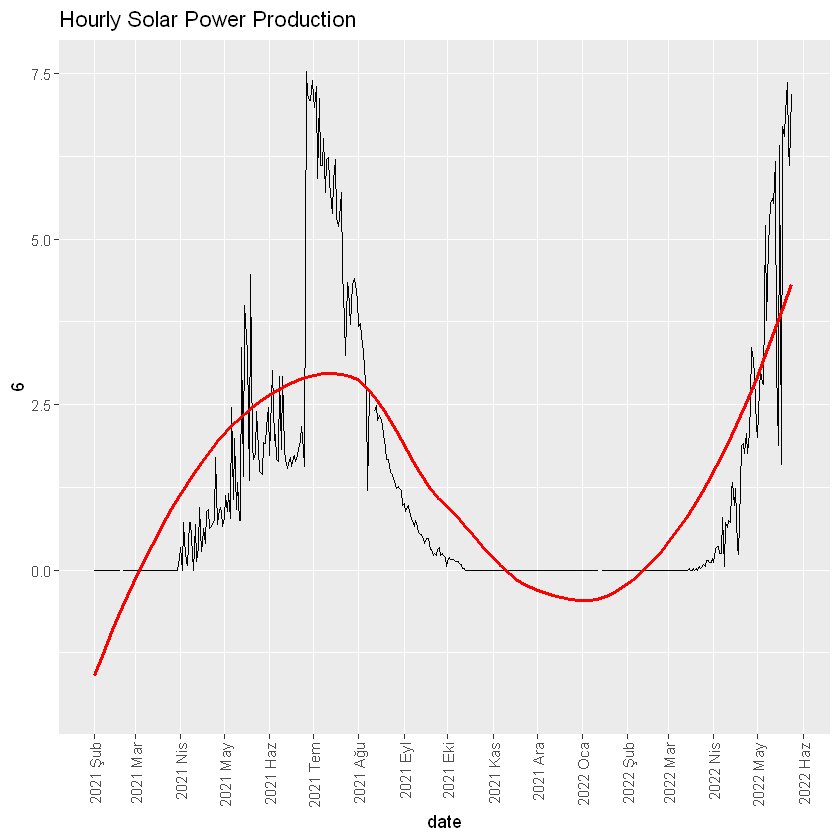

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

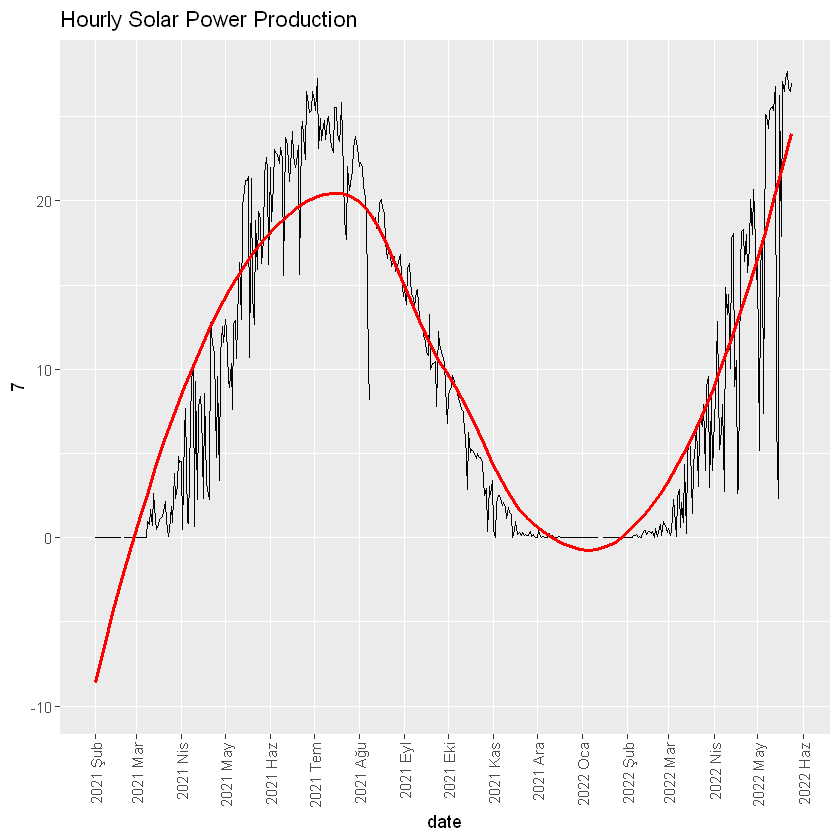

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

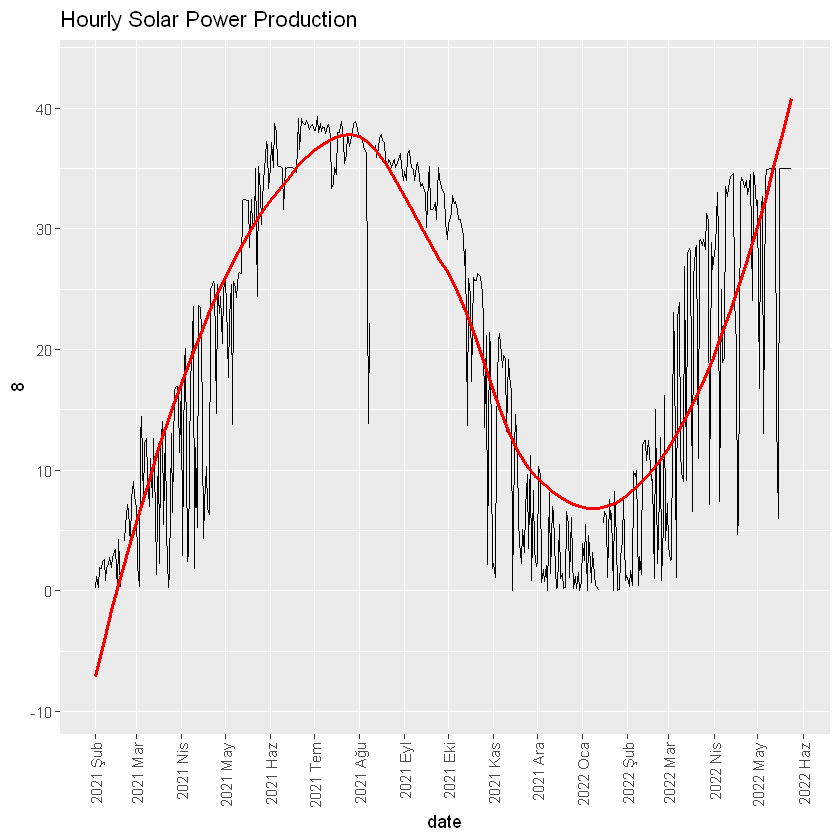

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

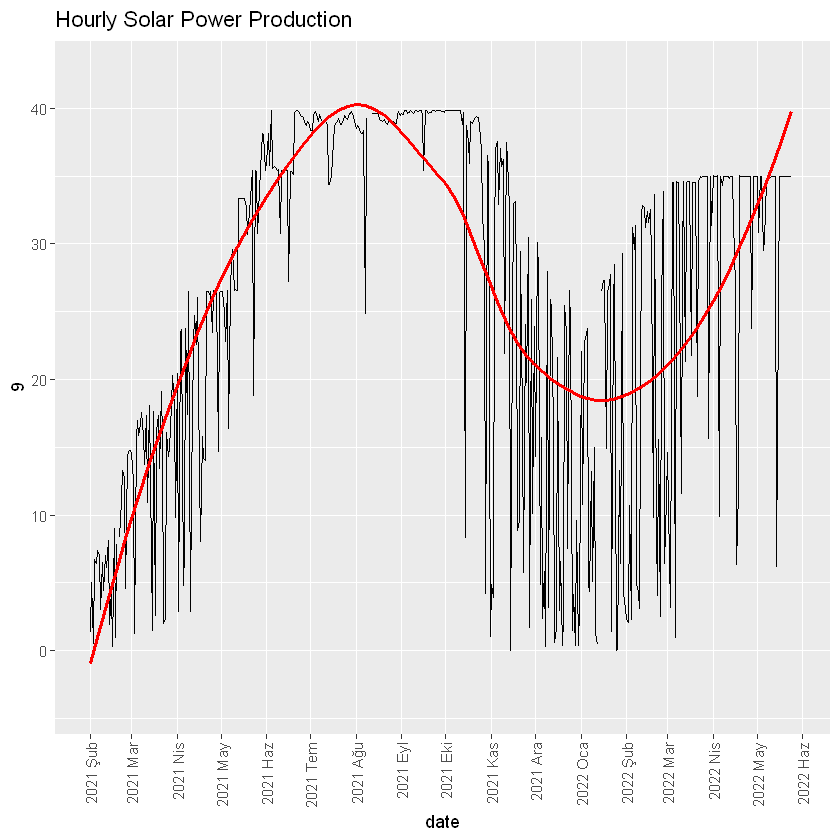

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

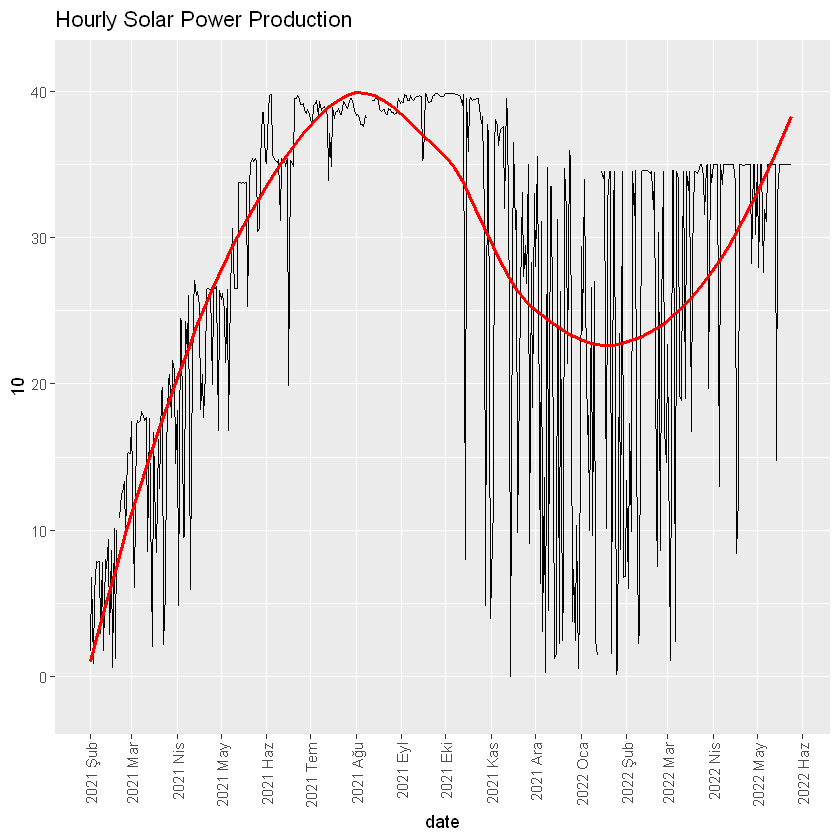

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

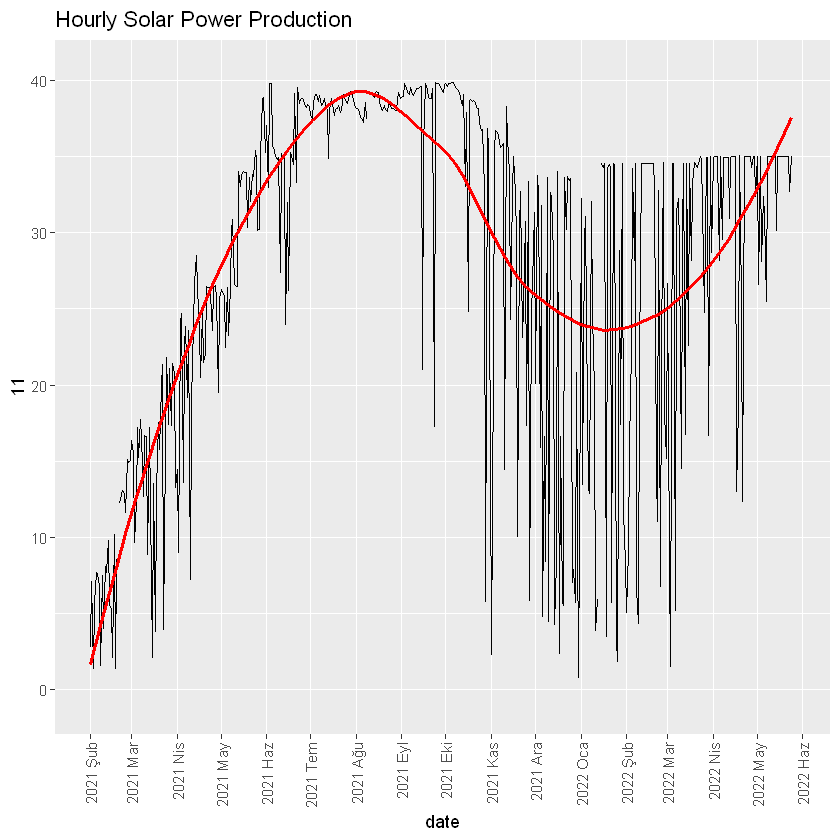

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

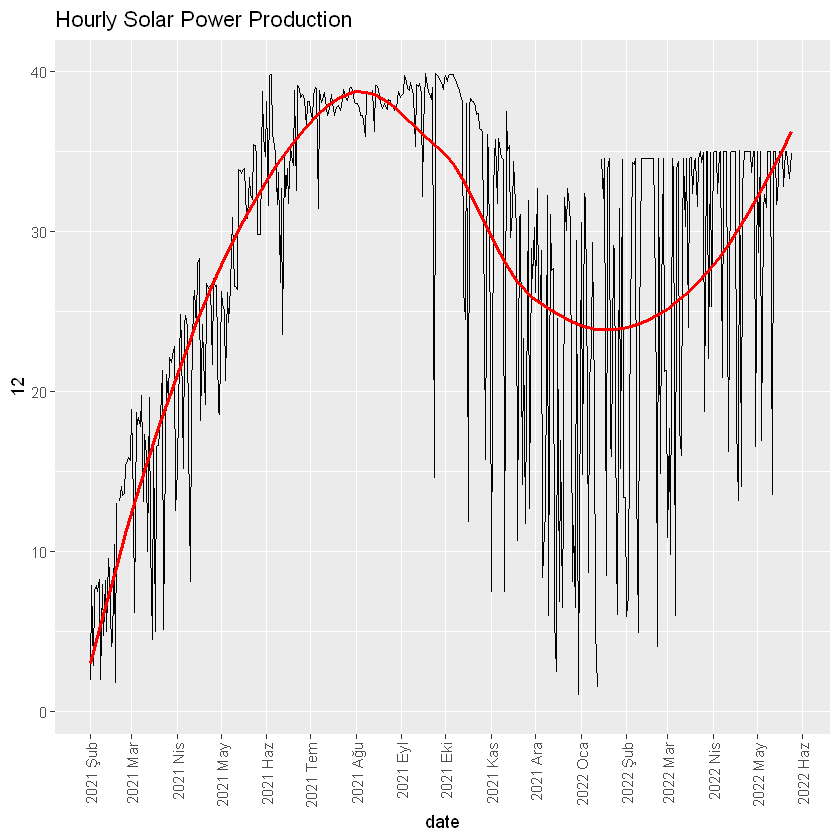

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

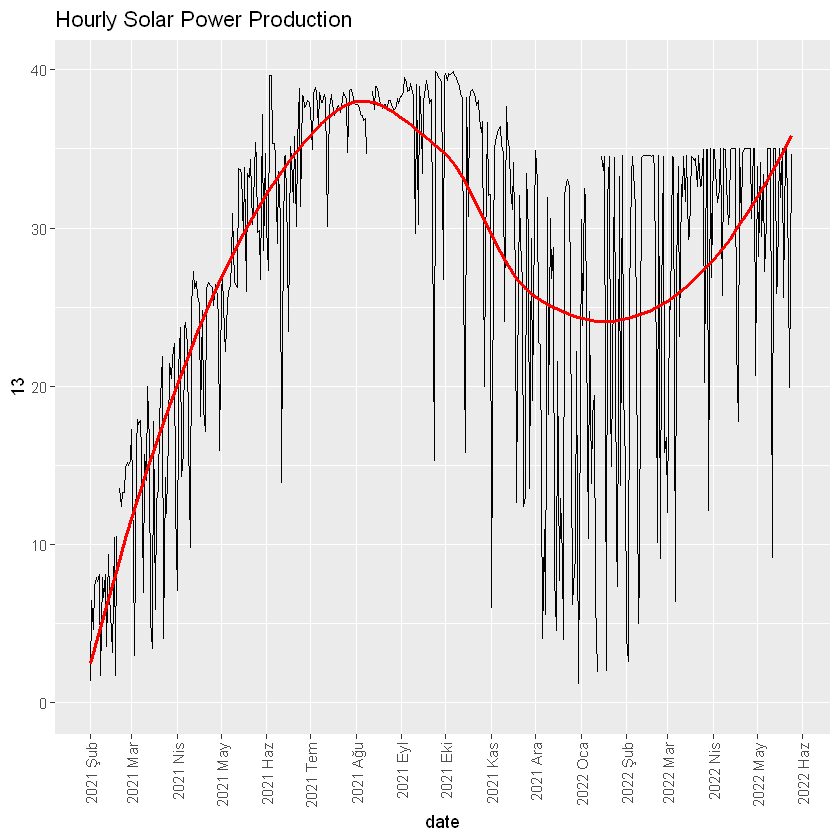

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

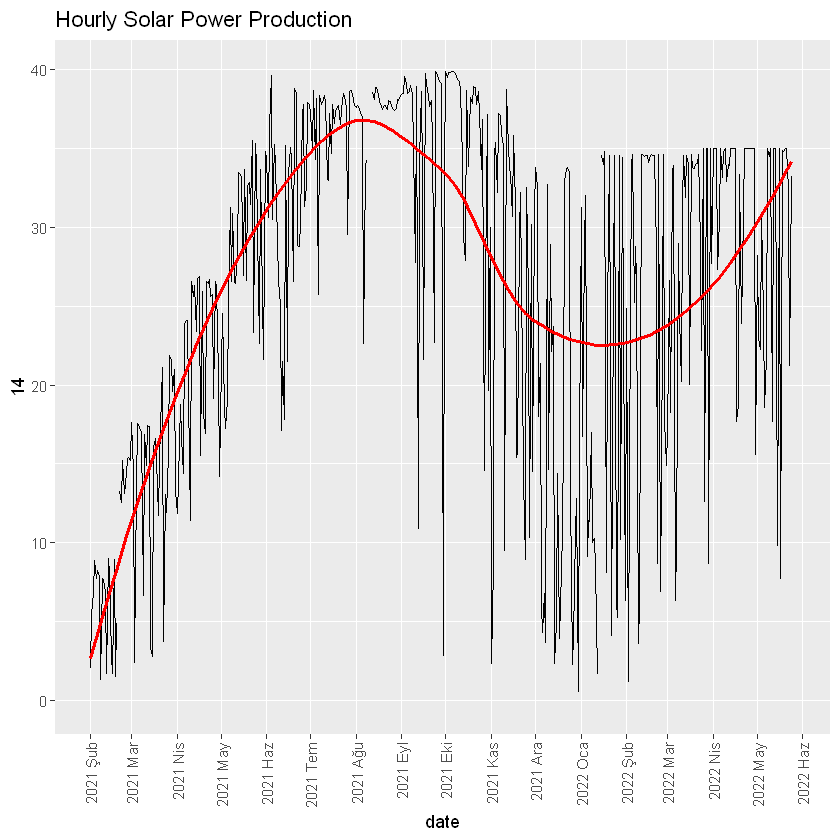

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

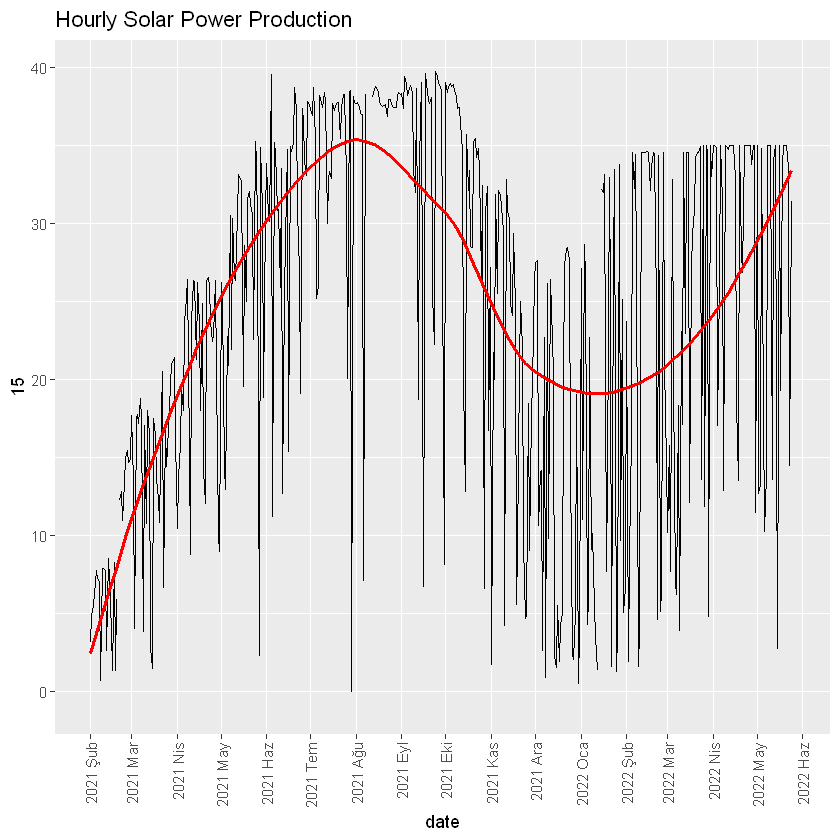

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

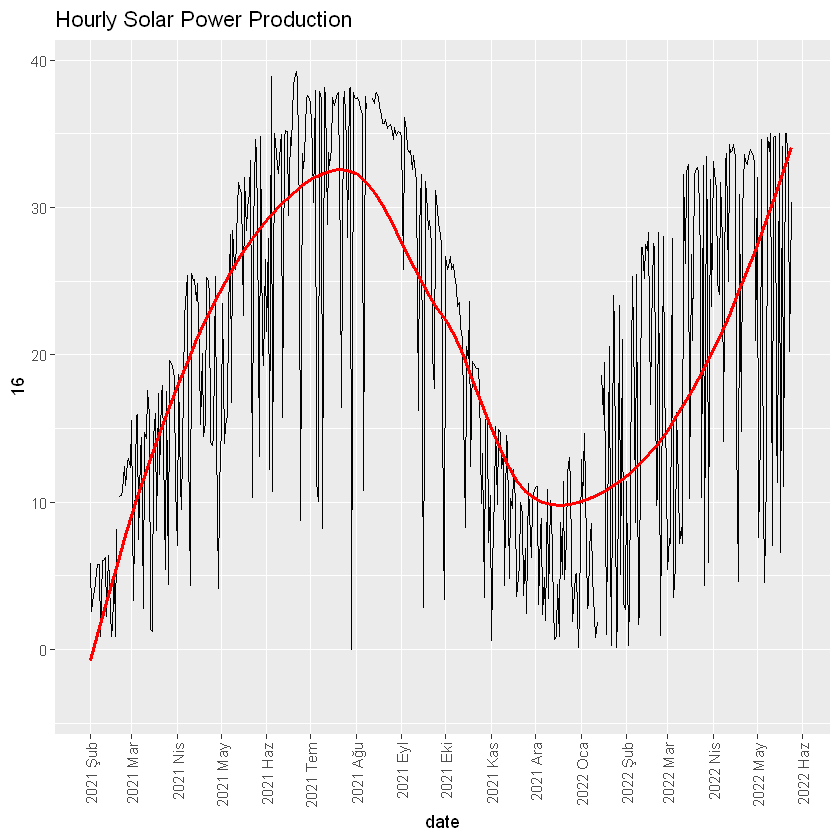

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

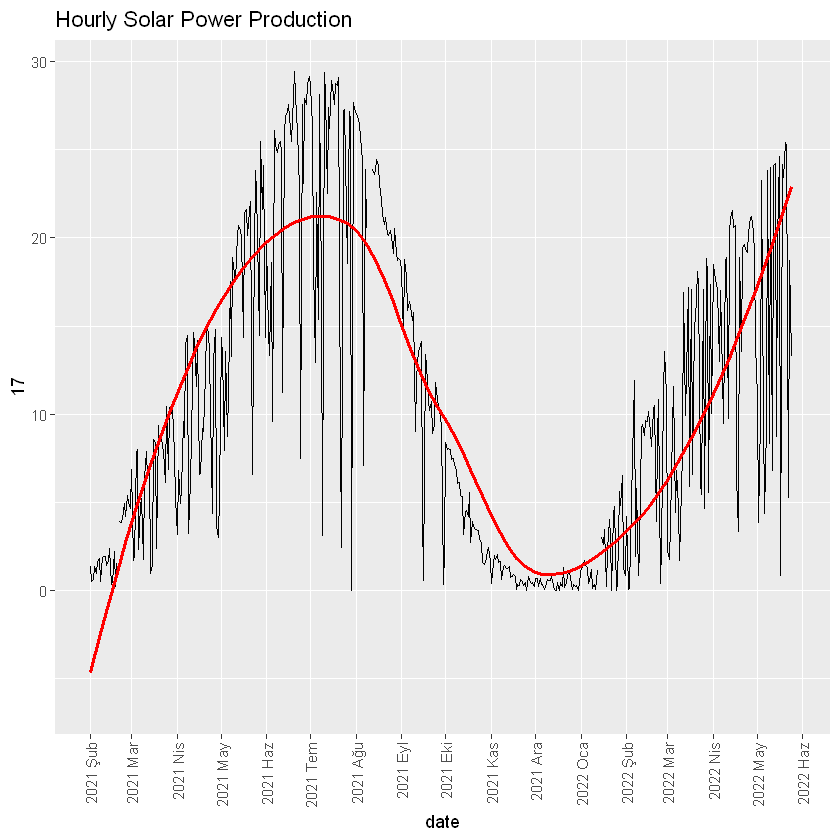

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

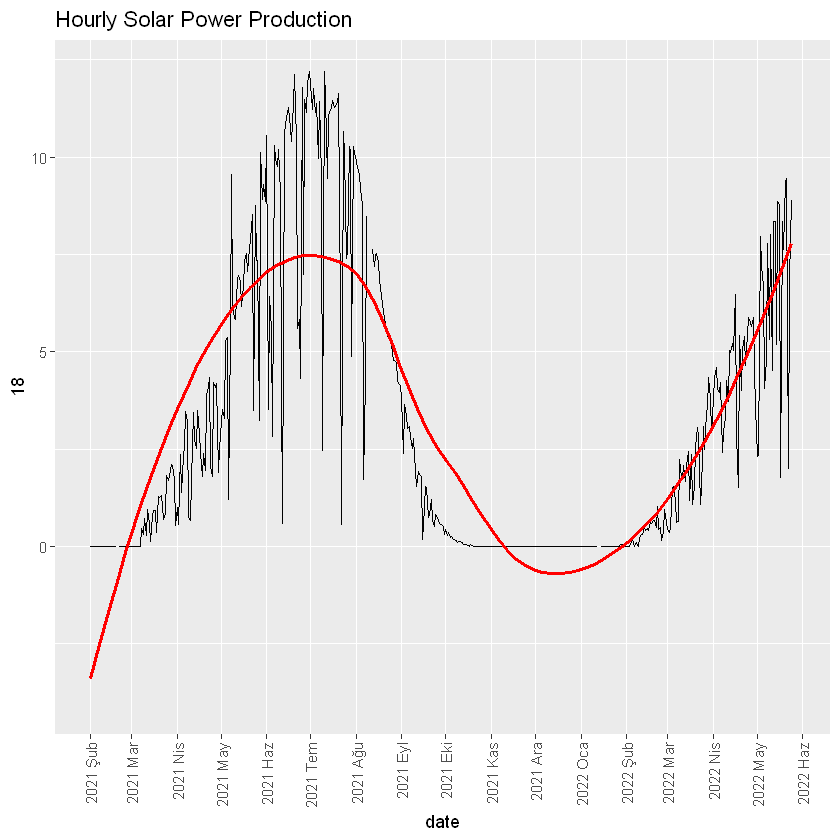

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

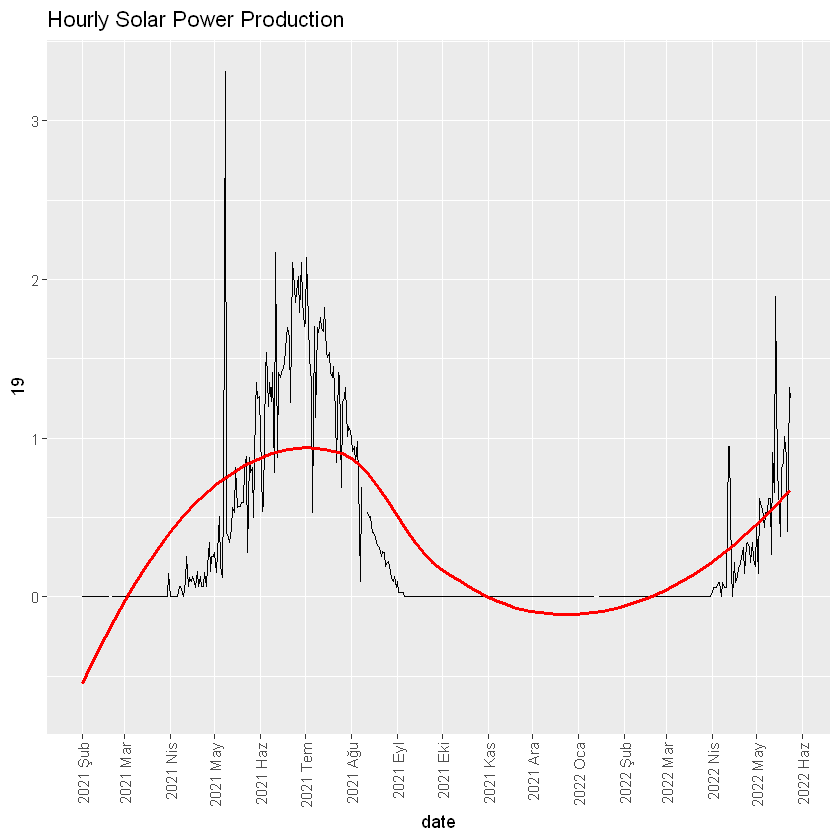

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


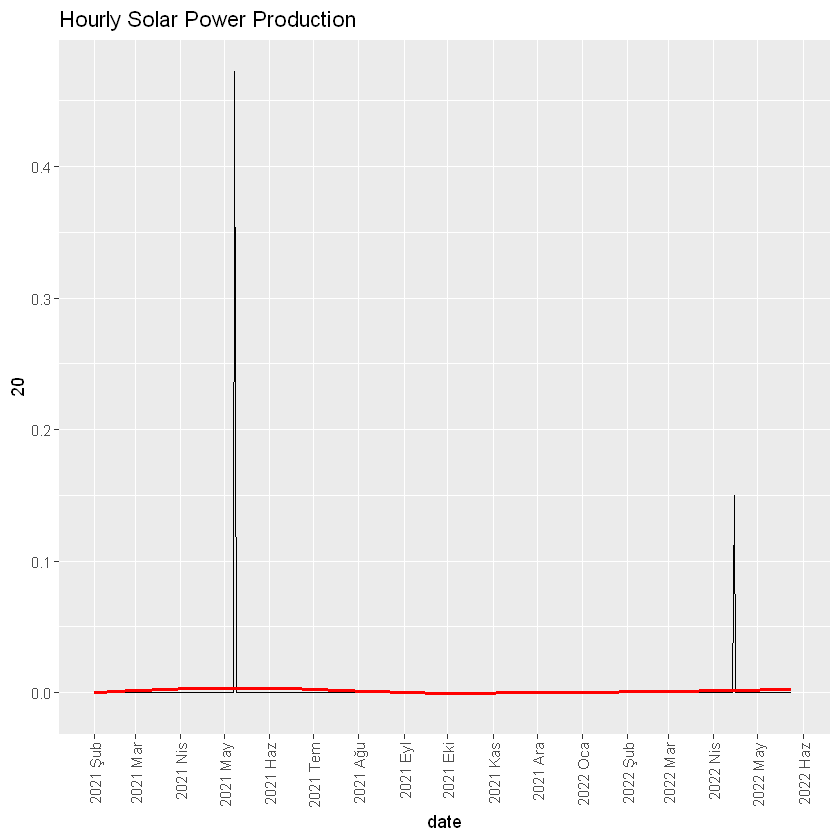

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


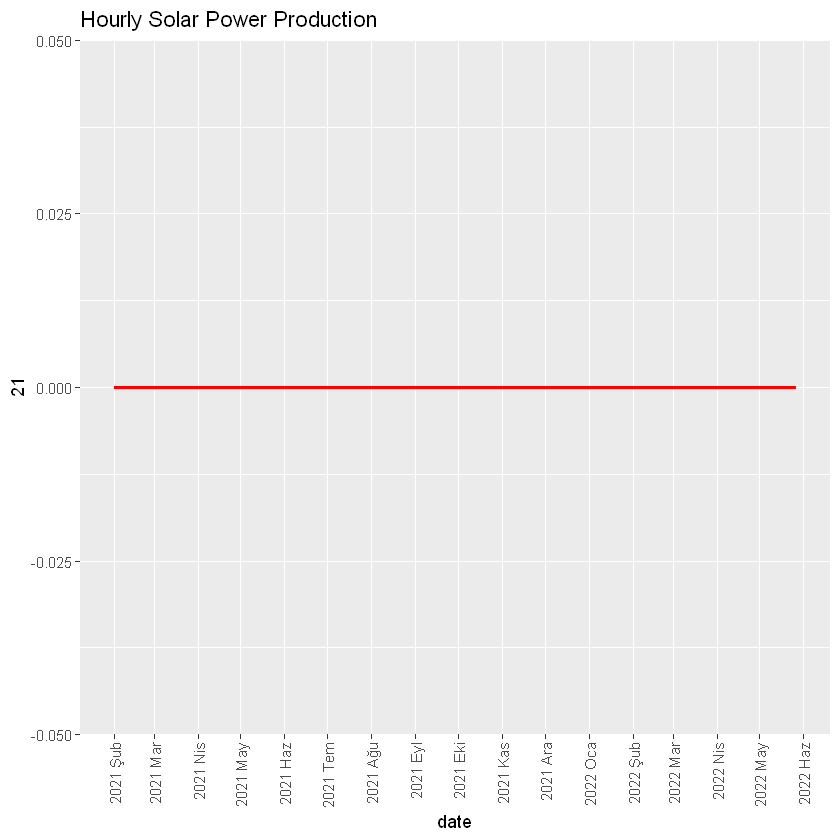

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


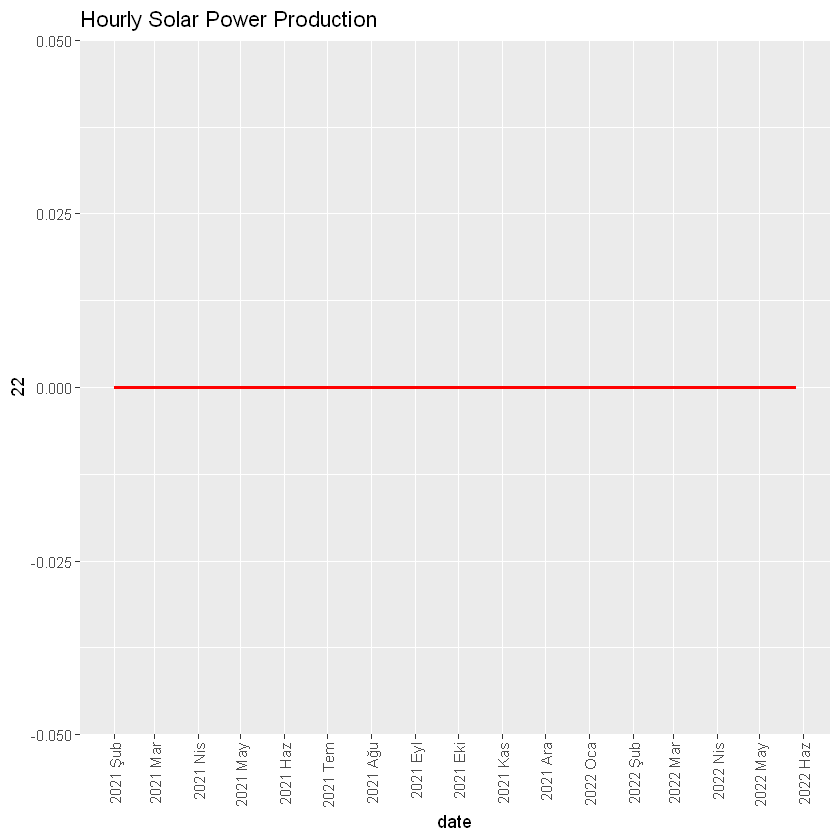

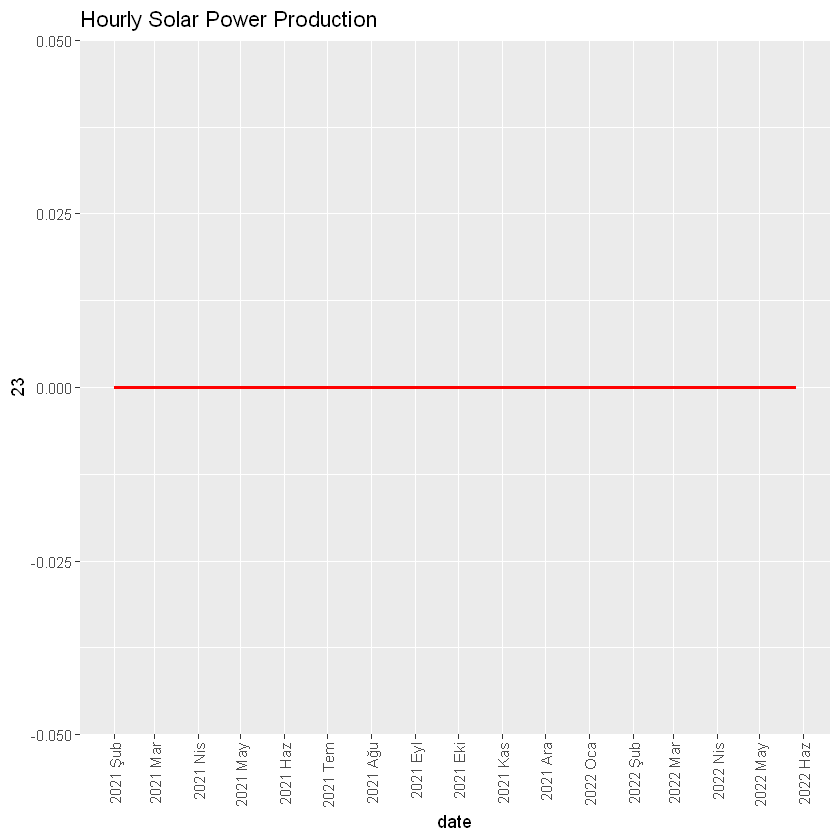

In [5]:
# plot each hour
for (i in 0:23){
  print(ggplot(merged[merged$hour==i,],aes(x=date,y=production)) +  geom_line()+
          xlab("date") + ylab(i)+ ggtitle("Hourly Solar Power Production")+
          scale_x_date(date_breaks = '1 month', date_labels = '%Y %b', date_minor_breaks = '1 month') +
          geom_smooth(color='red',linetype='solid',fill=NA)+theme(axis.text.x=element_text(angle=90,hjust=1, vjust = 0.5)))}

In [6]:
# missing data imputation
a='production ~ +CLOUD_LOW_LAYER_36.25_33+CLOUD_LOW_LAYER_36.25_33.25+CLOUD_LOW_LAYER_36.25_33.5+CLOUD_LOW_LAYER_36.5_33+CLOUD_LOW_LAYER_36.5_33.25+CLOUD_LOW_LAYER_36.5_33.5+CLOUD_LOW_LAYER_36.75_33+CLOUD_LOW_LAYER_36.75_33.25+CLOUD_LOW_LAYER_36.75_33.5+DSWRF_36.25_33+DSWRF_36.25_33.25+DSWRF_36.25_33.5+DSWRF_36.5_33+DSWRF_36.5_33.25+DSWRF_36.5_33.5+DSWRF_36.75_33+DSWRF_36.75_33.25+DSWRF_36.75_33.5+REL_HUMIDITY_36.25_33+REL_HUMIDITY_36.25_33.25+REL_HUMIDITY_36.25_33.5+REL_HUMIDITY_36.5_33+REL_HUMIDITY_36.5_33.25+REL_HUMIDITY_36.5_33.5+REL_HUMIDITY_36.75_33+REL_HUMIDITY_36.75_33.25+REL_HUMIDITY_36.75_33.5+TEMP_36.25_33+TEMP_36.25_33.25+TEMP_36.25_33.5+TEMP_36.5_33+TEMP_36.5_33.25+TEMP_36.5_33.5+TEMP_36.75_33+TEMP_36.75_33.25+TEMP_36.75_33.5+month'
for (i in 5:20){
  for (j in days[c(-1,-length(days))]){
    df=merged %>% filter(hour == i , as.Date(date )< as.Date(j))
    fit_<- lm(as.formula(a),df)
    merged[(merged$date==as.Date(j))&(merged$hour==i)]$production=predict(fit_,newdata=merged[(merged$date==as.Date(j))&(merged$hour==i)])
  }
}

Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(fit_, newdata = merged[(merged$date == as.Date(j)) & :
"prediction from a rank-deficient fit may be misleading"

In [7]:
# add columns
merged[,month:=months(as.Date(date))]
merged$month=as.factor(merged$month)
merged$hour=as.factor(merged$hour)
merged[,trend:=ceiling((1:.N)/24)]
merged[,avg_temp:=rowMeans(merged[,c(30:38)])]
merged[,avg_hum:=rowMeans(merged[,c(21:29)])]
merged[,avg_cloud:=rowMeans(merged[,c(3:11)])]
merged[,avg_dw:=rowMeans(merged[,c(12:20)])]

# 5- Different Models

## 5.1- Time Series Lineer Regression

Linear regression , especially on the basis of time series regression, is used to predict the value of a variable in the future. As the name suggests, this model tries to find a linear relationship between the dependent variable to be estimated and various independent input variables. Analyzing time-oriented data and forecasting future values of a time series are among the most important problems that analysts face in many fields, ranging from finance
and economics, to managing production operations, to the analysis of political and
social policy sessions, to investigating the impact of humans and the policy decisions
that they make on the environment. 


In our project, we provided hourly solar power prediction  for the next day. We put the data in wide format to work on different models easily. In order to see the seasonality of each hour, we created a separate data frame for each hour of the data and set up a separate linear regression model for each of these hours. 


* **Missing values**
	We observed that there are rows containing production with NA . In order to fill these productions, we determined the days whose production is NA and we made forecasts for each day and hour with the linear regression model, starting with the first NA and using the data up to that day. We used the same input variables for each day while creating this regression. We used each column in the data and additional "month" information to set up the model.
* **Training the model**
	We created different production plots for each hour to find out how much of the data to train. According to the plots that emerged as a result of this, we trained the entire data in some hours, while in some hours, we trained the data from 1 year ago until the day of prediction in order to obtain a pattern similar to the pattern in 2021.
* **Input variable selection**
	The input variables we use for each hour have changed. We used the ggpairs function to decide which variable to add. We added the variables that have a linear relationship with production to the model. At the same time, adjusted  R2was an important factor in which inputs we used. In addition to these, we sometimes add different lags of production to the model according to the autocorrelation plot of residuals.
* **Additionally added input variables:**
month: A column is added to account for the seasonality.<br>
hour: A column is added to split the data into different hours.<br>
trend: Calculated on a per day basis, different times of a day also got the same trend value.<br>
avg_temp: Average temperature of different latitude, longitude.<br>
avg_cloud: Average  cloud cover data (in terms of percentage).<br>
avg_dw: Average  downward shortwave radiation flux.<br>
avg_hum: Average relative humidity.<br>
ma_y: Average of last 3 production levels (MA with m=3).<br>
max_capacity: The maximum production level of the last 7 days has been determined as the production capacity of that hour of that day.<br>
lag1_y: The value of the production level in lag 1.<br>
lag14_y: The value of the production level in lag 14.<br>

* **Pre-processing**
	To reduce variablity and make data stationary in some hours, logarithm and differencing transformations were applied for target variable production and regression was built by using them.<br>
* **Post-processing**
	Until the production level exceeds 35 in the actual data, if the results from the model are greater than 35,  these results are replaced with 35. The model results were not changed when the actual values started to exceed 35, which we determined as the maximum capacity.
* **Hours that do not need a model**
	After observing production plots of different hours, we saw that the production levels of hour=0,1,2,3,4,21,22,23 are strictly zero while hour=20 production fluctuates around zero. For that reason we decide not to build a model for these hours.

In [11]:
# separation of data into hours
for (i in 0:23){
  value <- merged[hour==i]
  x <- paste("merged",i, sep="")
  eval(call("<-", as.name(x), value))
}

addWindow <- function(col, type, m){
  if (type=="moving_average"){
    arr<-rollmean(col,m,align='right') 
    arr=c(rep(NA,m-1),arr) 
  }
  else if(type=="max_capacity"){
    arr<-rollmax(col,m,align='right') 
    arr=c(rep(NA,m-1),arr) 
  }
  arr[length(arr)] <- arr[length(arr)-1]
  return (arr)
}

In [12]:
#adding moving average&lag 
merged5$ma_y = addWindow(merged5$production, type="moving_average", m=3)
merged5$max_capacity = addWindow(merged5$production, type="max_capacity", m=7)
merged6$ma_y = addWindow(merged6$production, type="moving_average", m=3)
merged6$max_capacity = addWindow(merged6$production, type="max_capacity", m=7)
merged7$ma_y = addWindow(merged7$production, type="moving_average", m=3)
merged7$max_capacity = addWindow(merged7$production, type="max_capacity", m=7)
merged8$ma_y = addWindow(merged8$production, type="moving_average", m=3)
merged8$max_capacity = addWindow(merged8$production, type="max_capacity", m=7)
merged9$ma_y = addWindow(merged9$production, type="moving_average", m=3)
merged9$max_capacity = addWindow(merged9$production, type="max_capacity", m=7)
merged10$ma_y = addWindow(merged10$production, type="moving_average", m=3)
merged10$max_capacity = addWindow(merged10$production, type="max_capacity", m=7)
merged11$ma_y = addWindow(merged11$production, type="moving_average", m=3)
merged11$max_capacity = addWindow(merged11$production, type="max_capacity", m=7)
merged12$ma_y = addWindow(merged12$production, type="moving_average", m=3)
merged12$max_capacity = addWindow(merged12$production, type="max_capacity", m=7)
merged13$ma_y = addWindow(merged13$production, type="moving_average", m=3)
merged13$max_capacity = addWindow(merged13$production, type="max_capacity", m=7)
merged14$ma_y = addWindow(merged14$production, type="moving_average", m=3)
merged14$max_capacity = addWindow(merged14$production, type="max_capacity", m=7)
merged15$ma_y = addWindow(merged15$production, type="moving_average", m=3)
merged15$max_capacity = addWindow(merged15$production, type="max_capacity", m=7)
merged16$ma_y = addWindow(merged16$production, type="moving_average", m=3)
merged16$max_capacity = addWindow(merged16$production, type="max_capacity", m=7)
merged17$ma_y = addWindow(merged17$production, type="moving_average", m=3)
merged17$max_capacity = addWindow(merged17$production, type="max_capacity", m=7)
merged18$ma_y = addWindow(merged18$production, type="moving_average", m=3)
merged18$max_capacity = addWindow(merged18$production, type="max_capacity", m=7)
merged19$ma_y = addWindow(merged19$production, type="moving_average", m=3)
merged19$max_capacity = addWindow(merged19$production, type="max_capacity", m=7)


merged5[,lag1_y:=shift(production,type="lag",n=1)]
merged5[,lag14_y:=shift(production,type="lag",n=14)]
merged6[,lag1_y:=shift(production,type="lag",n=1)]
merged7[,lag1_y:=shift(production,type="lag",n=1)]
merged8[,lag1_y:=shift(production,type="lag",n=1)]
merged9[,lag1_y:=shift(production,type="lag",n=1)]
merged10[,lag1_y:=shift(production,type="lag",n=1)]
merged11[,lag1_y:=shift(production,type="lag",n=1)]
merged12[,lag1_y:=shift(production,type="lag",n=1)]
merged13[,lag1_y:=shift(production,type="lag",n=1)]
merged14[,lag1_y:=shift(production,type="lag",n=1)]
merged15[,lag1_y:=shift(production,type="lag",n=1)]
merged16[,lag1_y:=shift(production,type="lag",n=1)]
merged17[,lag1_y:=shift(production,type="lag",n=1)]
merged18[,lag1_y:=shift(production,type="lag",n=1)]
merged19[,lag1_y:=shift(production,type="lag",n=1)]


Call:
lm(formula = as.formula(formula10), data = forfit10)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.7043  -2.5310   0.0908   2.7980  14.2033 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 76.65283   98.27917   0.780 0.439415    
trend       -0.49211    0.15568  -3.161 0.002780 ** 
monthNisan  -4.62716    4.00667  -1.155 0.254110    
avg_hum     -0.01309    0.10398  -0.126 0.900380    
avg_dw       0.11551    0.01918   6.021 2.69e-07 ***
avg_cloud    0.37139    0.10266   3.618 0.000736 ***
avg_temp     0.38421    0.32201   1.193 0.238920    
ma_y        -1.13550    0.26735  -4.247 0.000104 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.152 on 46 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4583,	Adjusted R-squared:  0.3759 
F-statistic:  5.56 on 7 and 46 DF,  p-value: 0.0001109


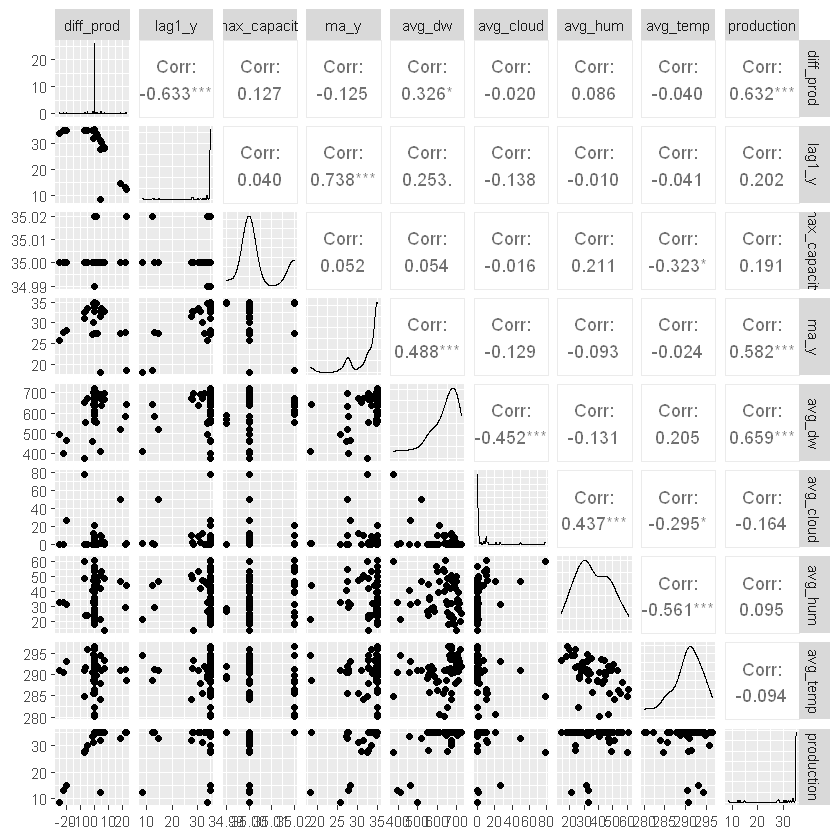


	Breusch-Godfrey test for serial correlation of order up to 11

data:  Residuals
LM test = 17.867, df = 11, p-value = 0.08472


1         1         1 
 0.000000  0.000000  0.000000  0.000000  0.000000  0.117201  5.187195 23.767040 
        1         1         1         1         1         1         1         1 
36.323065 36.245834 33.387825 33.886024 31.846687 32.410535 30.404550 33.018169 
        1         1         1         1                                         
25.746604 13.860322  6.975804  1.180263  0.000000  0.000000  0.000000  0.000000

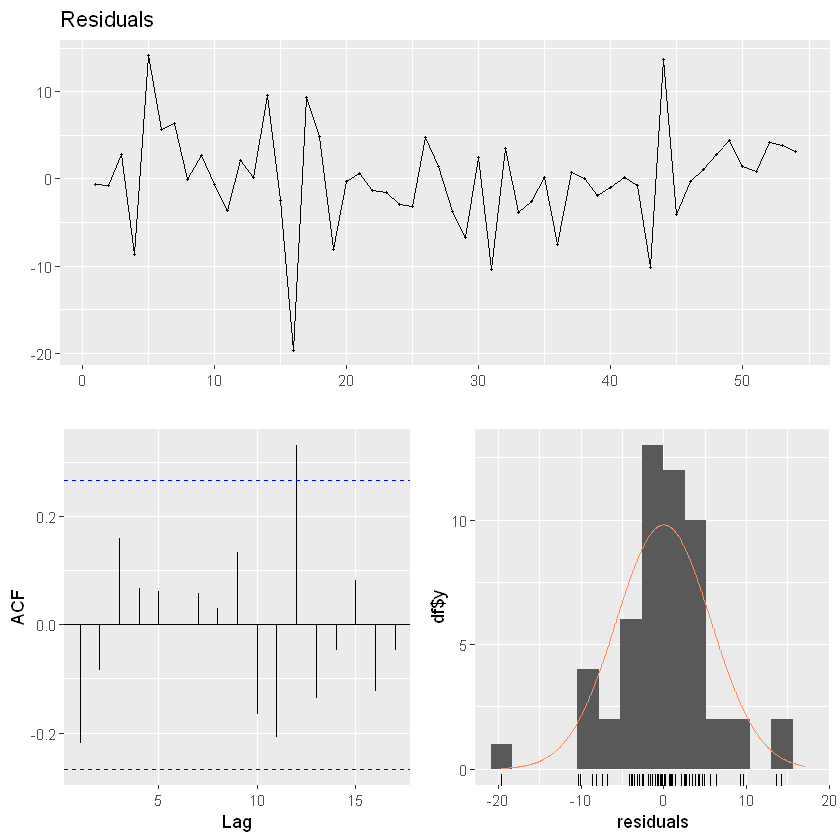

In [17]:
options(warn=-1)
# model building and predictions
forecast_lm <- c(0, 0, 0, 0, 0)

# hour=5
forfit5=merged5 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-05-01"))
##ggpairs(forfit5[,c(49,48,47,46,45,44,43,42,39)])
formula5='production ~ +max_capacity*trend+avg_cloud+avg_temp+avg_hum+month+lag1_y+lag14_y'
fit5<- lm(as.formula(formula5),forfit5)
#summary(fit5)
#checkresiduals(fit5)
# merged5[nrow(merged5)]$production=predict(fit5,merged5[nrow(merged5)])
forecast_lm <- append(forecast_lm, predict(fit5,merged5[nrow(merged5)]))

# hour=6
forfit6=merged6 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-05-01"))
##ggpairs(forfit6[,c(48,47,46,45,44,43,42,39)])
formula6='production ~ +max_capacity*trend+avg_cloud+avg_temp+avg_hum+month+ma_y'
fit6<- lm(as.formula(formula6),forfit6)
#summary(fit6)
#checkresiduals(fit6)
# merged6[nrow(merged6)]$production=merged6[nrow(merged6)-1]$production+predict(fit6,merged6[nrow(merged6)])
forecast_lm <- append(forecast_lm, predict(fit6,merged6[nrow(merged6)]))

#hour=7
#ggpairs(merged7[,c(48,47,46,45,44,43,42,39)])
formula7="production~+I(avg_cloud^2)+I(avg_temp^2)+I(avg_hum^2)+max_capacity*trend+ma_y+month"
fit7<- lm(as.formula(formula7),merged7)
#summary(fit7)
#checkresiduals(fit7)

# merged7[nrow(merged7)]$production=predict(fit7,merged7[nrow(merged7)])
forecast_lm <- append(forecast_lm, predict(fit7,merged7[nrow(merged7)]))

#hour=8
#ggpairs(merged8[,c(48,47,46,45,44,43,42,39)])
formula8='production ~ +avg_cloud+avg_dw+avg_hum+avg_temp+month+max_capacity*trend+ma_y+lag1_y'
fit8<- lm(as.formula(formula8),merged8)
#summary(fit8)
#checkresiduals(fit8)
# merged8[nrow(merged8)]$production=predict(fit8,merged8[nrow(merged8)])
forecast_lm <- append(forecast_lm, predict(fit8,merged8[nrow(merged8)]))

#hour=9
forfit9=merged9 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-04-01"))
forfit9[,log_prod:=log(forfit9$production)]
forfit9[forfit9$production==0]$log_prod=NA
#ggpairs(forfit9[,c(49,48,47,46,45,44,43,42,39)])
formula9='log_prod ~+trend +avg_temp+avg_hum+month+ma_y+max_capacity*trend+avg_hum+lag1_y'
fit9<- lm(as.formula(formula9),forfit9)
#summary(fit9)
#checkresiduals(fit9)
# merged9[nrow(merged9)]$production=exp(predict(fit9,merged9[nrow(merged9)]))
forecast_lm <- append(forecast_lm, exp(predict(fit9,merged9[nrow(merged9)])))

#hour=10
forfit10=merged10 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2022-04-01"))
forfit10[,diff_prod:=c(NA,diff(forfit10$production))]
ggpairs(forfit10[,c(49,48,47,46,45,44,43,42,39)])
formula10='diff_prod ~+trend+month+avg_hum+avg_dw+avg_cloud+avg_temp+ma_y'
fit10<- lm(as.formula(formula10),forfit10)
summary(fit10)
checkresiduals(fit10)
# merged10[nrow(merged10)]$production=merged10$production[nrow(merged10)-3]+predict(fit10,merged10[nrow(merged10)])
forecast_lm <- append(forecast_lm, merged10$production[nrow(merged10)-3] + predict(fit10,merged10[nrow(merged10)]))

#hour=11
forfit11=merged10 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2022-04-01"))
forfit11[,diff_prod:=c(NA,diff(forfit11$production))]
#ggpairs(forfit11[,c(49,48,47,46,45,44,43,42,39)])
formula11='production ~ma_y+month+avg_temp+avg_hum+avg_cloud+max_capacity+lag1_y'
fit11<- lm(as.formula(formula11),forfit11)
#summary(fit11)
#checkresiduals(fit11)
# merged11[nrow(merged11)]$production=predict(fit11,merged11[nrow(merged11)])
forecast_lm <- append(forecast_lm, predict(fit11,merged11[nrow(merged11)]))

#hour=12
formula12='production ~trend+month+avg_temp+avg_hum+avg_cloud+max_capacity+lag1_y'
fit12<- lm(as.formula(formula12),merged12)
#summary(fit12)
#checkresiduals(fit12)
# merged12[nrow(merged12)]$production=predict(fit12,merged12[nrow(merged12)])
forecast_lm <- append(forecast_lm, predict(fit12,merged12[nrow(merged12)]))

#hour=13
#ggpairs(merged13[,c(48,47,46,45,44,43,42,39)])
formula13='production ~trend+month+avg_temp+avg_hum+lag1_y+ma_y' 
fit13 <- lm(as.formula(formula13),merged13)
#summary(fit13)
#checkresiduals(fit13)
# merged13[nrow(merged13)]$production=predict(fit13,merged13[nrow(merged13)])
forecast_lm <- append(forecast_lm, predict(fit13,merged13[nrow(merged13)]))

#hour=14
#ggpairs(merged14[,c(48,47,46,45,44,43,42,39)])
formula14='production ~month+avg_temp+avg_hum+ma_y+avg_temp+avg_dw+lag1_y' 
fit14 <- lm(as.formula(formula14),merged14)
#summary(fit14)
#checkresiduals(fit14)
# merged14[nrow(merged14)]$production=predict(fit14,merged14[nrow(merged14)])
forecast_lm <- append(forecast_lm, predict(fit14,merged14[nrow(merged14)]))

#hour=15
#ggpairs(merged15[,c(48,47,46,45,44,43,42,39)])
formula15 = 'diff_prod ~ month+avg_hum+ma_y+avg_dw+lag1_y+max_capacity'
merged15[,diff_prod:=c(NA,diff(merged15$production))]
fit15<- lm(as.formula(formula15),merged15)
#summary(fit15)
#checkresiduals(fit15)
# merged15[nrow(merged15)]$production=merged15$production[nrow(merged15)-3]+predict(fit15,merged15[nrow(merged15)])
forecast_lm <- append(forecast_lm, merged15$production[nrow(merged15)-3] + predict(fit15,merged15[nrow(merged15)]))

#hour=16
#ggpairs(merged16[,c(48,47,46,45,44,43,42,39)])
formula16='production ~trend+month+avg_temp+lag1_y+ma_y+I(avg_hum^2)+avg_dw+max_capacity*avg_hum' 
fit16<- lm(as.formula(formula16),merged16)
#summary(fit16)
#checkresiduals(fit16)
# merged16[nrow(merged16)]$production=predict(fit16,merged16[nrow(merged16)])
forecast_lm <- append(forecast_lm, predict(fit16,merged16[nrow(merged16)]))

#hour=17
#ggpairs(merged17[,c(48,47,46,45,44,43,42,39)])
formula17='production ~trend+month+avg_temp+lag1_y+ma_y+I(avg_hum^2)+avg_dw'
fit17<- lm(as.formula(formula17),merged17)
#summary(fit17)
#checkresiduals(fit17)
# merged17[nrow(merged17)]$production=predict(fit17,merged17[nrow(merged17)])
forecast_lm <- append(forecast_lm, predict(fit17,merged17[nrow(merged17)]))

#hour=18
#ggpairs(merged18[,c(48,47,46,45,44,43,42,39)])
formula18='production ~month+avg_temp+lag1_y+ma_y+avg_dw+I(avg_dw^2)'
fit18<- lm(as.formula(formula18),merged18)
#summary(fit18)
#checkresiduals(fit18)
# merged18[nrow(merged18)]$production=predict(fit18,merged18[nrow(merged18)])
forecast_lm <- append(forecast_lm, predict(fit18,merged18[nrow(merged18)]))

#hour=19
forfit19=merged19 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-04-01"))
#ggpairs(forfit19[,c(48,47,46,45,44,43,42,39)])
formula19='production ~month+lag1_y+ma_y'
fit19<- lm(as.formula(formula19),forfit19)
#summary(fit19)
#checkresiduals(fit19)
# merged19[nrow(merged19)]$production=predict(fit19,merged19[nrow(merged19)])
forecast_lm <- append(forecast_lm, predict(fit19,merged19[nrow(merged19)]))


forecast_lm <- append(forecast_lm, c(0, 0, 0, 0))
forecast_lm


* **Note:** Since we had the production data until 2 days ago, and we made the forecast for the next day, there was a 3-day gap in between. The two days in between showed up as NA in the data. Since the NAs up to the day we made our forecast were filled with linear regression in pre-processing, errors accumulated . This is also the reason for the variance increase seen in the regression plots.

## 5.2- ARIMA

ARIMA is the abbreviation of the Autoregressive Integrated Moving Average. It is a statistical model used to predict future values based on the past values. In this project, the ARIMA model is used first to see whether it is a good model in terms of predicting the production of hourly solar power.


ARIMA model consists of three parts: 
* **AR-Autoregression:** In this kind of statistical model lagged values of the target variable are used to build the model. 
I-Integrated: Differencing is used to make times series stationary. Main reason behind making time series stationary is the fact that building a good model is not easy unless time series data is stationary. Difference between the value of the target variable and the previous one is taken and used as new data points. 
* **MA-Moving Average:** Moving average takes residuals into account and search for their dependency by looking at their lagged values. 
ARIMA combines these three parts and builds one single model with the parameters required. 
These parameters are p,d and q and can be defined briefly as follows:

**p:** order of the autoregressive part, the number of lag observations will be used in the model<br>
**q:** order of the moving average part, the moving average window will be used in the model<br>
**d:** degree of first differencing involved. <br>


To build an ARIMA model parameters described above need to be specified or a function called auto.arima can be used. 
In this project, to analyze every hour separately we have splitted data into 24 hours and for each hour in which there is production, we have built arima models. Following steps are applied to achieve a good model: 
* **Visualization of the time series:** Before working on the data, the plot of the time series should be drawn to inspect data characteristics. The visualization of the time series provides some insights about successor steps to be followed. After plotting the time series, we have realized that the time series we have is not stationary and variance is changing over time. 
* **Stationarity check of the data:** Stationary time series can be defined as the time series which does not depend on time and does not have variance changing over time. To build a better model one of the first things to consider is the stationarity of the time series. Before starting the model, we first applied one of the stationarity tests which is the KPSS test. The result we have found was higher than the critical values which implies that at the beginning time series for each hour was not stationary. To reduce variance of the time series and make time series stationary, we have used the Box-Cox algorithm. Once again the KPSS test is applied and the time series we found with the Box-Cox algorithm  was not stationary again, thus we have applied another method used for eliminating non-stationarity of the time series. 
* **Differencing:** Differencing is used to get rid of the variance around the mean which as a result leads to elimination of trend and seasonality. In short, a time series is obtained by taking the difference between the previous and the current observation.  To see the differencing method effect, ACF and PACF are plotted and the results we have found were good enough to proceed with building an ARIMA model. 
* **Auto.arima:** Auto.arima is used to find the parameters for the model. We have built different ARIMA models for each hour and the Table3 gives the final ARIMA models with the parameters.
* **Check Residuals:** After building the model, it is required to check residuals and they are expected to look like white noise. The residuals we have found were not following the exact white noise pattern however, since there was not considerable difference, we have continued with the models we have found. 

Loading required package: urca



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0593 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0519 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0962 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


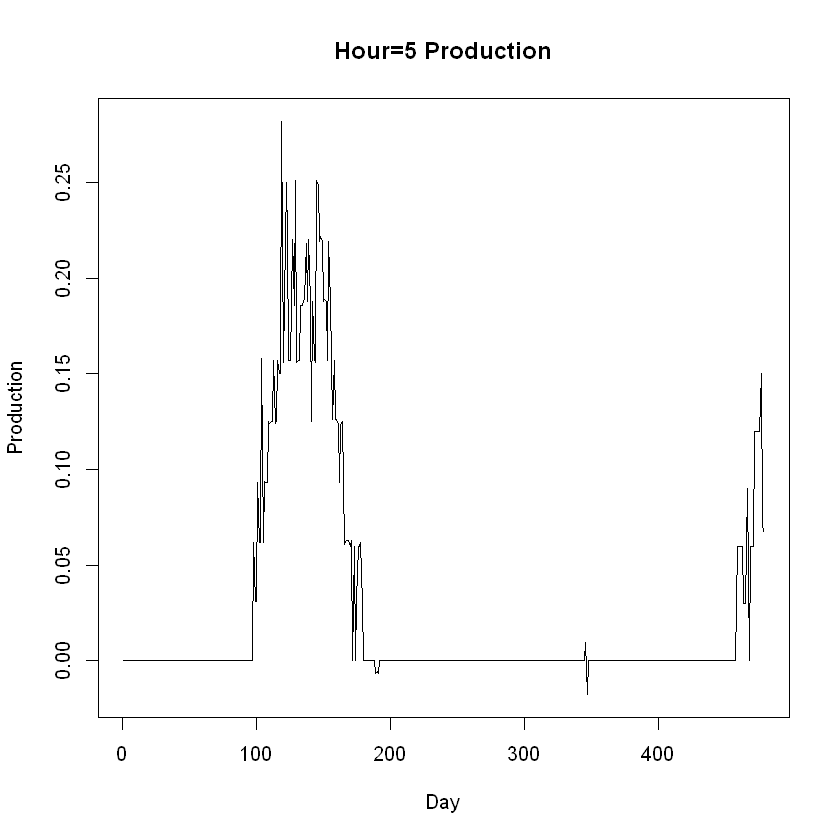


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -2248.89
 ARIMA(0,0,0) with non-zero mean : -2117.537
 ARIMA(1,0,0) with non-zero mean : -2208.16
 ARIMA(0,0,1) with non-zero mean : -2235.144
 ARIMA(0,0,0) with zero mean     : -2119.516
 ARIMA(1,0,2) with non-zero mean : -2232.815
 ARIMA(2,0,1) with non-zero mean : -2247.378
 ARIMA(3,0,2) with non-zero mean : -2249.418
 ARIMA(3,0,1) with non-zero mean : -2244.944
 ARIMA(4,0,2) with non-zero mean : Inf
 ARIMA(3,0,3) with non-zero mean : -2258.416
 ARIMA(2,0,3) with non-zero mean : -2257.991
 ARIMA(4,0,3) with non-zero mean : Inf
 ARIMA(3,0,4) with non-zero mean : -2258.767
 ARIMA(2,0,4) with non-zero mean : -2261.446
 ARIMA(1,0,4) with non-zero mean : -2243.477
 ARIMA(2,0,5) with non-zero mean : -2260.174
 ARIMA(1,0,3) with non-zero mean : -2236.954
 ARIMA(1,0,5) with non-zero mean : -2264.943
 ARIMA(0,0,5) with non-zero mean : -2246.179
 ARIMA(0,0,4) with non-zero mean : -2246.021
 ARIMA(1

Series: diff_series 
ARIMA(1,0,5) with zero mean 

Coefficients:
         ar1      ma1     ma2     ma3      ma4     ma5
      0.8987  -1.4787  0.5691  0.0450  -0.2870  0.2439
s.e.  0.0415   0.0582  0.0785  0.0793   0.0661  0.0421

sigma^2 estimated as 0.0005007:  log likelihood=1140.54
AIC=-2267.08   AICc=-2266.84   BIC=-2237.89

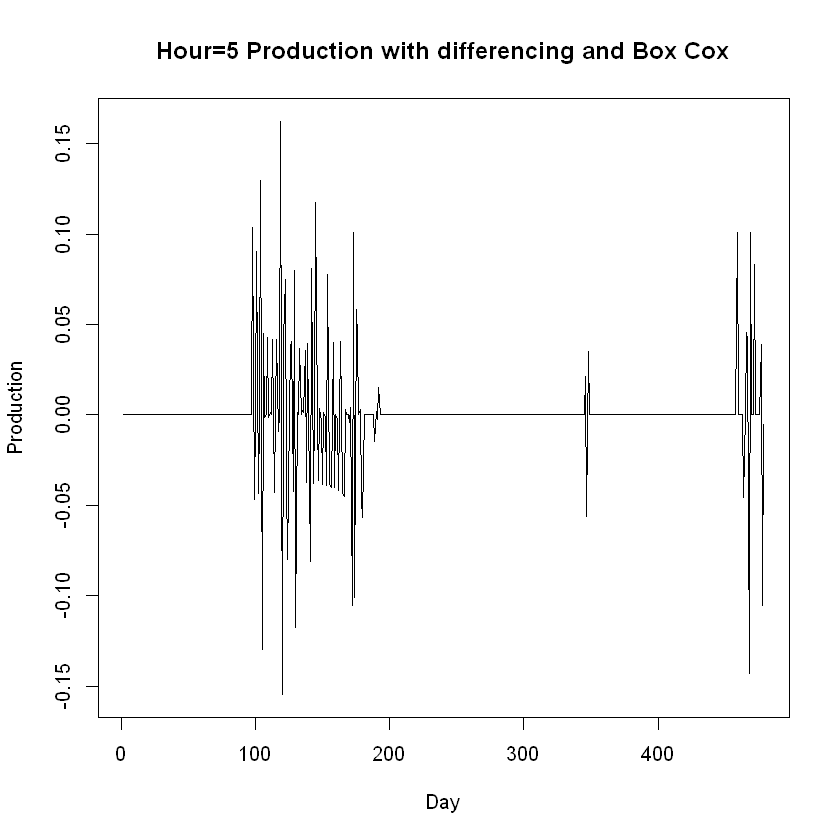


	Ljung-Box test

data:  Residuals from ARIMA(1,0,5) with zero mean
Q* = 29.506, df = 4, p-value = 6.169e-06

Model df: 6.   Total lags used: 10



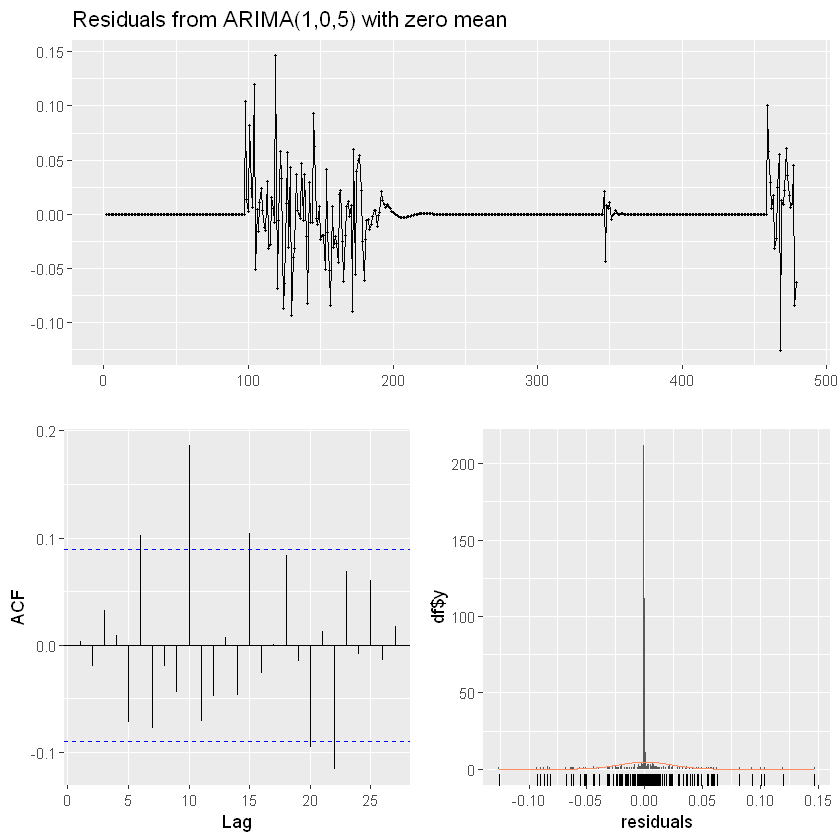

date,hour,production,arima,actual,residual
2022-05-27,0,NA,0.000000,NA,NA
2022-05-27,1,NA,0.000000,NA,NA
2022-05-27,2,NA,0.000000,NA,NA
2022-05-27,3,NA,0.000000,NA,NA
2022-05-27,4,NA,0.000000,NA,NA
2022-05-27,5,NA,1.020527,NA,NA
2022-05-27,6,NA,NA,NA,NA
2022-05-27,7,NA,NA,NA,NA
2022-05-27,8,NA,NA,NA,NA
2022-05-27,9,NA,NA,NA,NA


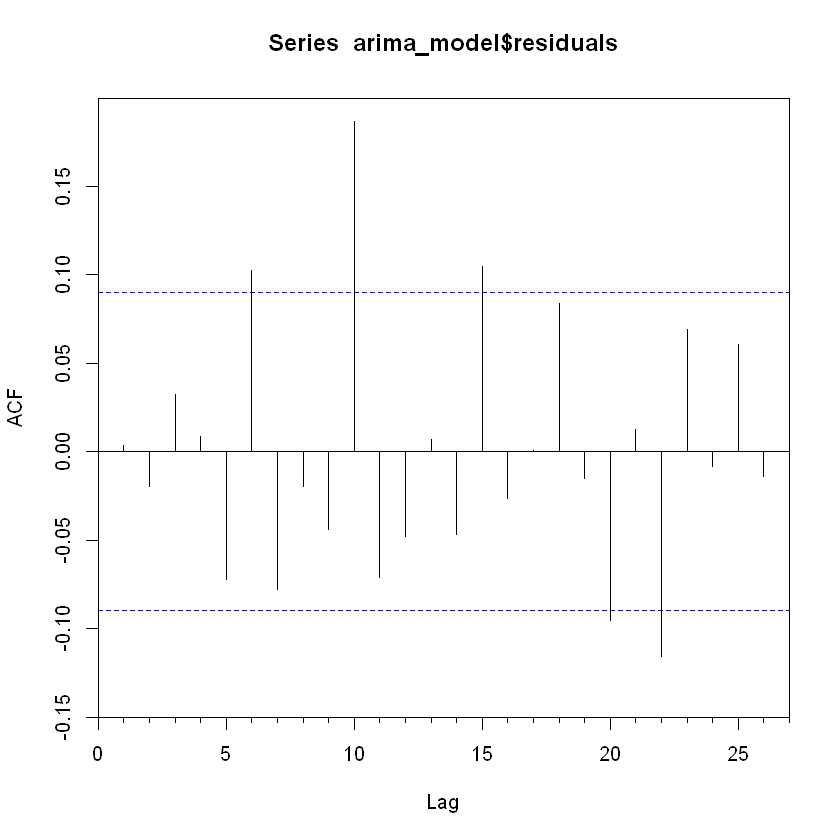


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.6632 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0867 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0532 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


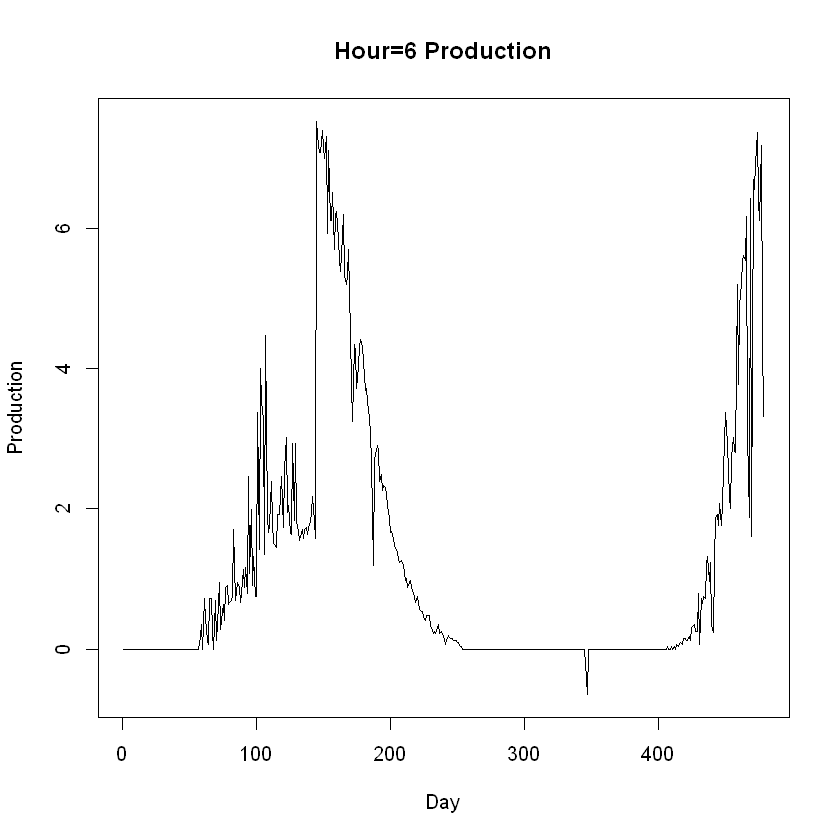


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 879.6097
 ARIMA(0,0,0) with non-zero mean : 994.1991
 ARIMA(1,0,0) with non-zero mean : 882.6103
 ARIMA(0,0,1) with non-zero mean : 885.2647
 ARIMA(0,0,0) with zero mean     : 992.2317
 ARIMA(1,0,2) with non-zero mean : 878.7941
 ARIMA(0,0,2) with non-zero mean : 875.8402
 ARIMA(0,0,3) with non-zero mean : 877.6653
 ARIMA(1,0,1) with non-zero mean : 878.6342
 ARIMA(1,0,3) with non-zero mean : 880.5977
 ARIMA(0,0,2) with zero mean     : 873.983
 ARIMA(0,0,1) with zero mean     : 883.6088
 ARIMA(1,0,2) with zero mean     : 876.9366
 ARIMA(0,0,3) with zero mean     : 875.8214
 ARIMA(1,0,1) with zero mean     : 876.8531
 ARIMA(1,0,3) with zero mean     : 878.7161

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,2) with zero mean     : 874.259

 Best model: ARIMA(0,0,2) with zero mean     



Series: diff_series 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.5112  0.1844
s.e.   0.0448  0.0520

sigma^2 estimated as 0.3613:  log likelihood=-434.1
AIC=874.21   AICc=874.26   BIC=886.72

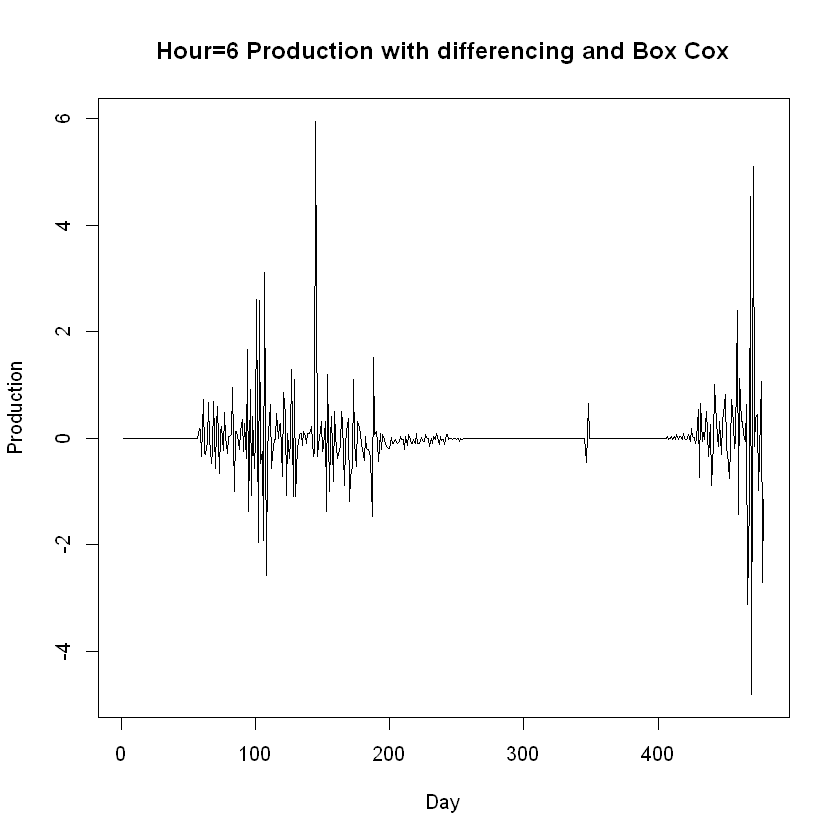


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 8.9528, df = 8, p-value = 0.3463

Model df: 2.   Total lags used: 10



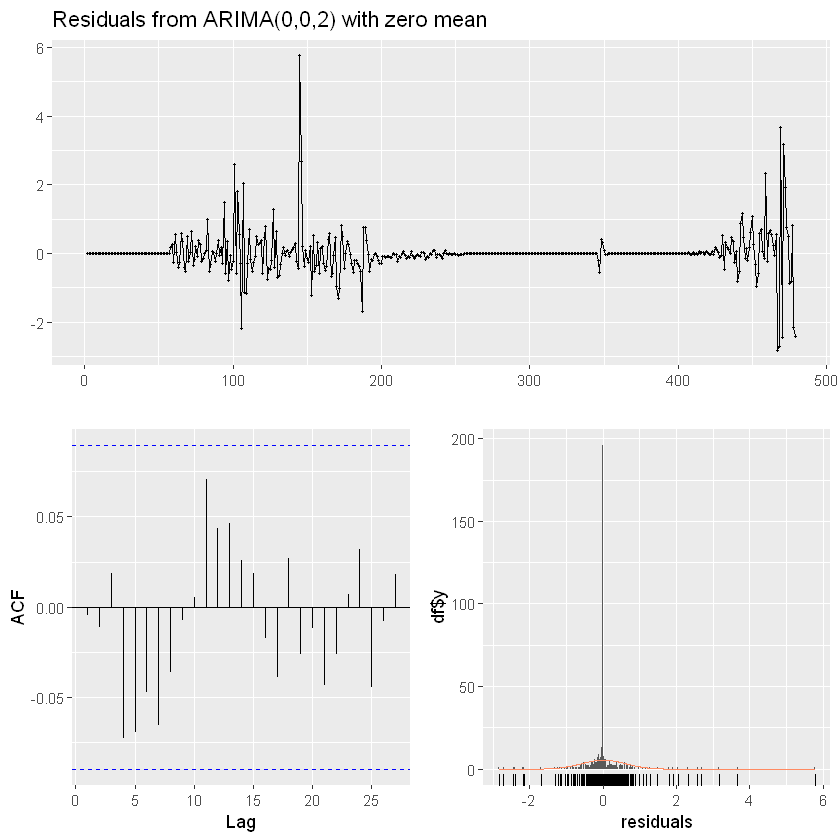

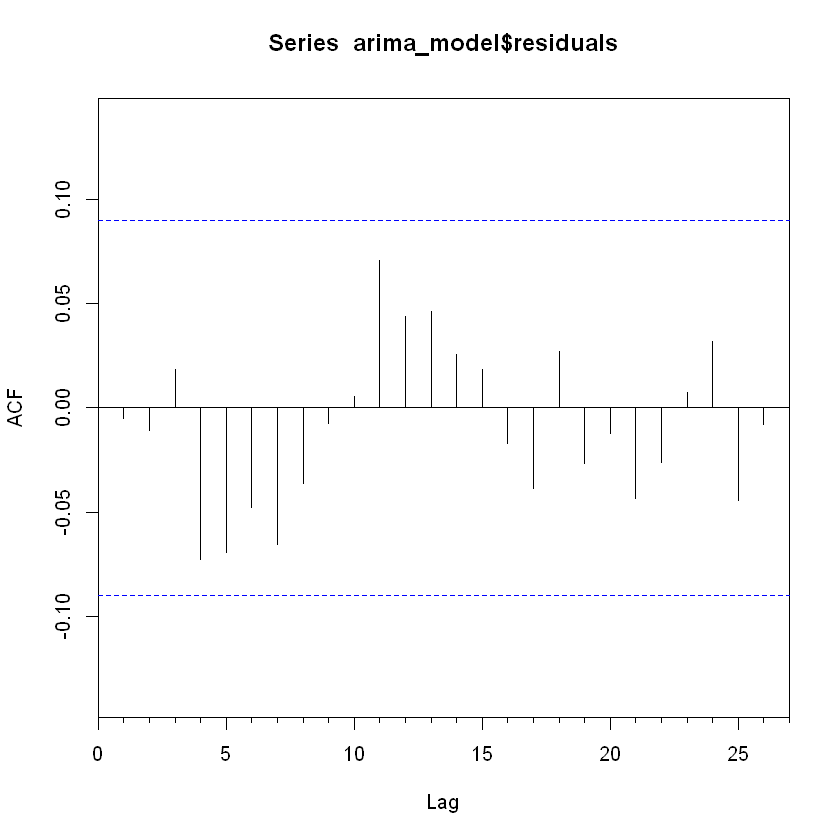


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0604 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.8938 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0991 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


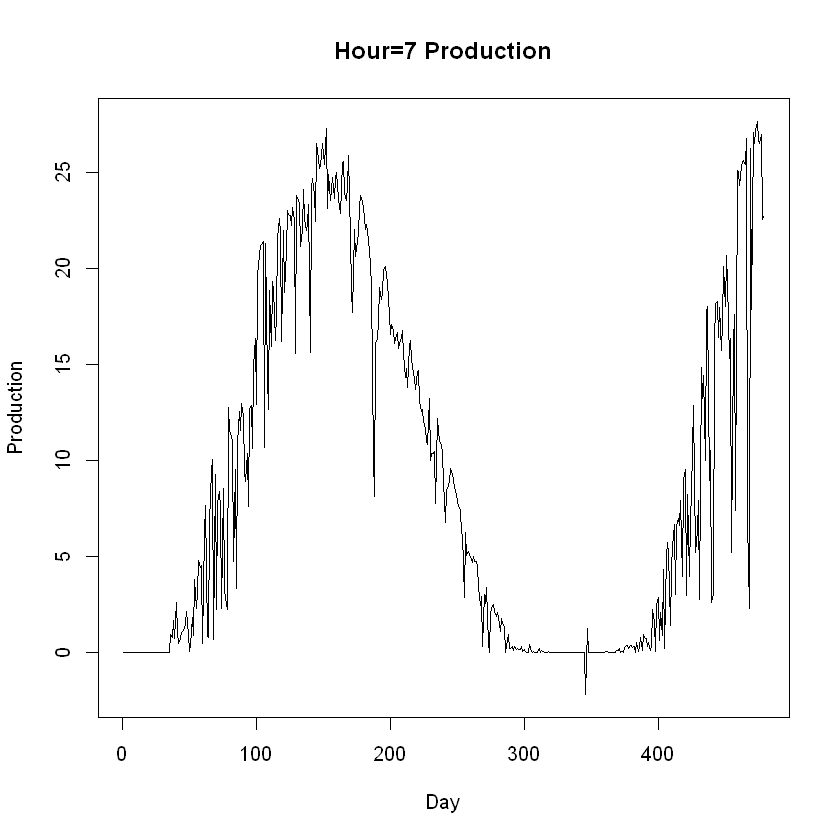


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 2348.292
 ARIMA(0,0,0) with non-zero mean : 2467.028
 ARIMA(1,0,0) with non-zero mean : 2396.369
 ARIMA(0,0,1) with non-zero mean : 2354.749
 ARIMA(0,0,0) with zero mean     : 2465.118
 ARIMA(1,0,2) with non-zero mean : 2345.312
 ARIMA(0,0,2) with non-zero mean : 2345.934
 ARIMA(1,0,1) with non-zero mean : 2344.576
 ARIMA(2,0,1) with non-zero mean : 2346.382
 ARIMA(2,0,0) with non-zero mean : 2370.576
 ARIMA(1,0,1) with zero mean     : 2344.463
 ARIMA(0,0,1) with zero mean     : 2353.713
 ARIMA(1,0,0) with zero mean     : 2394.579
 ARIMA(2,0,1) with zero mean     : 2346.266
 ARIMA(1,0,2) with zero mean     : 2345.179
 ARIMA(0,0,2) with zero mean     : 2345.677
 ARIMA(2,0,0) with zero mean     : 2368.949
 ARIMA(2,0,2) with zero mean     : 2348.155

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 2344.031

 Best model: ARIMA(1,0,1) with zero mean

Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.2491  -0.7793
s.e.  0.0615   0.0368

sigma^2 estimated as 7.817:  log likelihood=-1168.99
AIC=2343.98   AICc=2344.03   BIC=2356.49

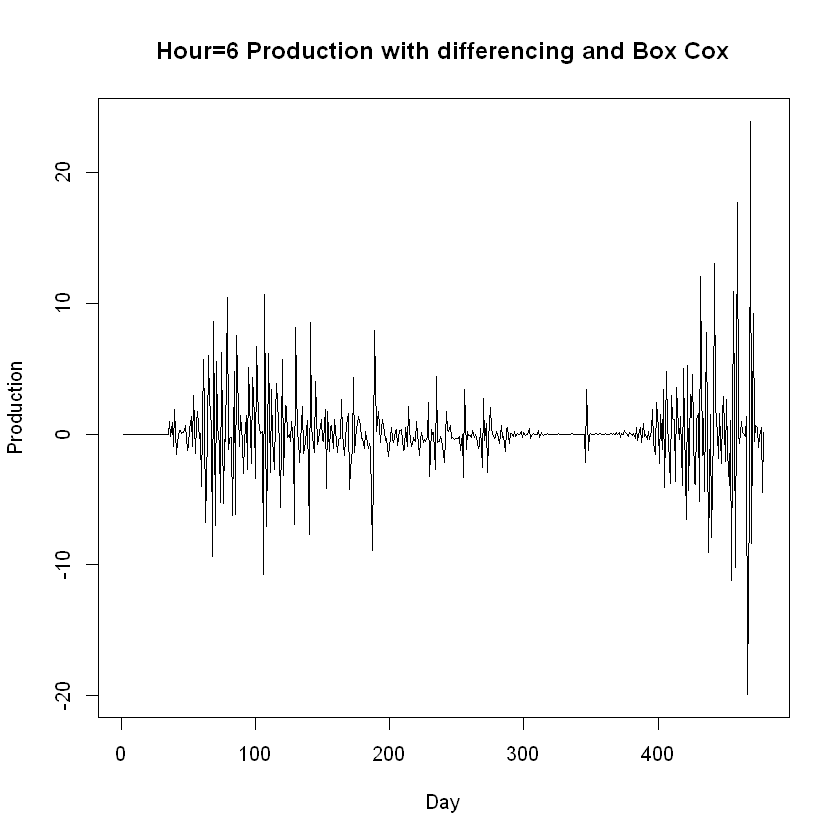


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 27.241, df = 8, p-value = 0.0006424

Model df: 2.   Total lags used: 10



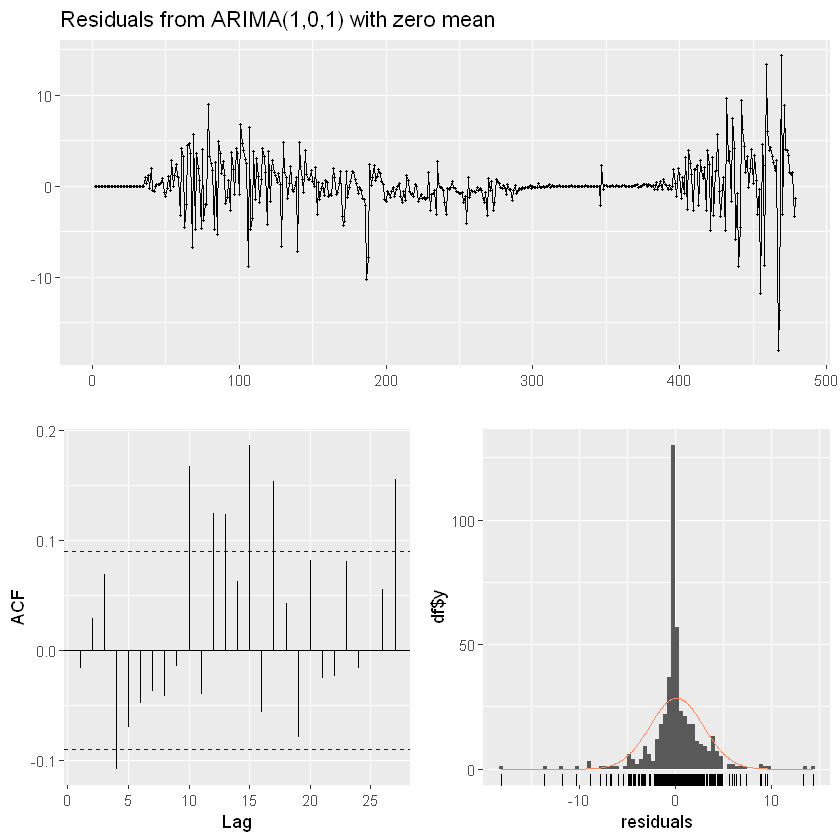

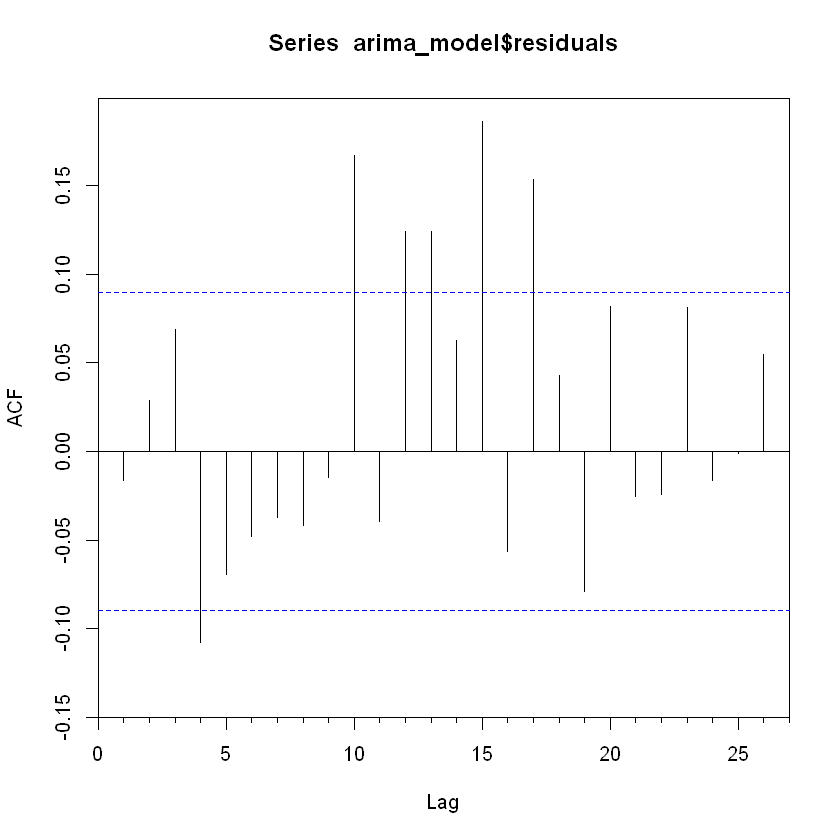


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0115 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.9987 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0591 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


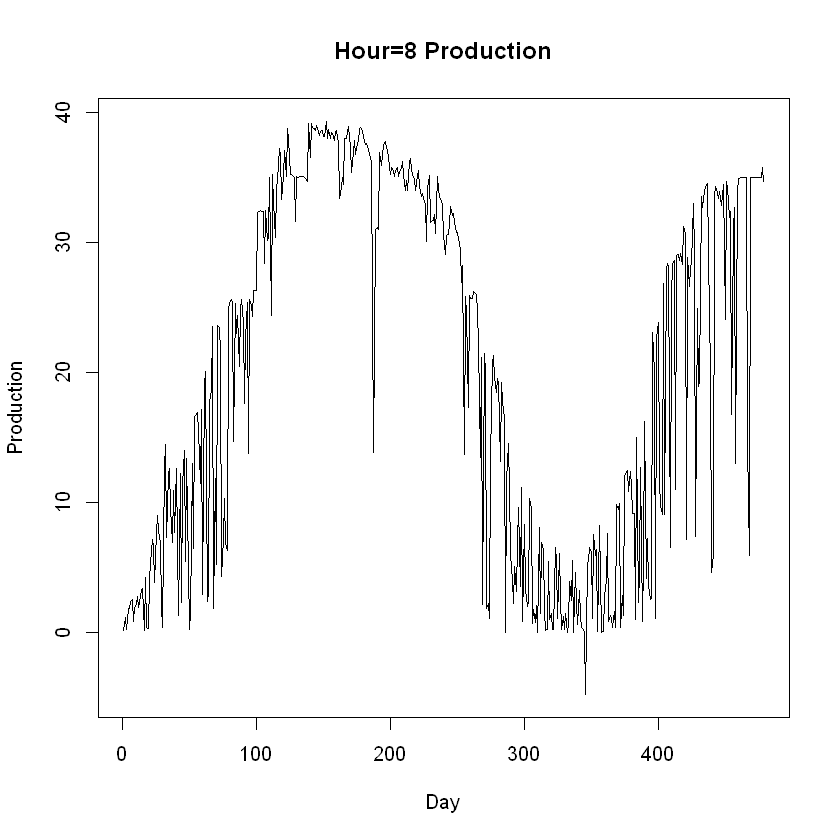


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3016.322
 ARIMA(0,0,0) with non-zero mean : 3165.882
 ARIMA(1,0,0) with non-zero mean : 3097.391
 ARIMA(0,0,1) with non-zero mean : 3021.918
 ARIMA(0,0,0) with zero mean     : 3163.923
 ARIMA(1,0,2) with non-zero mean : 3013.341
 ARIMA(0,0,2) with non-zero mean : 3010.473
 ARIMA(0,0,3) with non-zero mean : 3012.456
 ARIMA(1,0,1) with non-zero mean : 3011.463
 ARIMA(1,0,3) with non-zero mean : Inf
 ARIMA(0,0,2) with zero mean     : 3009.887
 ARIMA(0,0,1) with zero mean     : 3020.963
 ARIMA(1,0,2) with zero mean     : 3012.714
 ARIMA(0,0,3) with zero mean     : 3011.873
 ARIMA(1,0,1) with zero mean     : 3010.848
 ARIMA(1,0,3) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,2) with zero mean     : 3010.601

 Best model: ARIMA(0,0,2) with zero mean     



Series: diff_series 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1      ma2
      -0.6089  -0.1598
s.e.   0.0449   0.0433

sigma^2 estimated as 31.51:  log likelihood=-1502.28
AIC=3010.55   AICc=3010.6   BIC=3023.06

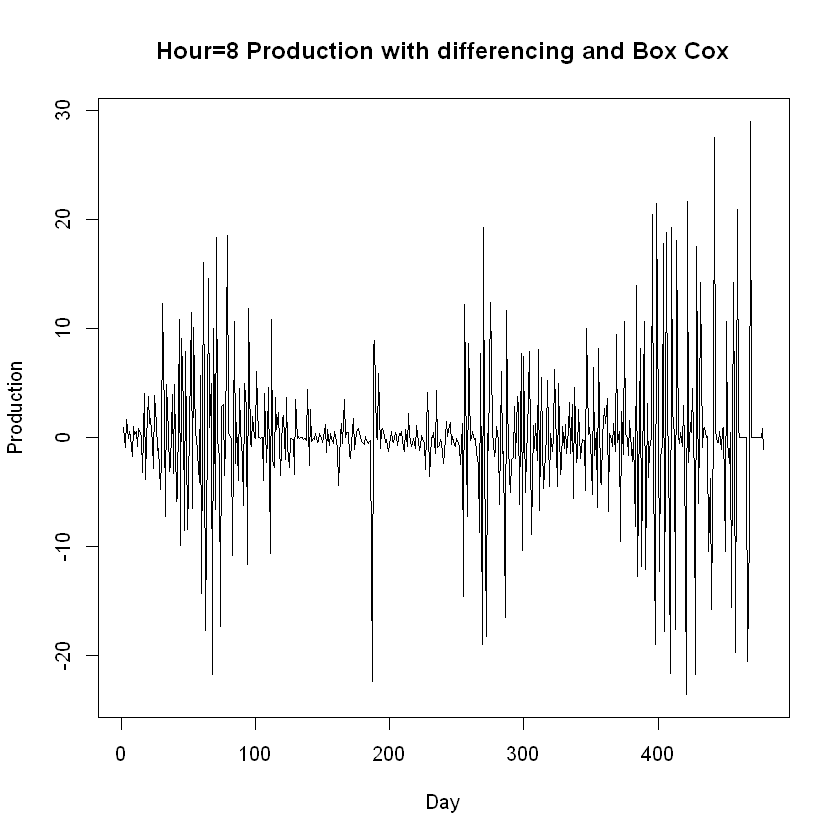


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 7.6165, df = 8, p-value = 0.4718

Model df: 2.   Total lags used: 10



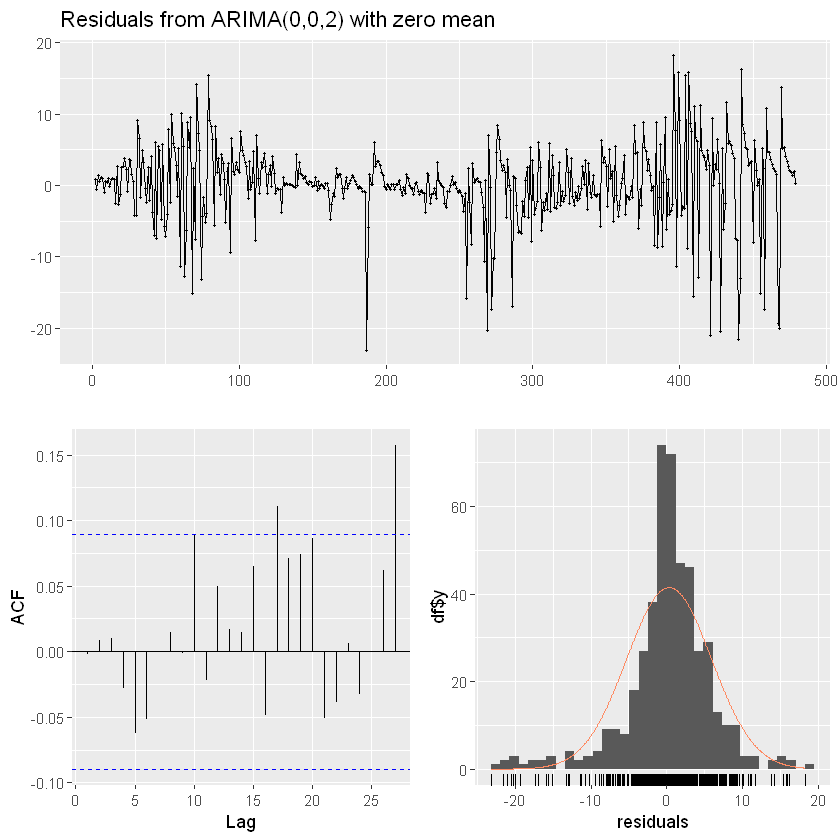

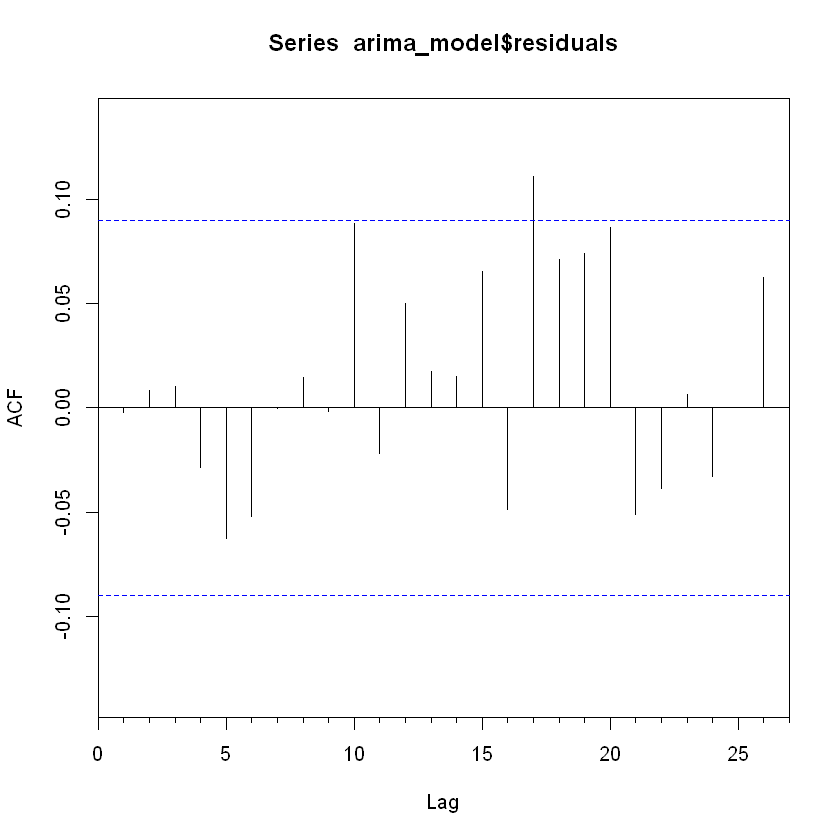


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.9864 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.7989 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0299 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


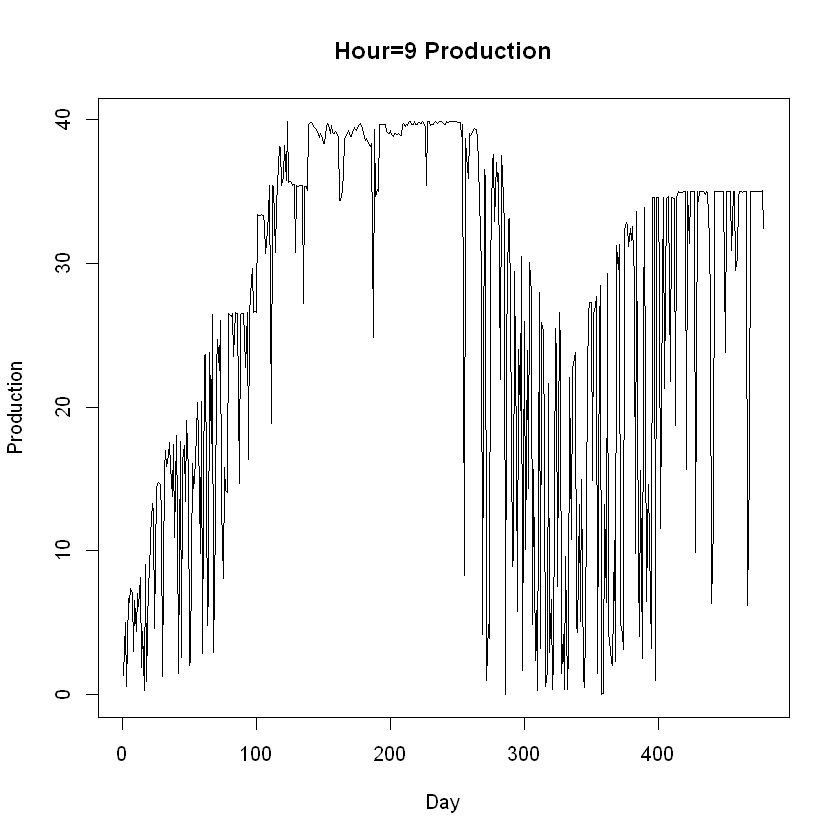


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3358.144
 ARIMA(0,0,0) with non-zero mean : 3538.521
 ARIMA(1,0,0) with non-zero mean : 3462.538
 ARIMA(0,0,1) with non-zero mean : 3364.924
 ARIMA(0,0,0) with zero mean     : 3536.525
 ARIMA(1,0,2) with non-zero mean : 3355.836
 ARIMA(0,0,2) with non-zero mean : 3353.75
 ARIMA(0,0,3) with non-zero mean : 3355.582
 ARIMA(1,0,1) with non-zero mean : 3353.862
 ARIMA(1,0,3) with non-zero mean : 3357.767
 ARIMA(0,0,2) with zero mean     : 3352.934
 ARIMA(0,0,1) with zero mean     : 3363.765
 ARIMA(1,0,2) with zero mean     : 3354.896
 ARIMA(0,0,3) with zero mean     : 3354.783
 ARIMA(1,0,1) with zero mean     : 3352.926
 ARIMA(1,0,0) with zero mean     : 3460.555
 ARIMA(2,0,1) with zero mean     : 3357.627
 ARIMA(2,0,0) with zero mean     : 3421.017
 ARIMA(2,0,2) with zero mean     : 3357.256

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 3353.34

Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.1952  -0.8755
s.e.  0.0524   0.0235

sigma^2 estimated as 64.5:  log likelihood=-1673.65
AIC=3353.29   AICc=3353.34   BIC=3365.8

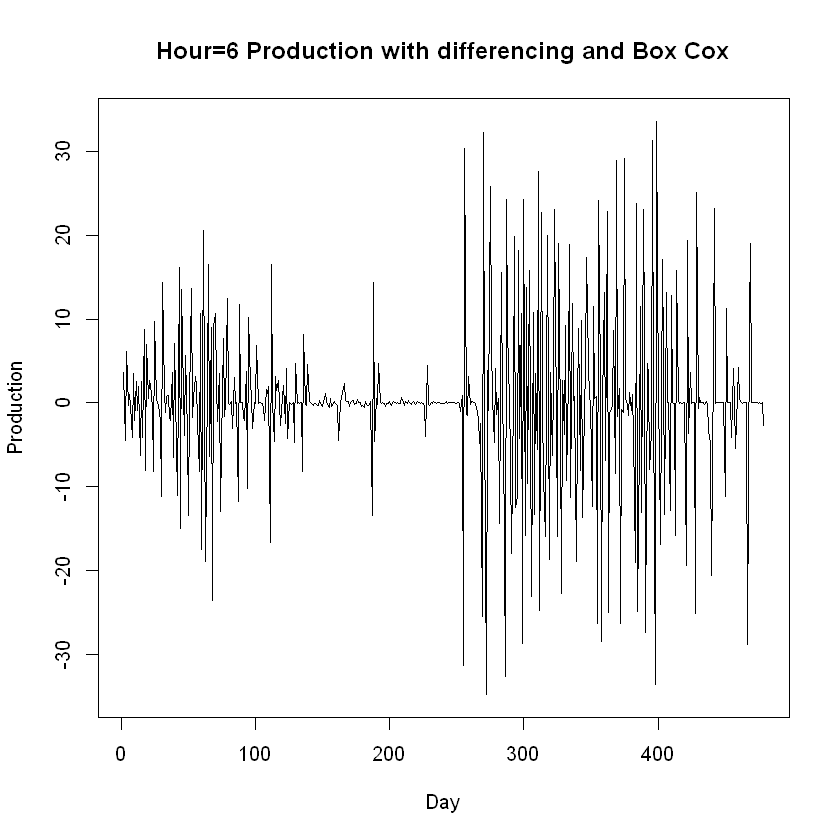


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 6.719, df = 8, p-value = 0.5672

Model df: 2.   Total lags used: 10



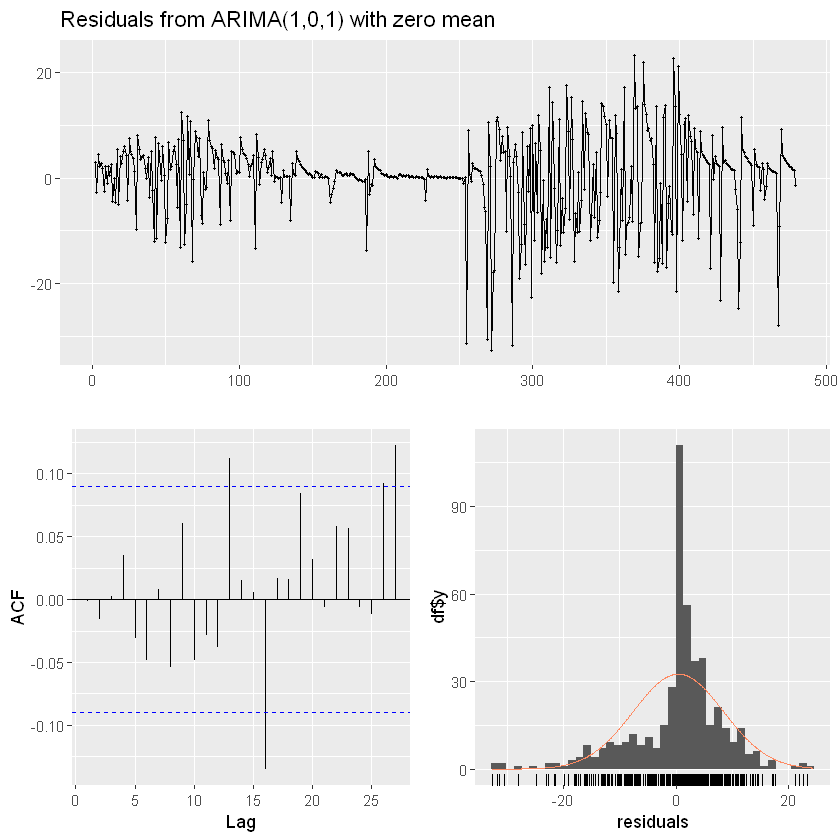

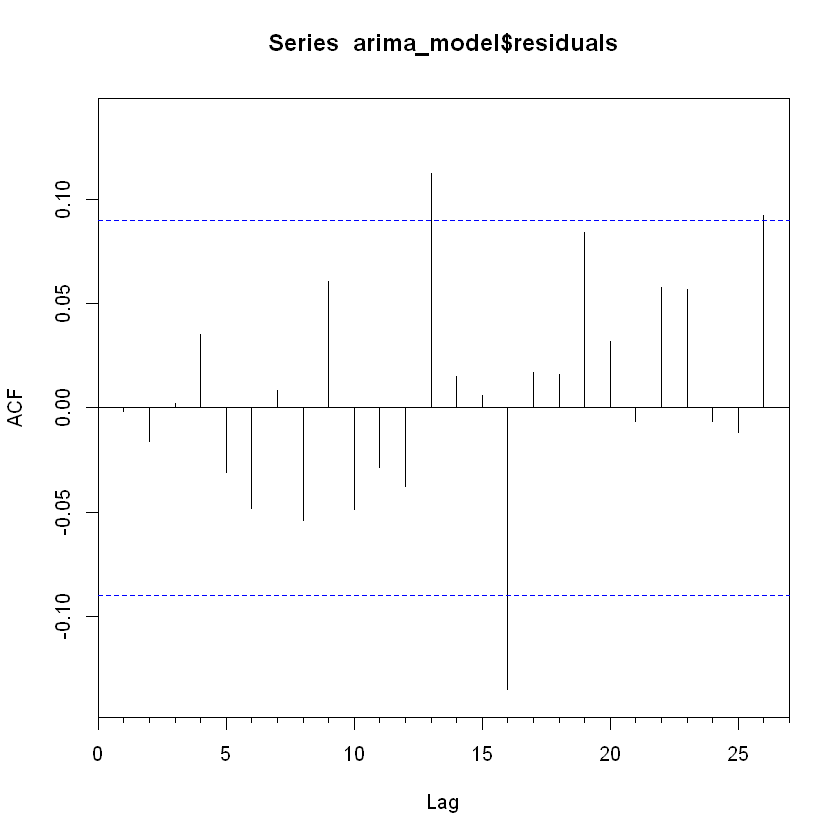


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.1736 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.0019 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0304 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


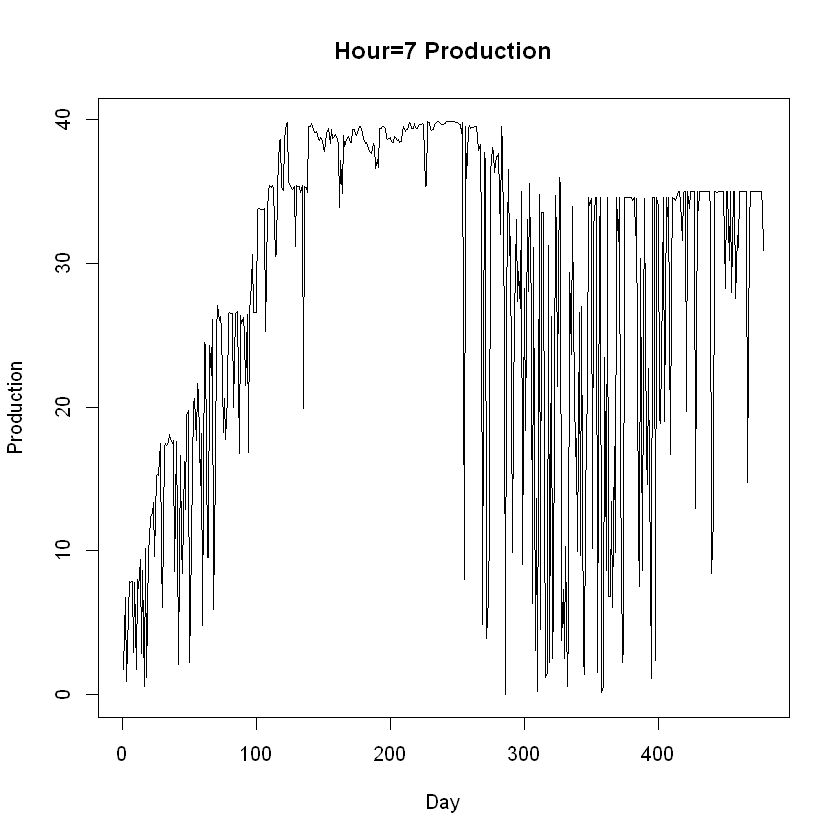


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3367.304
 ARIMA(0,0,0) with non-zero mean : 3566.064
 ARIMA(1,0,0) with non-zero mean : 3479.732
 ARIMA(0,0,1) with non-zero mean : 3370.269
 ARIMA(0,0,0) with zero mean     : 3564.065
 ARIMA(1,0,2) with non-zero mean : 3363.785
 ARIMA(0,0,2) with non-zero mean : 3362.117
 ARIMA(0,0,3) with non-zero mean : 3363.89
 ARIMA(1,0,1) with non-zero mean : 3361.76
 ARIMA(2,0,1) with non-zero mean : 3366.99
 ARIMA(2,0,0) with non-zero mean : 3440.879
 ARIMA(1,0,1) with zero mean     : 3361.166
 ARIMA(0,0,1) with zero mean     : 3369.574
 ARIMA(1,0,0) with zero mean     : 3477.742
 ARIMA(2,0,1) with zero mean     : 3366.614
 ARIMA(1,0,2) with zero mean     : 3363.19
 ARIMA(0,0,2) with zero mean     : 3361.736
 ARIMA(2,0,0) with zero mean     : 3438.925
 ARIMA(2,0,2) with zero mean     : 3366.875

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 3361.809



Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.1653  -0.8914
s.e.  0.0508   0.0207

sigma^2 estimated as 65.63:  log likelihood=-1677.88
AIC=3361.76   AICc=3361.81   BIC=3374.27

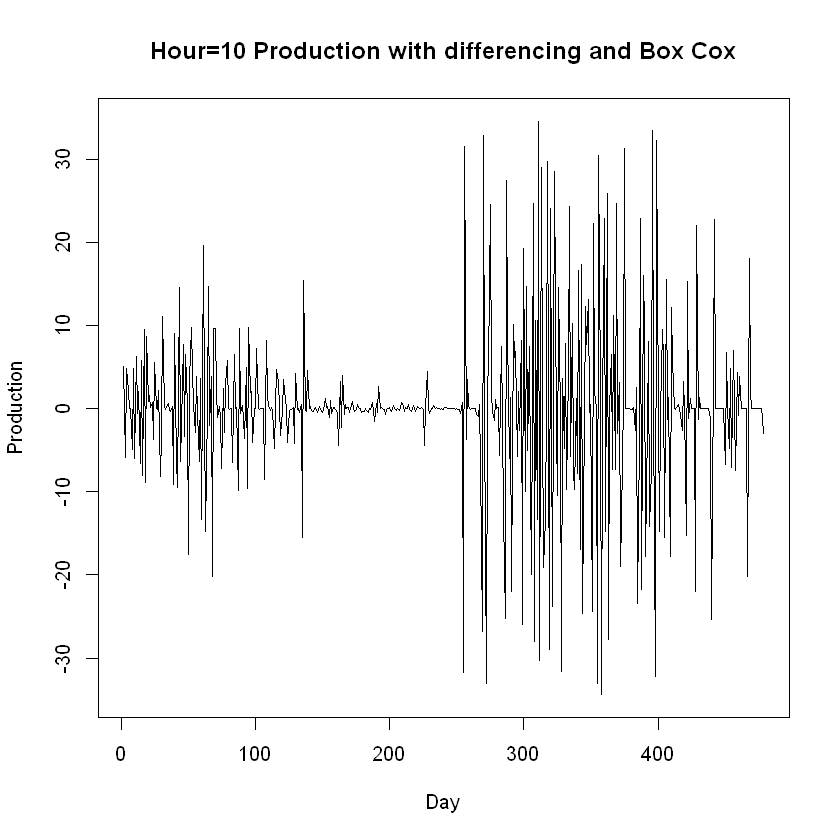


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 15.692, df = 8, p-value = 0.04701

Model df: 2.   Total lags used: 10



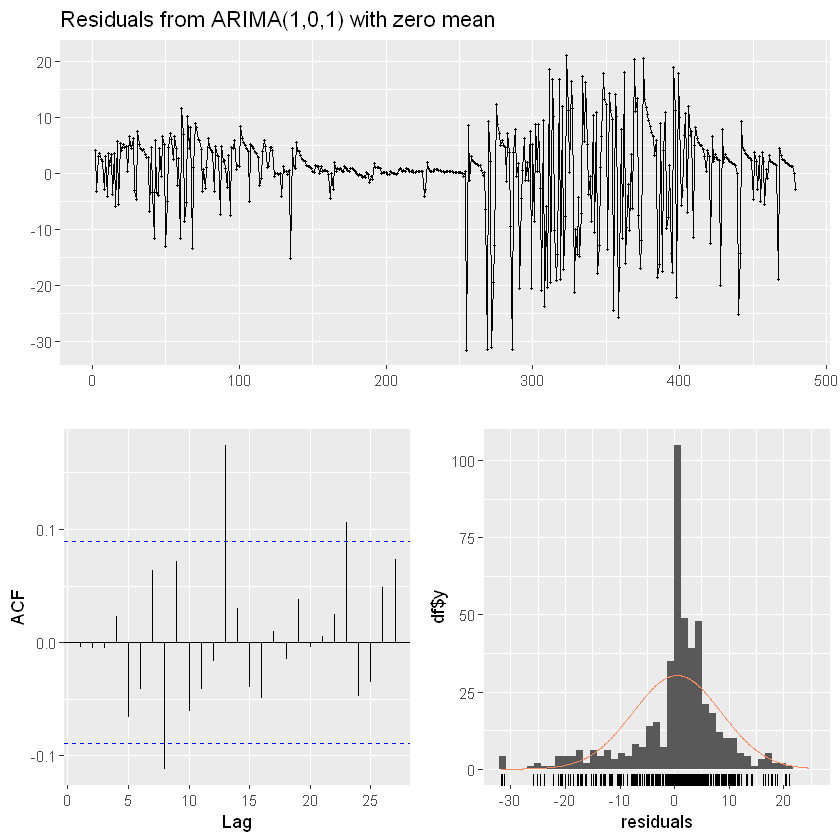

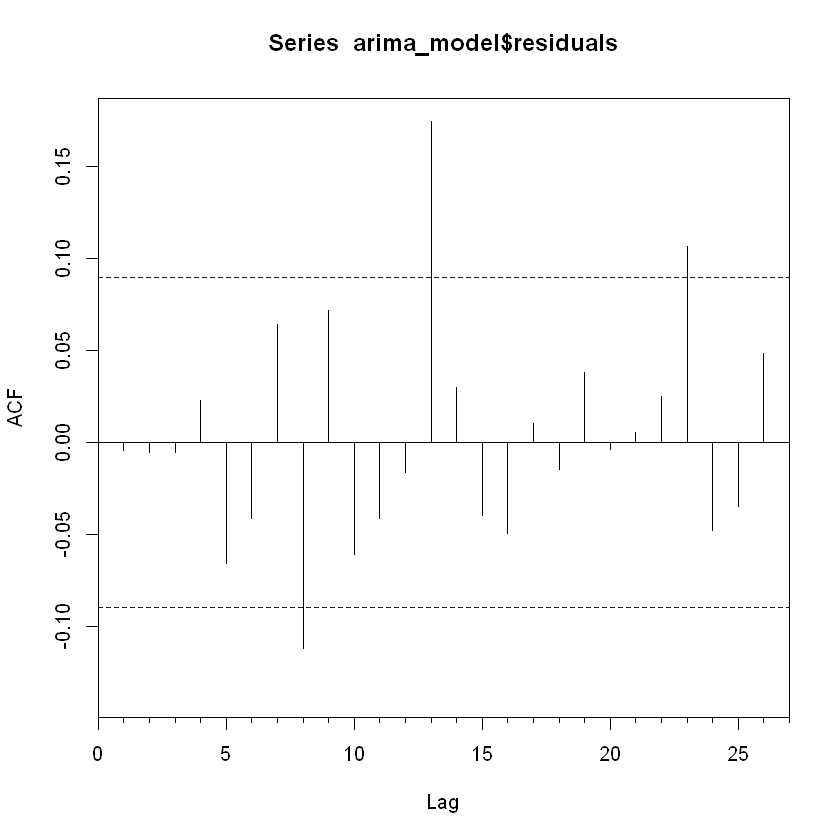


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2598 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2377 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0313 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


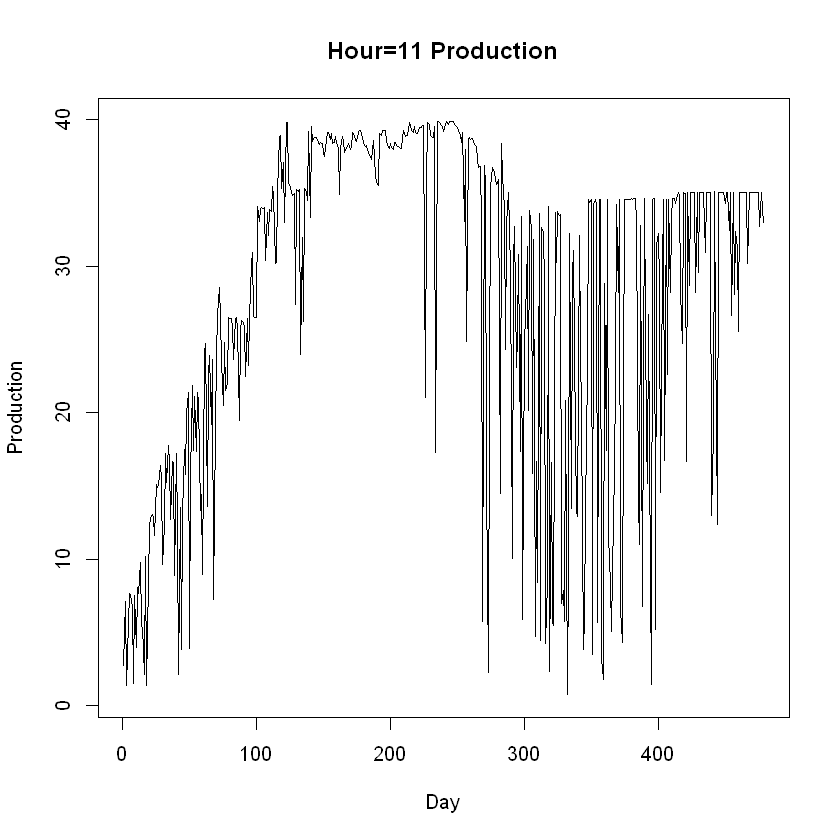


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3281.327
 ARIMA(0,0,0) with non-zero mean : 3491.719
 ARIMA(1,0,0) with non-zero mean : 3400.791
 ARIMA(0,0,1) with non-zero mean : 3279.663
 ARIMA(0,0,0) with zero mean     : 3489.724
 ARIMA(1,0,1) with non-zero mean : 3276.03
 ARIMA(2,0,1) with non-zero mean : 3280.698
 ARIMA(1,0,2) with non-zero mean : 3277.685
 ARIMA(0,0,2) with non-zero mean : 3275.503
 ARIMA(0,0,3) with non-zero mean : 3277.51
 ARIMA(1,0,3) with non-zero mean : 3279.67
 ARIMA(0,0,2) with zero mean     : 3275.327
 ARIMA(0,0,1) with zero mean     : 3279.172
 ARIMA(1,0,2) with zero mean     : 3277.314
 ARIMA(0,0,3) with zero mean     : 3277.307
 ARIMA(1,0,1) with zero mean     : 3275.649
 ARIMA(1,0,3) with zero mean     : 3279.33

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,2) with zero mean     : 3275.927

 Best model: ARIMA(0,0,2) with zero mean     



Series: diff_series 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1      ma2
      -0.7510  -0.1118
s.e.   0.0459   0.0451

sigma^2 estimated as 54.84:  log likelihood=-1634.94
AIC=3275.88   AICc=3275.93   BIC=3288.39

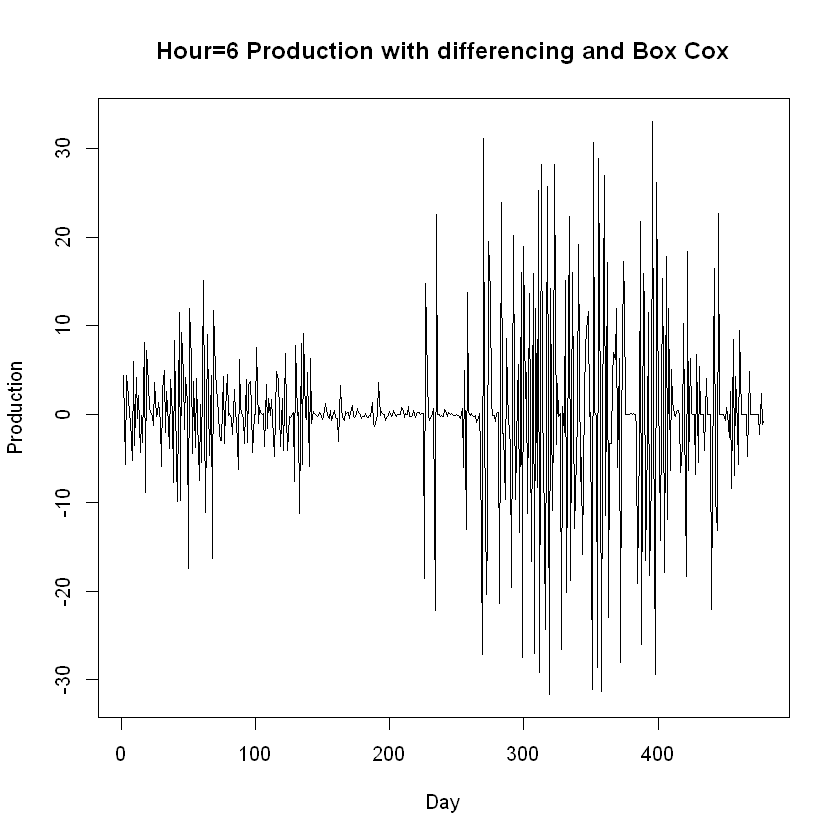


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 15.081, df = 8, p-value = 0.05758

Model df: 2.   Total lags used: 10



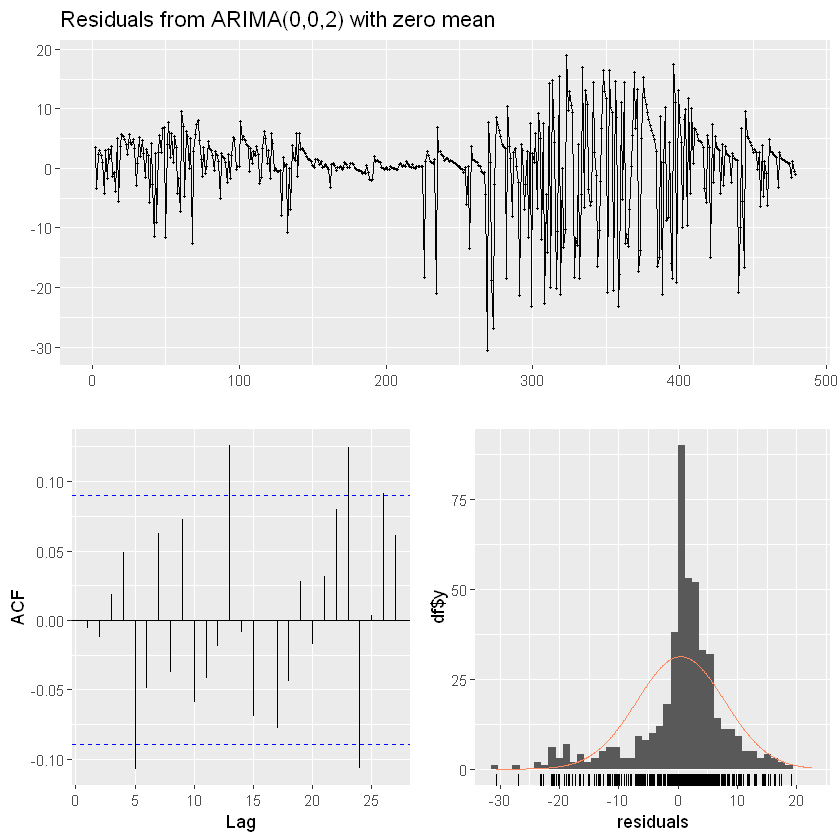

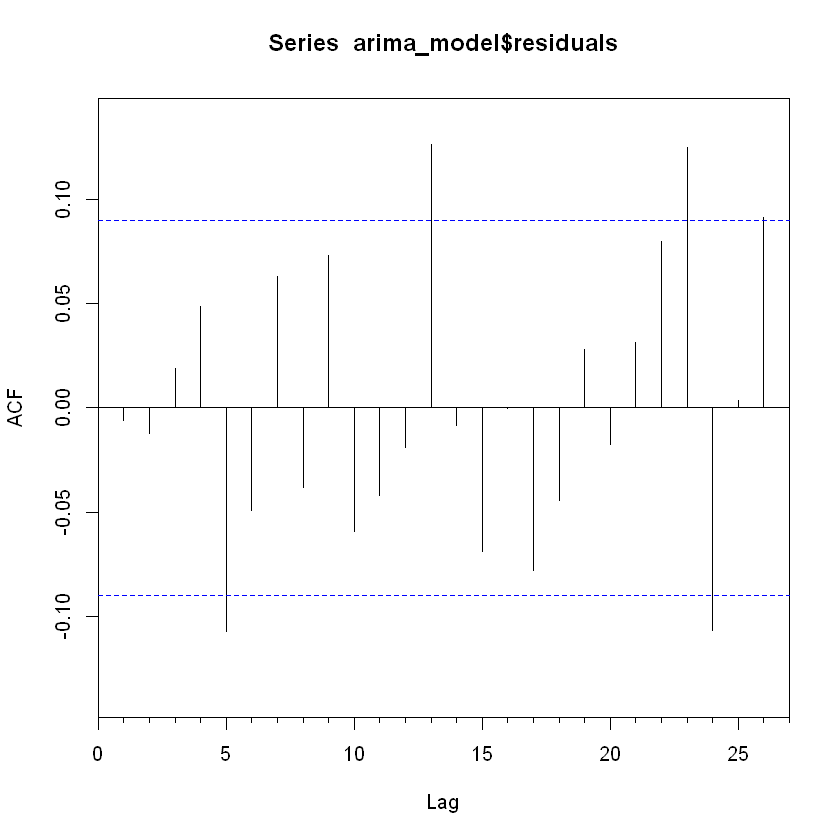


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2505 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.234 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0343 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


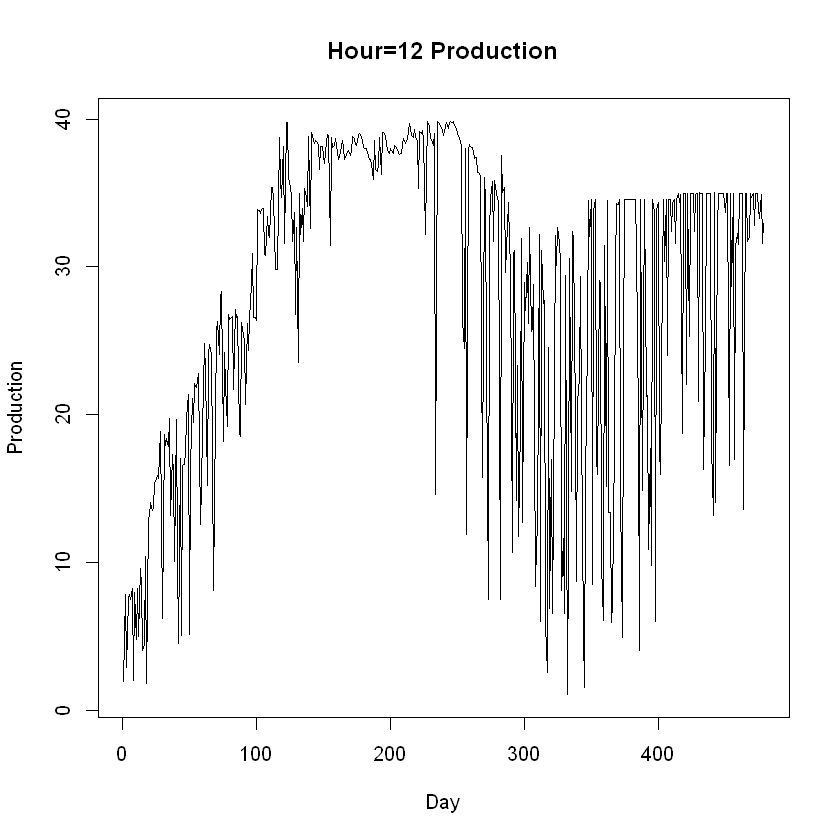


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3230.04
 ARIMA(0,0,0) with non-zero mean : 3438.608
 ARIMA(1,0,0) with non-zero mean : 3341.695
 ARIMA(0,0,1) with non-zero mean : 3230.772
 ARIMA(0,0,0) with zero mean     : 3436.617
 ARIMA(1,0,2) with non-zero mean : 3227.166
 ARIMA(0,0,2) with non-zero mean : 3226.208
 ARIMA(0,0,3) with non-zero mean : 3227.911
 ARIMA(1,0,1) with non-zero mean : 3225.124
 ARIMA(2,0,1) with non-zero mean : 3229.646
 ARIMA(2,0,0) with non-zero mean : 3303.526
 ARIMA(1,0,1) with zero mean     : 3224.734
 ARIMA(0,0,1) with zero mean     : 3230.357
 ARIMA(1,0,0) with zero mean     : 3339.718
 ARIMA(2,0,1) with zero mean     : 3229.49
 ARIMA(1,0,2) with zero mean     : 3226.768
 ARIMA(0,0,2) with zero mean     : 3226.081
 ARIMA(2,0,0) with zero mean     : 3301.594
 ARIMA(2,0,2) with zero mean     : 3229.783

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 3225.549

Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.1354  -0.8840
s.e.  0.0514   0.0221

sigma^2 estimated as 49.35:  log likelihood=-1609.75
AIC=3225.5   AICc=3225.55   BIC=3238.01

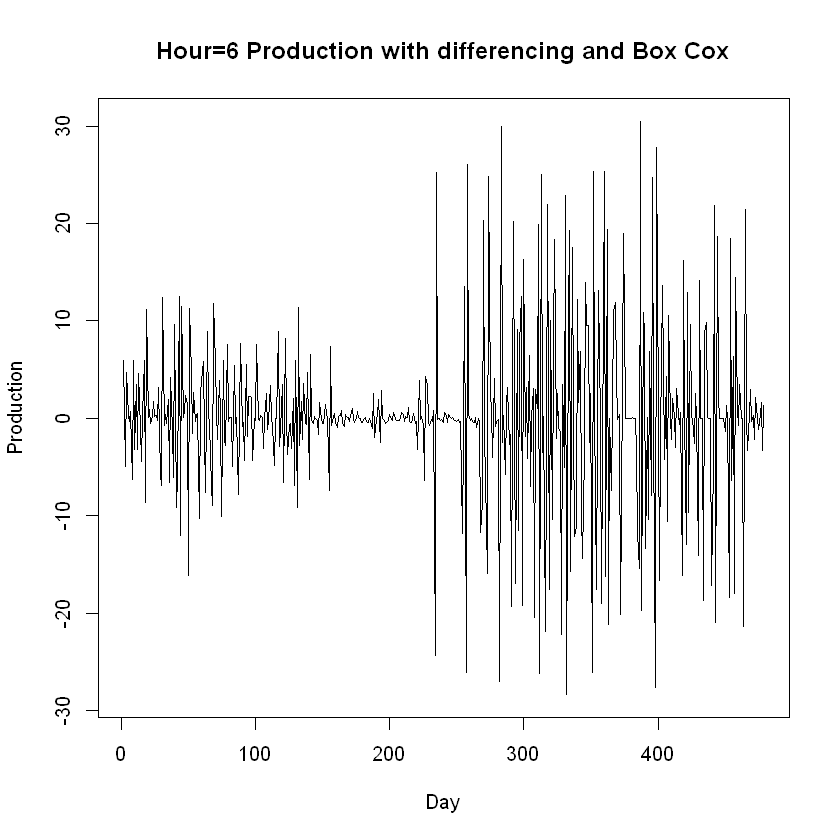


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 11.451, df = 8, p-value = 0.1774

Model df: 2.   Total lags used: 10



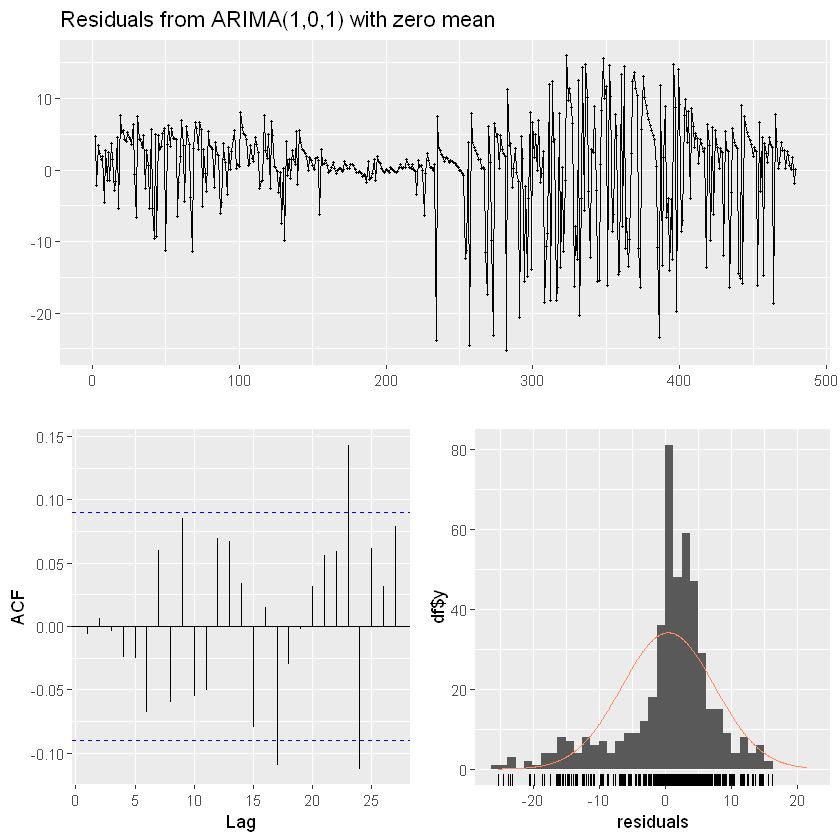

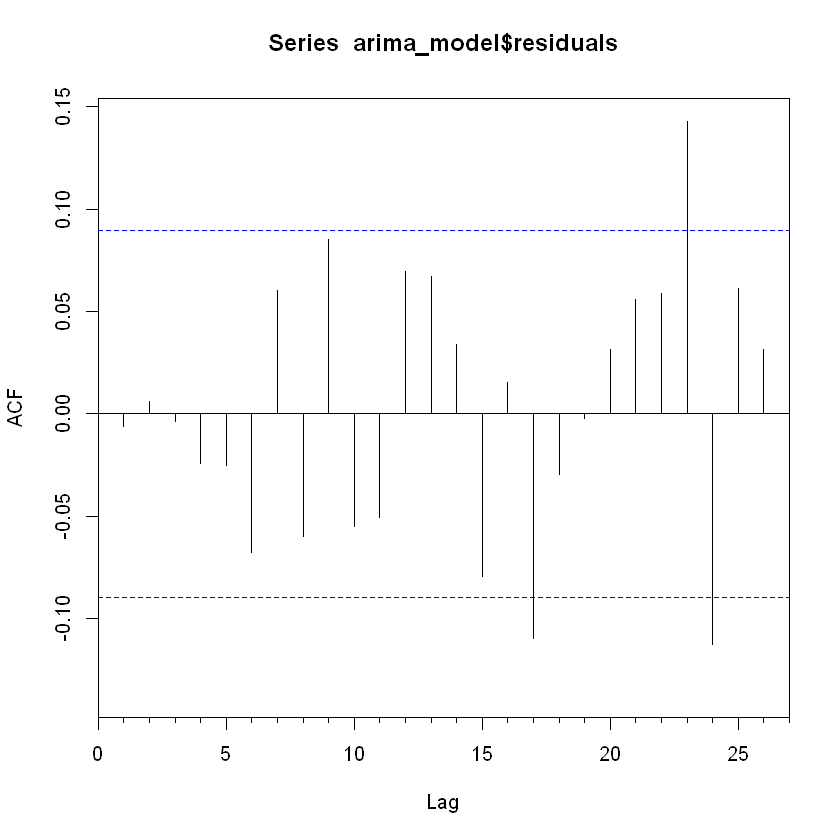


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.3639 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.3545 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0345 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


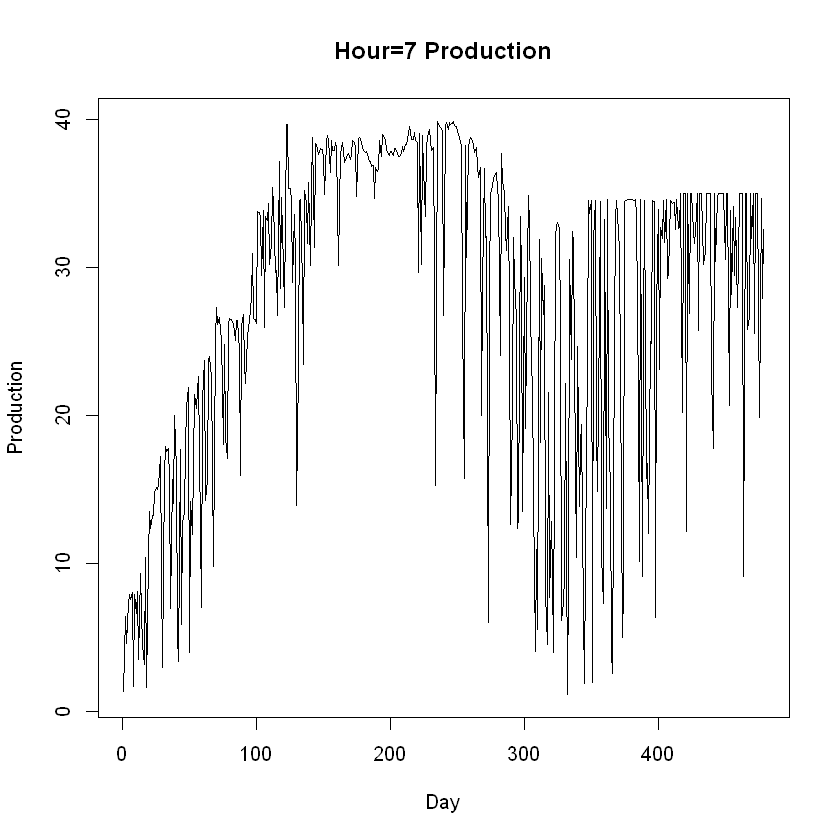


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3208.858
 ARIMA(0,0,0) with non-zero mean : 3384.675
 ARIMA(1,0,0) with non-zero mean : 3324.958
 ARIMA(0,0,1) with non-zero mean : 3228.023
 ARIMA(0,0,0) with zero mean     : 3382.688
 ARIMA(1,0,2) with non-zero mean : 3206.632
 ARIMA(0,0,2) with non-zero mean : 3205.899
 ARIMA(0,0,3) with non-zero mean : 3207.94
 ARIMA(1,0,1) with non-zero mean : 3205.653
 ARIMA(2,0,1) with non-zero mean : 3208.517
 ARIMA(2,0,0) with non-zero mean : 3286.853
 ARIMA(1,0,1) with zero mean     : 3205.06
 ARIMA(0,0,1) with zero mean     : 3227.322
 ARIMA(1,0,0) with zero mean     : 3322.976
 ARIMA(2,0,1) with zero mean     : 3208.083
 ARIMA(1,0,2) with zero mean     : 3206.101
 ARIMA(0,0,2) with zero mean     : 3205.586
 ARIMA(2,0,0) with zero mean     : 3284.903
 ARIMA(2,0,2) with zero mean     : 3208.364

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 3206.069

Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.2397  -0.8995
s.e.  0.0493   0.0181

sigma^2 estimated as 47.39:  log likelihood=-1600.01
AIC=3206.02   AICc=3206.07   BIC=3218.53

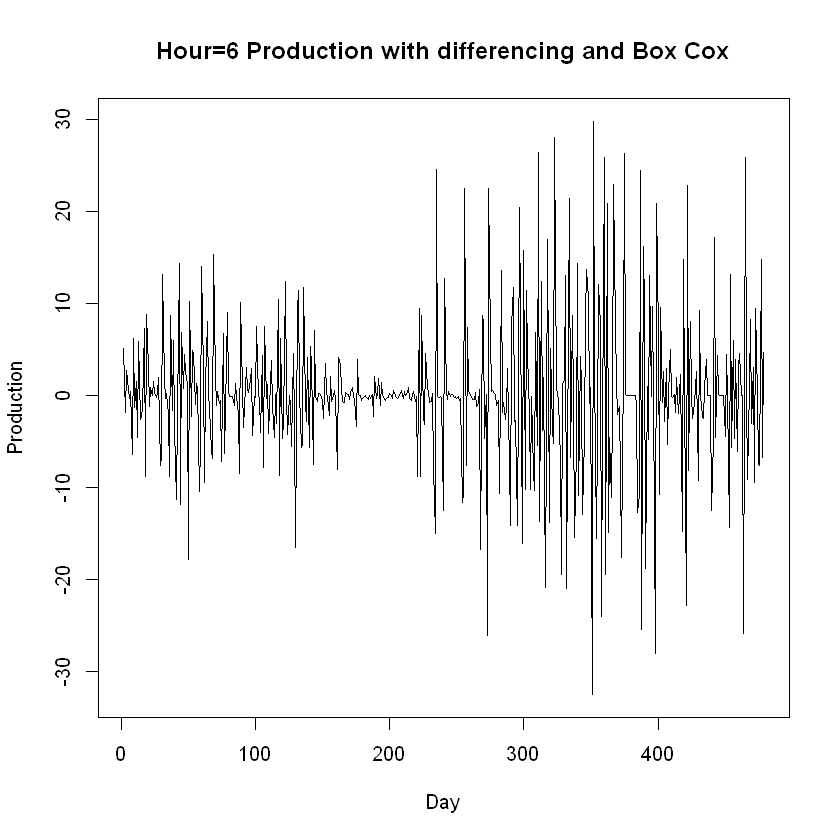


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 5.7039, df = 8, p-value = 0.6804

Model df: 2.   Total lags used: 10



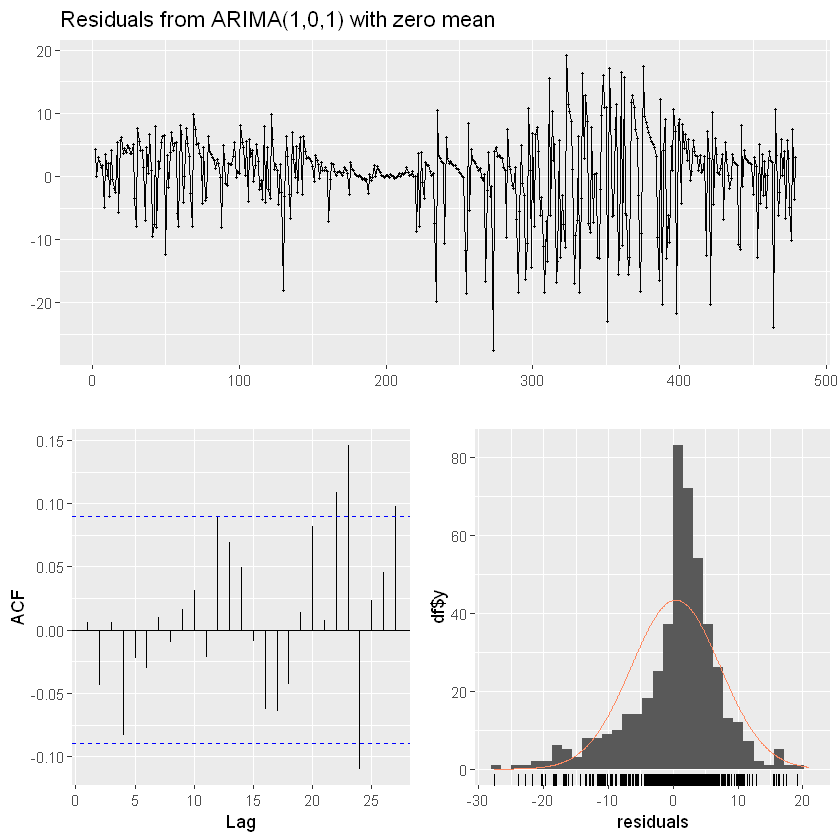

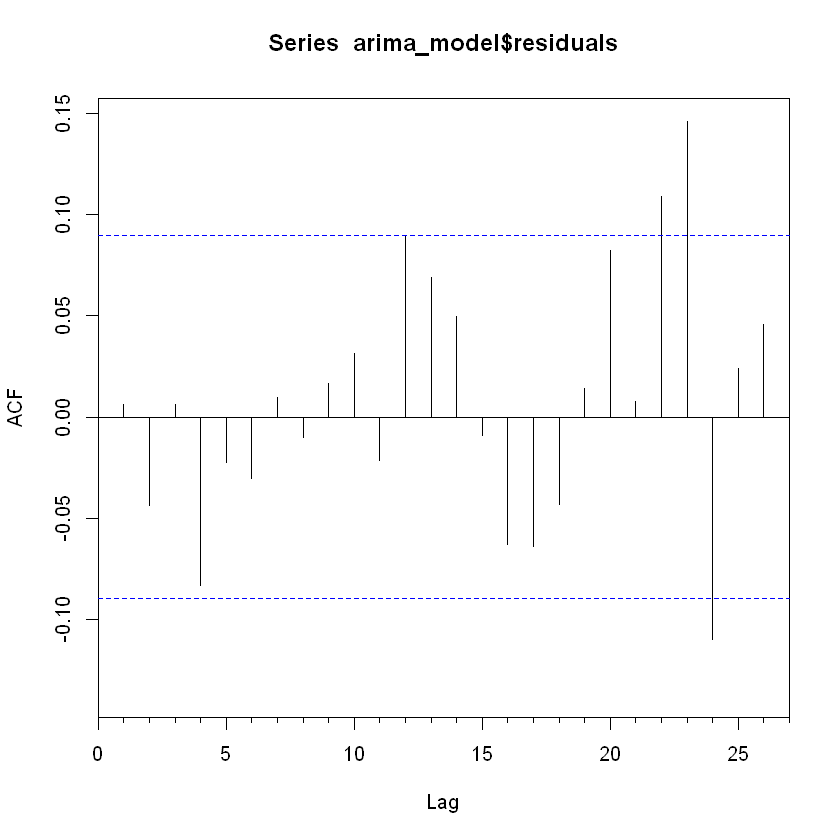


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.1593 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2204 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0254 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


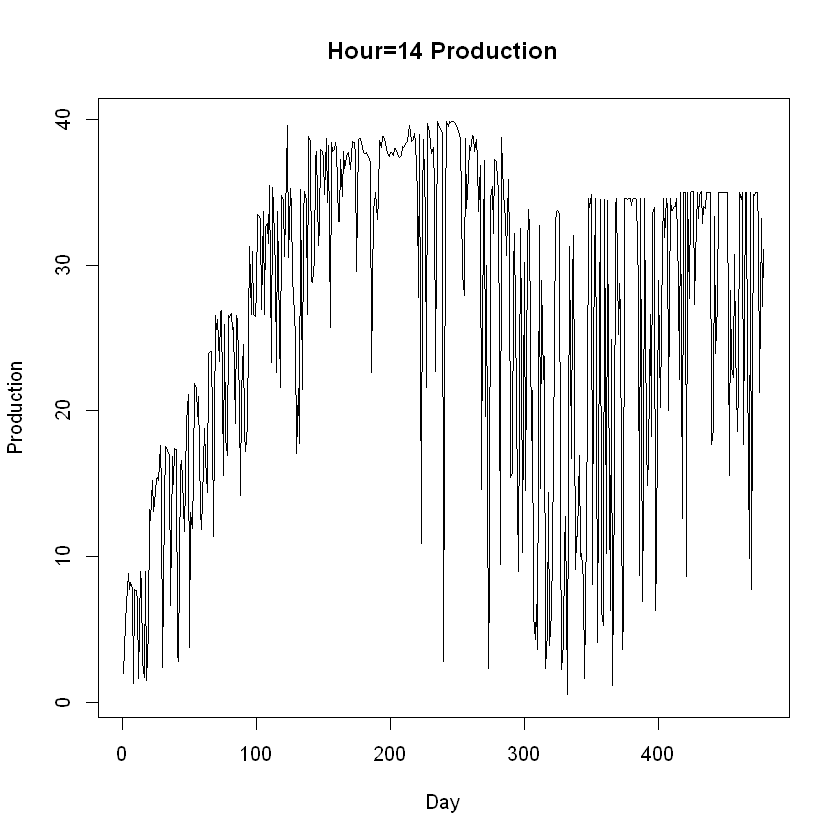


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3338.717
 ARIMA(0,0,0) with non-zero mean : 3526.057
 ARIMA(1,0,0) with non-zero mean : 3447.558
 ARIMA(0,0,1) with non-zero mean : 3352.533
 ARIMA(0,0,0) with zero mean     : 3524.059
 ARIMA(1,0,2) with non-zero mean : 3338.65
 ARIMA(0,0,2) with non-zero mean : 3337.758
 ARIMA(0,0,3) with non-zero mean : 3339.774
 ARIMA(1,0,1) with non-zero mean : 3336.913
 ARIMA(2,0,1) with non-zero mean : 3339.82
 ARIMA(2,0,0) with non-zero mean : 3394.717
 ARIMA(1,0,1) with zero mean     : 3335.993
 ARIMA(0,0,1) with zero mean     : 3351.359
 ARIMA(1,0,0) with zero mean     : 3445.566
 ARIMA(2,0,1) with zero mean     : 3338.856
 ARIMA(1,0,2) with zero mean     : 3337.688
 ARIMA(0,0,2) with zero mean     : 3336.961
 ARIMA(2,0,0) with zero mean     : 3392.747
 ARIMA(2,0,2) with zero mean     : 3337.749

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     : 3336.659

Series: diff_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.2132  -0.9006
s.e.  0.0504   0.0200

sigma^2 estimated as 62.27:  log likelihood=-1665.3
AIC=3336.61   AICc=3336.66   BIC=3349.12

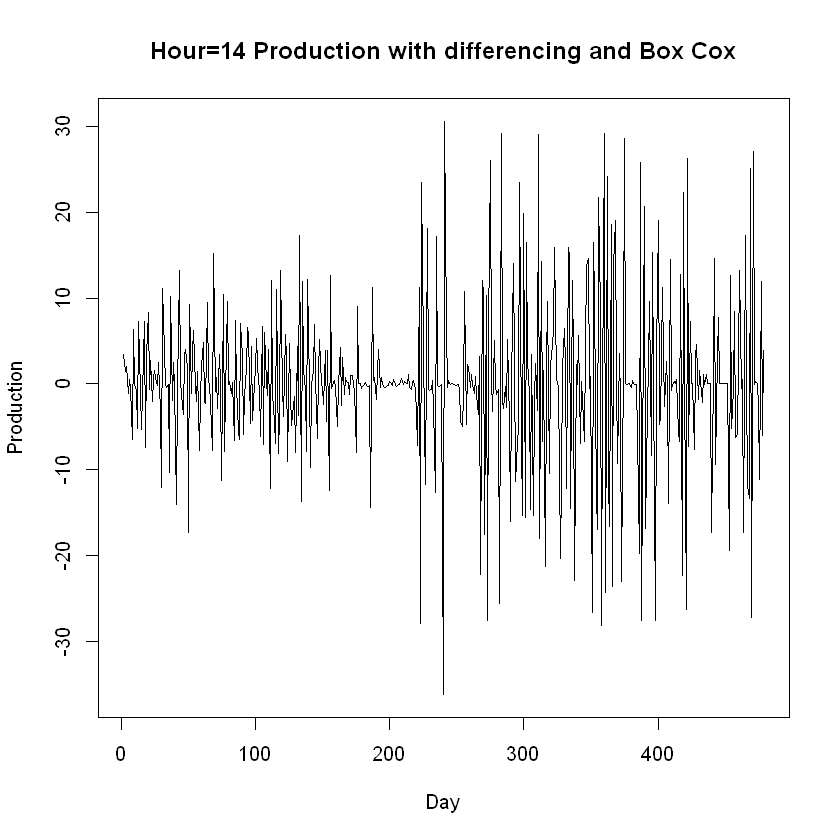


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 13.145, df = 8, p-value = 0.107

Model df: 2.   Total lags used: 10



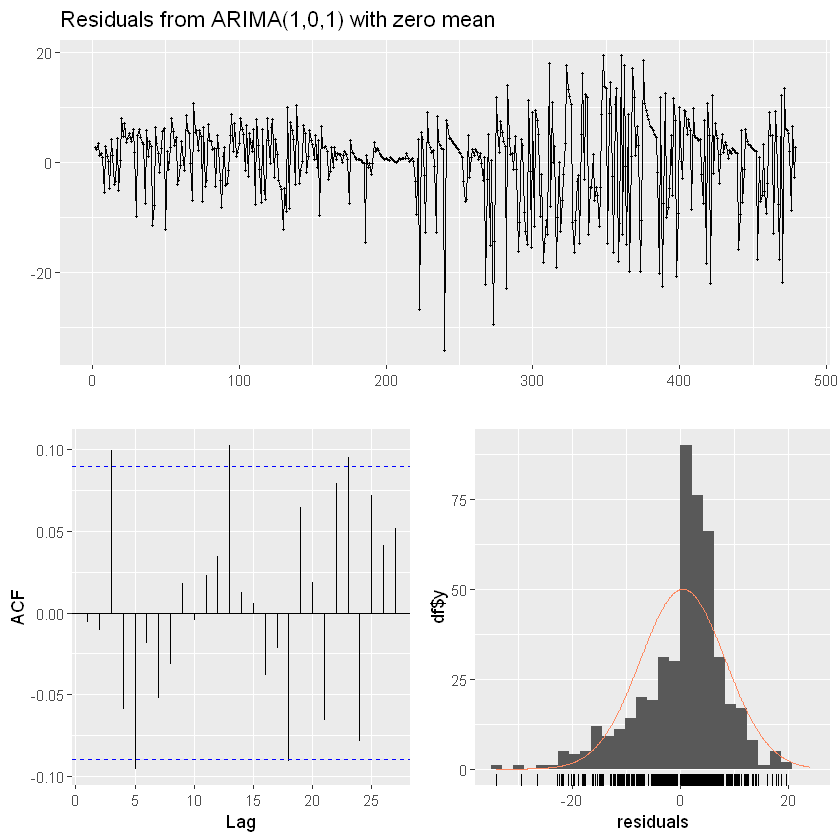

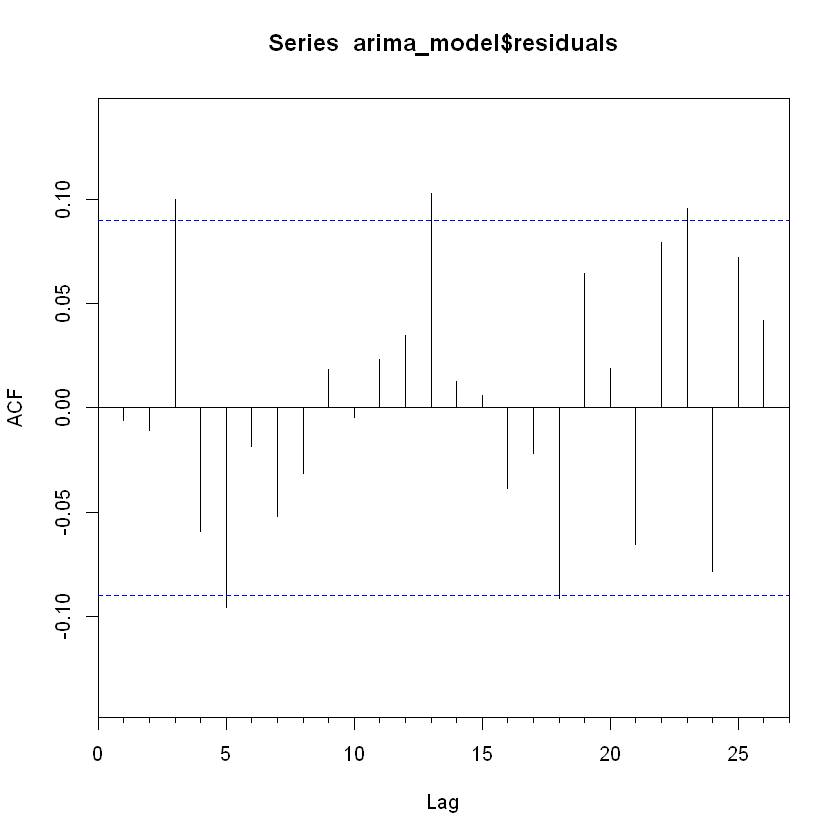


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.9279 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.8731 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0203 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


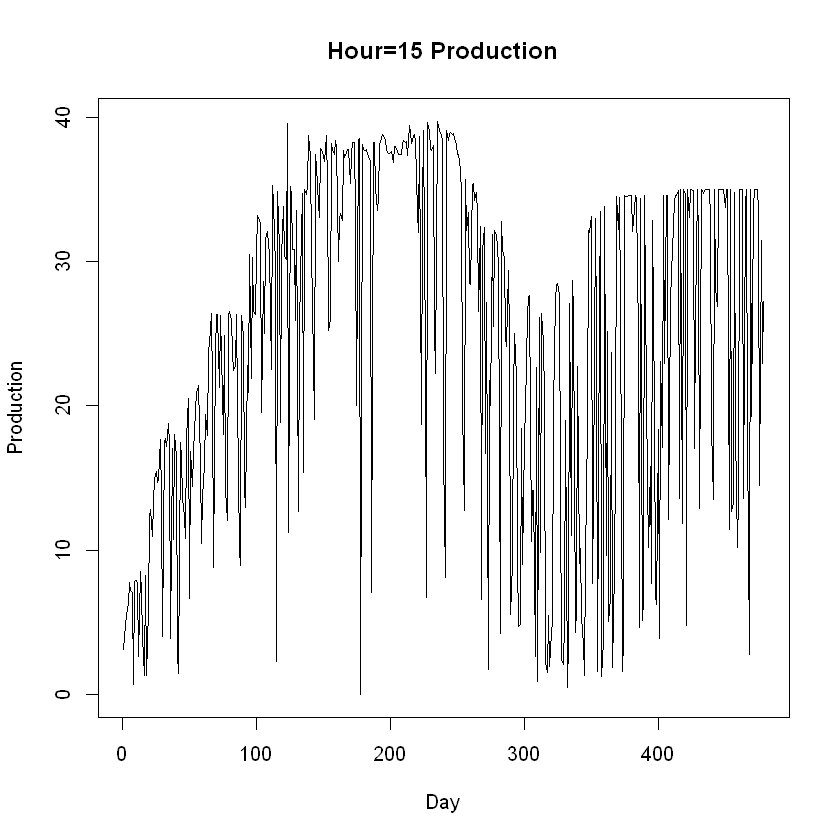


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3464.933
 ARIMA(0,0,0) with non-zero mean : 3673.623
 ARIMA(1,0,0) with non-zero mean : 3588.204
 ARIMA(0,0,1) with non-zero mean : 3467.064
 ARIMA(0,0,0) with zero mean     : 3671.616
 ARIMA(1,0,2) with non-zero mean : 3462.231
 ARIMA(0,0,2) with non-zero mean : 3459.838
 ARIMA(0,0,3) with non-zero mean : 3461.767
 ARIMA(1,0,1) with non-zero mean : 3460.695
 ARIMA(1,0,3) with non-zero mean : 3464.211
 ARIMA(0,0,2) with zero mean     : 3458.765
 ARIMA(0,0,1) with zero mean     : 3465.787
 ARIMA(1,0,2) with zero mean     : 3461.075
 ARIMA(0,0,3) with zero mean     : 3460.671
 ARIMA(1,0,1) with zero mean     : 3459.563
 ARIMA(1,0,3) with zero mean     : 3463.059

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,2) with zero mean     : 3459.613

 Best model: ARIMA(0,0,2) with zero mean     



Series: diff_series 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1      ma2
      -0.7416  -0.1400
s.e.   0.0463   0.0458

sigma^2 estimated as 80.51:  log likelihood=-1726.78
AIC=3459.56   AICc=3459.61   BIC=3472.07

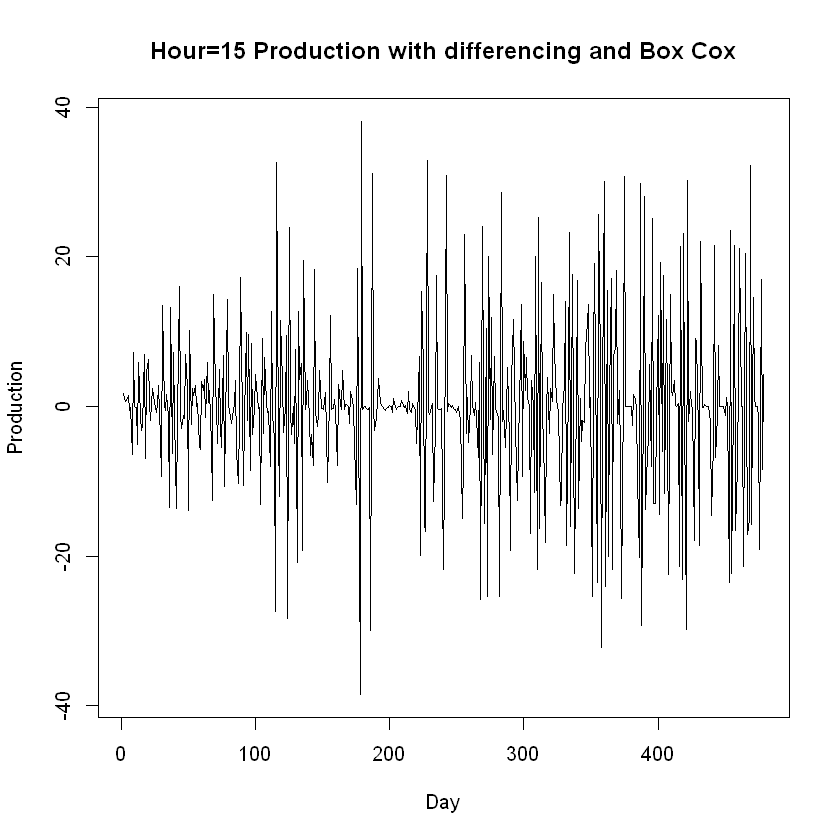


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with zero mean
Q* = 6.6597, df = 8, p-value = 0.5738

Model df: 2.   Total lags used: 10



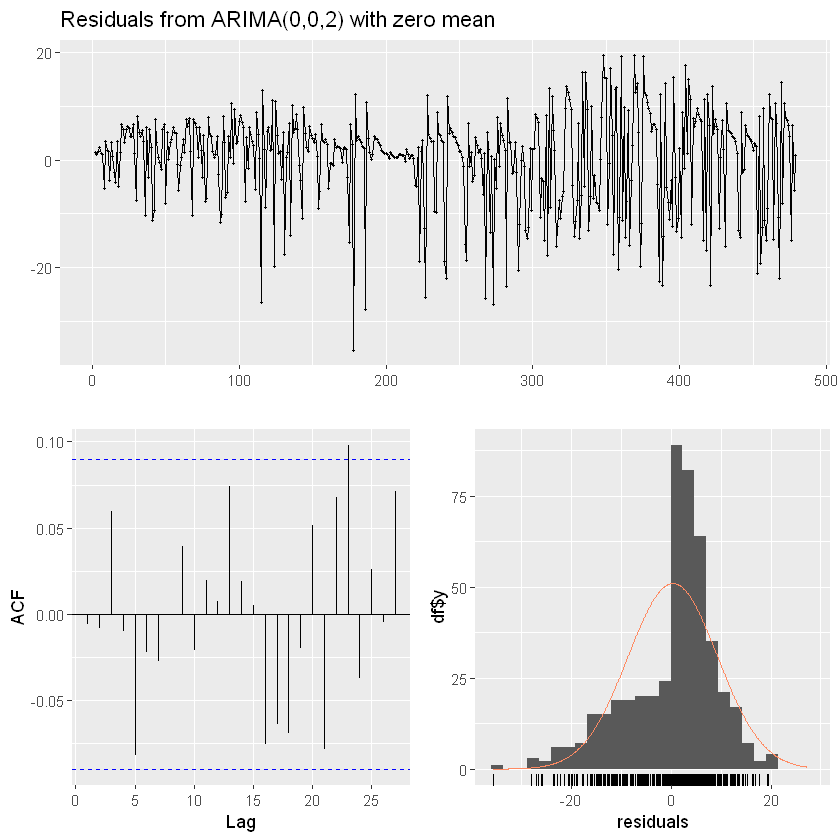

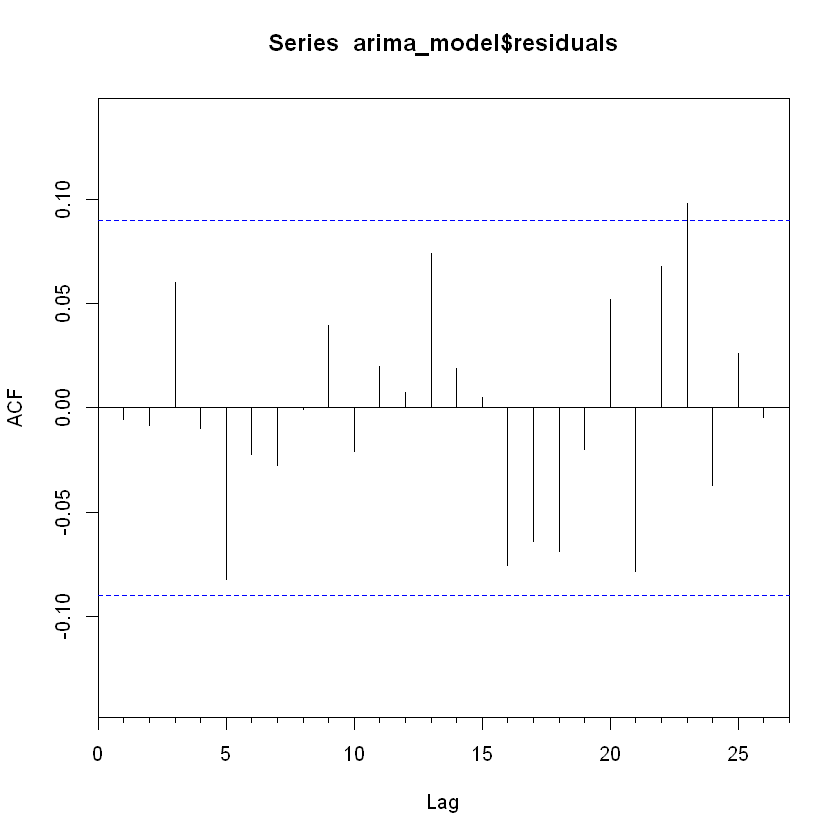


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.8482 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.8134 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0201 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


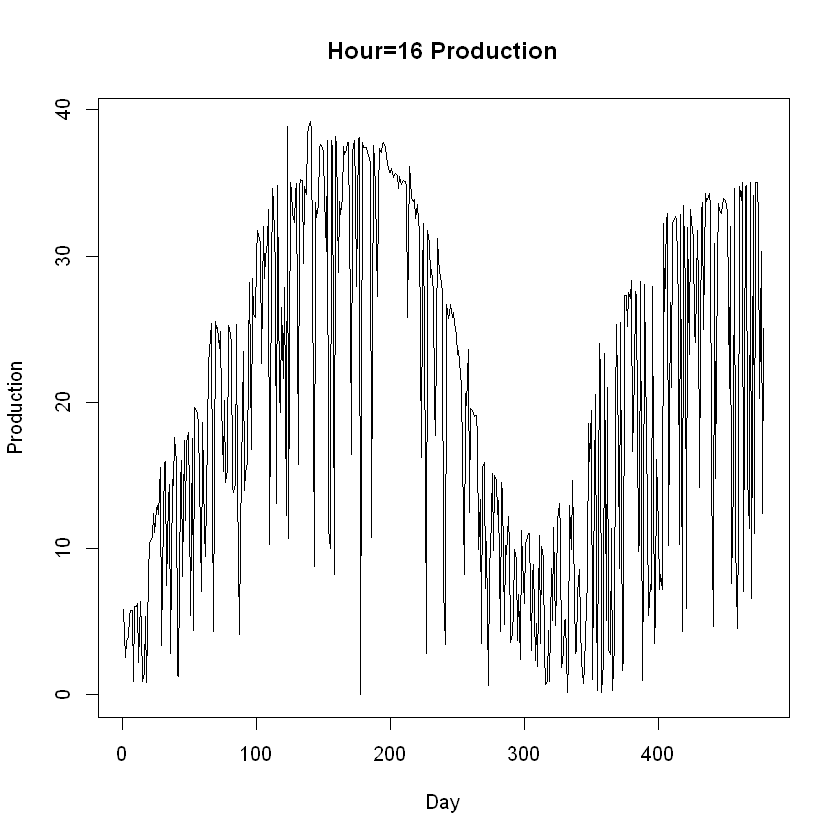


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 3354.016
 ARIMA(0,0,0) with non-zero mean : 3586.358
 ARIMA(1,0,0) with non-zero mean : 3483.866
 ARIMA(0,0,1) with non-zero mean : 3349.079
 ARIMA(0,0,0) with zero mean     : 3584.348
 ARIMA(1,0,1) with non-zero mean : 3351.136
 ARIMA(0,0,2) with non-zero mean : 3349.884
 ARIMA(1,0,2) with non-zero mean : 3351.504
 ARIMA(0,0,1) with zero mean     : 3347.569
 ARIMA(1,0,1) with zero mean     : 3349.759
 ARIMA(0,0,2) with zero mean     : 3348.419
 ARIMA(1,0,0) with zero mean     : 3481.857
 ARIMA(1,0,2) with zero mean     : 3350.083

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,1) with zero mean     : 3348.748

 Best model: ARIMA(0,0,1) with zero mean     



Series: diff_series 
ARIMA(0,0,1) with zero mean 

Coefficients:
          ma1
      -0.8435
s.e.   0.0255

sigma^2 estimated as 64:  log likelihood=-1672.36
AIC=3348.72   AICc=3348.75   BIC=3357.06

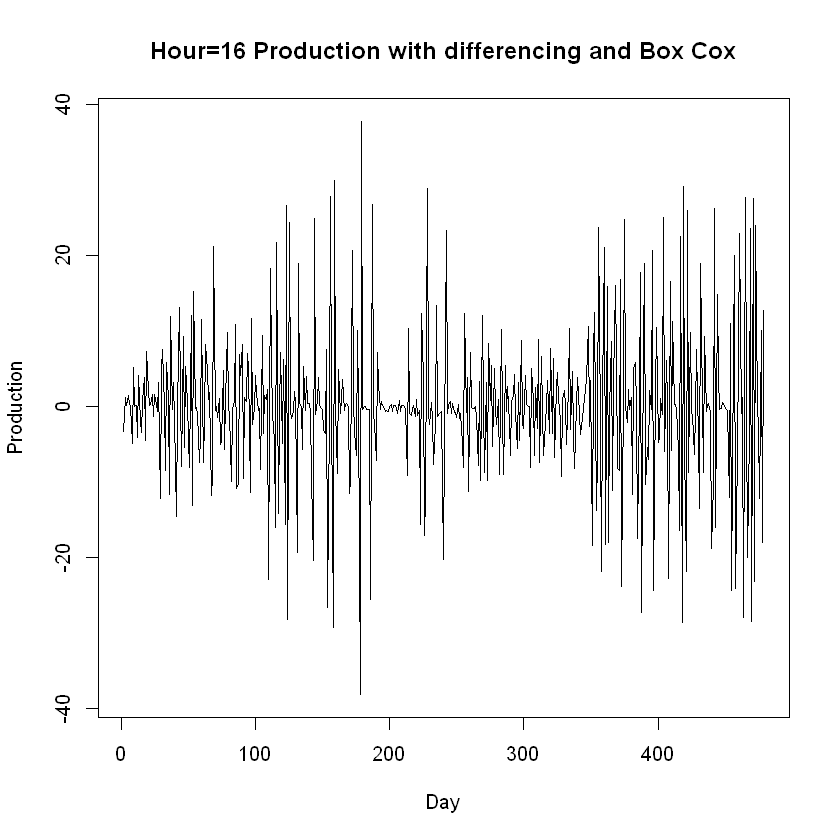


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with zero mean
Q* = 10.3, df = 9, p-value = 0.3268

Model df: 1.   Total lags used: 10



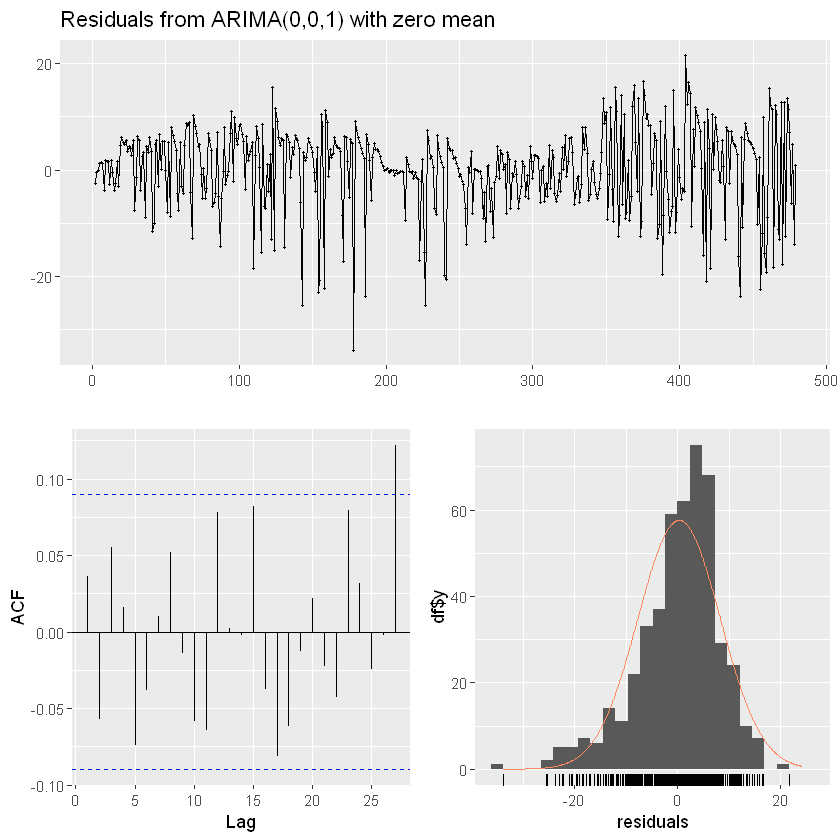

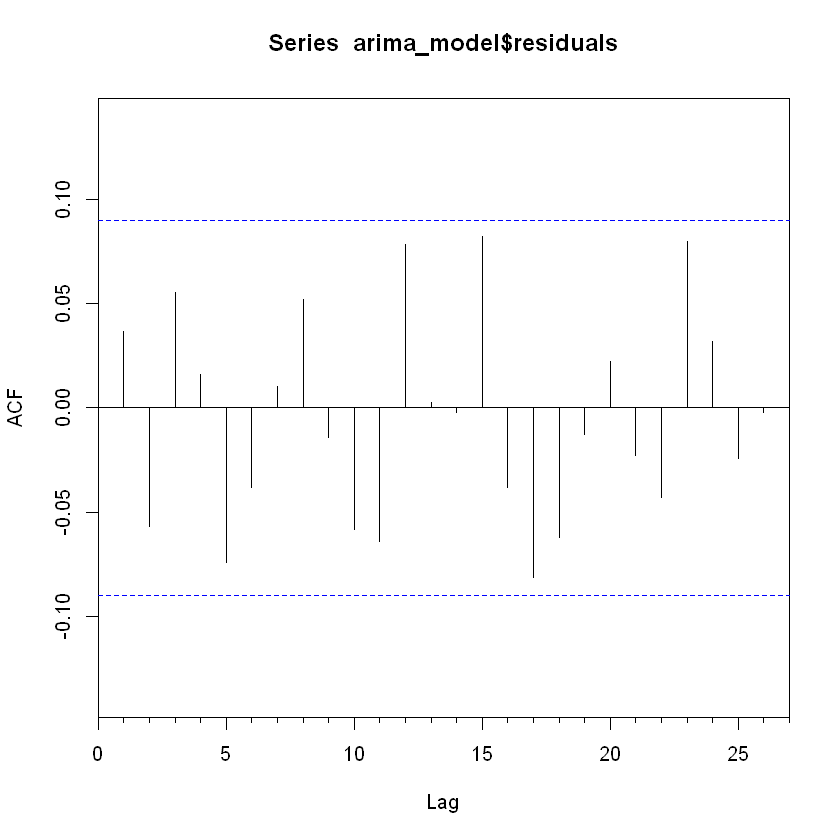


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.1041 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.1655 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0326 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


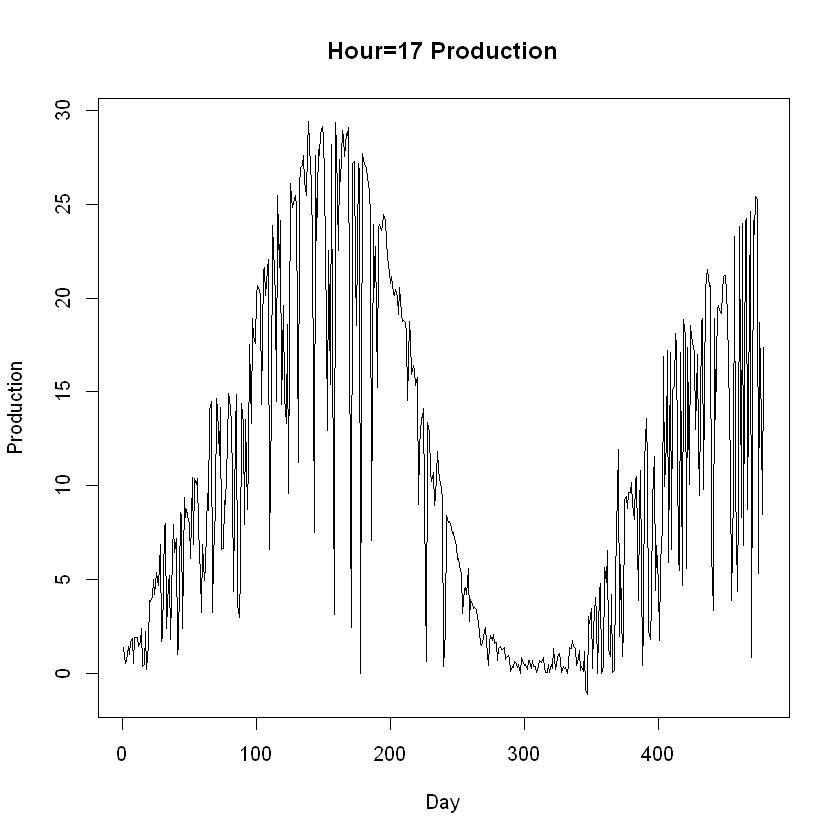


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 2838.822
 ARIMA(0,0,0) with non-zero mean : 3051.746
 ARIMA(1,0,0) with non-zero mean : 2964.343
 ARIMA(0,0,1) with non-zero mean : 2840.012
 ARIMA(0,0,0) with zero mean     : 3049.745
 ARIMA(1,0,2) with non-zero mean : 2836.168
 ARIMA(0,0,2) with non-zero mean : 2838.518
 ARIMA(1,0,1) with non-zero mean : 2840.138
 ARIMA(1,0,3) with non-zero mean : 2837.857
 ARIMA(0,0,3) with non-zero mean : 2837.685
 ARIMA(2,0,1) with non-zero mean : 2840.995
 ARIMA(2,0,3) with non-zero mean : 2830.427
 ARIMA(3,0,3) with non-zero mean : 2830.539
 ARIMA(2,0,4) with non-zero mean : 2832.37
 ARIMA(1,0,4) with non-zero mean : 2839.577
 ARIMA(3,0,2) with non-zero mean : 2841.205
 ARIMA(3,0,4) with non-zero mean : 2825.827
 ARIMA(4,0,4) with non-zero mean : 2822.137
 ARIMA(4,0,3) with non-zero mean : Inf
 ARIMA(5,0,4) with non-zero mean : 2824.642
 ARIMA(4,0,5) with non-zero mean : Inf
 ARIMA(3,0,5) with non-zer

Series: diff_series 
ARIMA(3,0,5) with zero mean 

Coefficients:
          ar1     ar2     ar3      ma1      ma2      ma3     ma4     ma5
      -0.6516  0.6330  0.9574  -0.0855  -1.3141  -0.5406  0.8211  0.1444
s.e.   0.0278  0.0233  0.0220   0.0544   0.0367   0.0706  0.0378  0.0474

sigma^2 estimated as 20.75:  log likelihood=-1400.45
AIC=2818.91   AICc=2819.29   BIC=2856.43

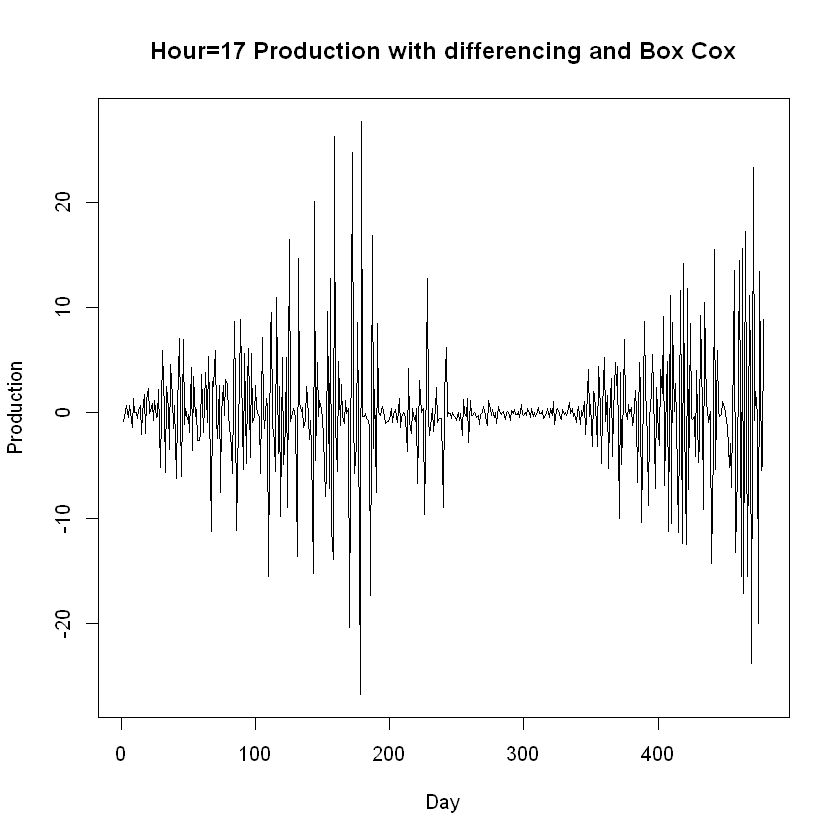


	Ljung-Box test

data:  Residuals from ARIMA(3,0,5) with zero mean
Q* = 9.8527, df = 3, p-value = 0.01986

Model df: 8.   Total lags used: 11



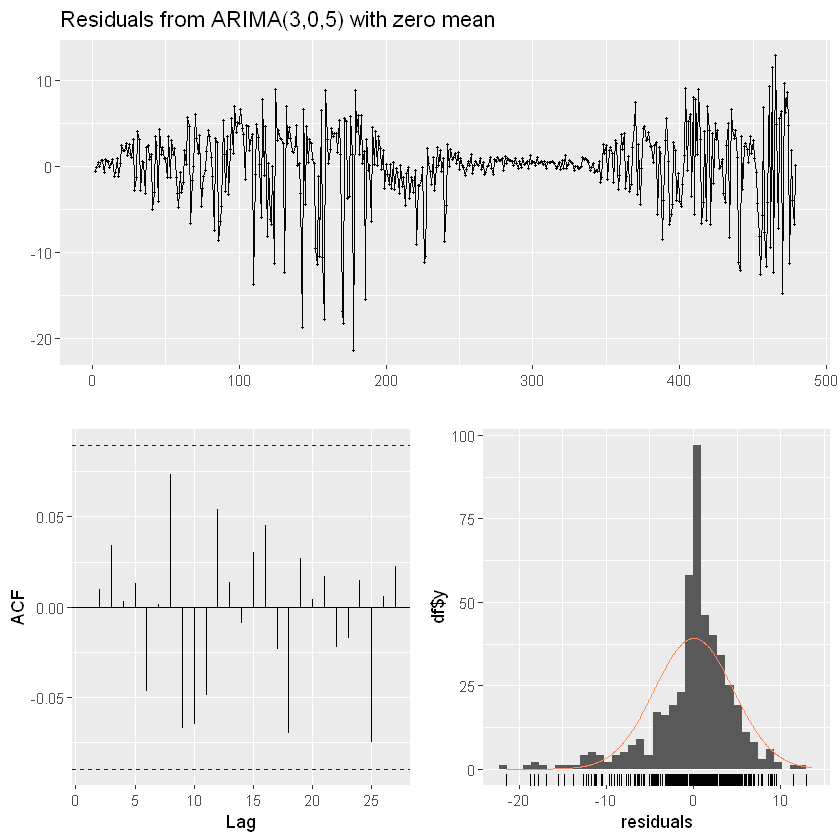

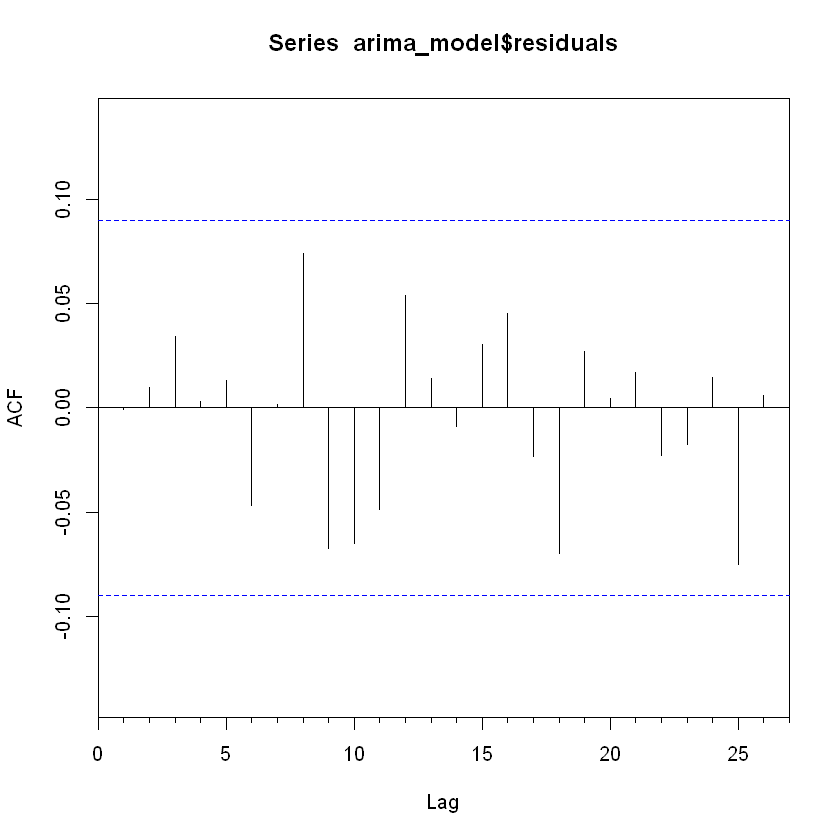


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.1759 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.016 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0532 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


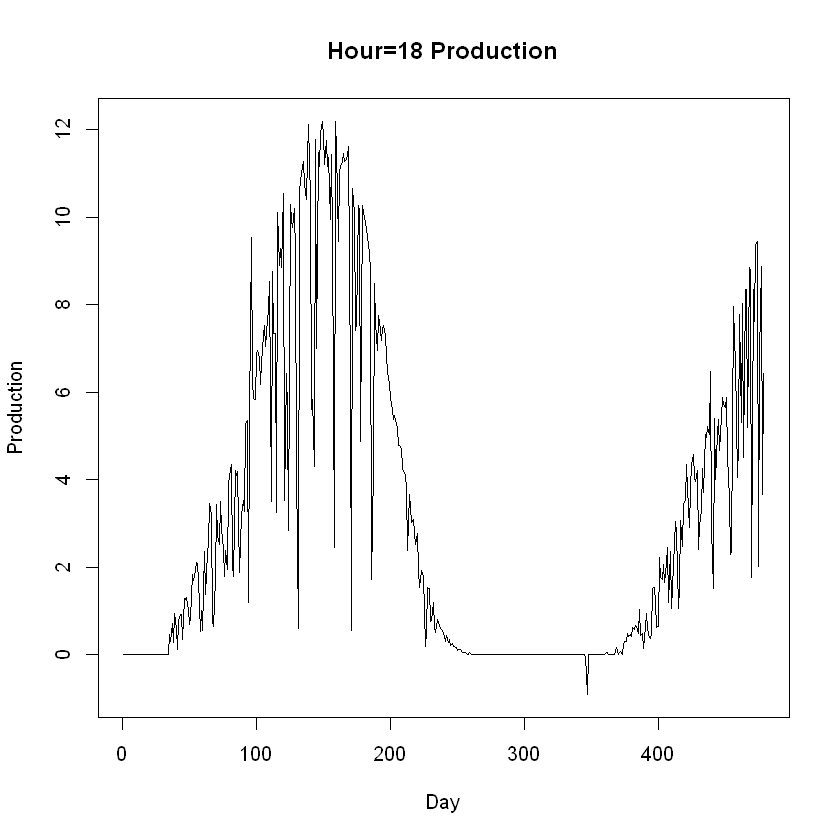


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 1740.498
 ARIMA(0,0,0) with non-zero mean : 1911.475
 ARIMA(1,0,0) with non-zero mean : 1849.471
 ARIMA(0,0,1) with non-zero mean : 1747.953
 ARIMA(0,0,0) with zero mean     : 1909.485
 ARIMA(1,0,2) with non-zero mean : 1737.71
 ARIMA(0,0,2) with non-zero mean : 1737.975
 ARIMA(1,0,1) with non-zero mean : 1741.512
 ARIMA(1,0,3) with non-zero mean : 1739.517
 ARIMA(0,0,3) with non-zero mean : 1736.601
 ARIMA(0,0,4) with non-zero mean : 1738.553
 ARIMA(1,0,4) with non-zero mean : 1741.575
 ARIMA(0,0,3) with zero mean     : 1735.41
 ARIMA(0,0,2) with zero mean     : 1736.818
 ARIMA(1,0,3) with zero mean     : 1738.32
 ARIMA(0,0,4) with zero mean     : 1737.355
 ARIMA(1,0,2) with zero mean     : 1736.53
 ARIMA(1,0,4) with zero mean     : 1740.37

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,3) with zero mean     : 1736.322

 Best model: ARIMA(0,0,3) with zero mean     

Series: diff_series 
ARIMA(0,0,3) with zero mean 

Coefficients:
          ma1      ma2     ma3
      -0.6312  -0.2257  0.0791
s.e.   0.0456   0.0542  0.0428

sigma^2 estimated as 2.186:  log likelihood=-864.12
AIC=1736.24   AICc=1736.32   BIC=1752.92

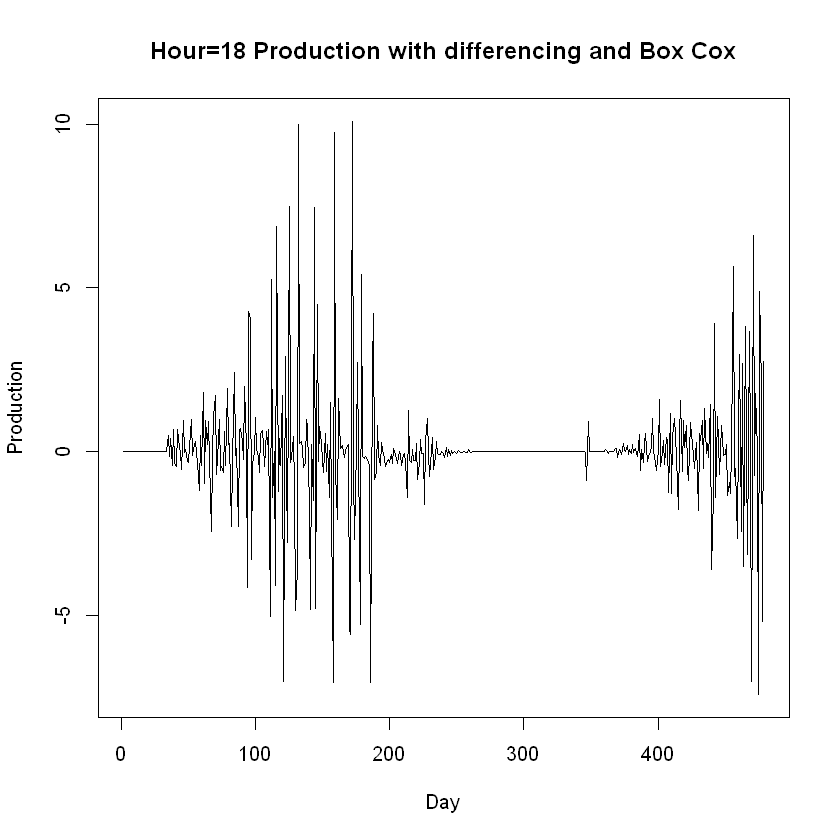


	Ljung-Box test

data:  Residuals from ARIMA(0,0,3) with zero mean
Q* = 9.566, df = 7, p-value = 0.2145

Model df: 3.   Total lags used: 10



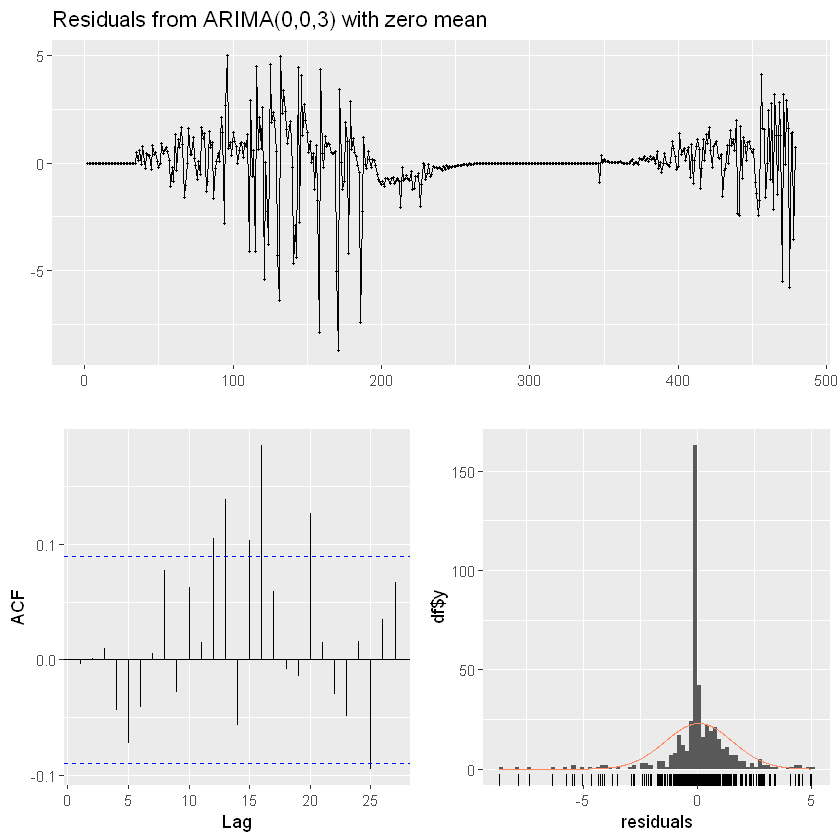

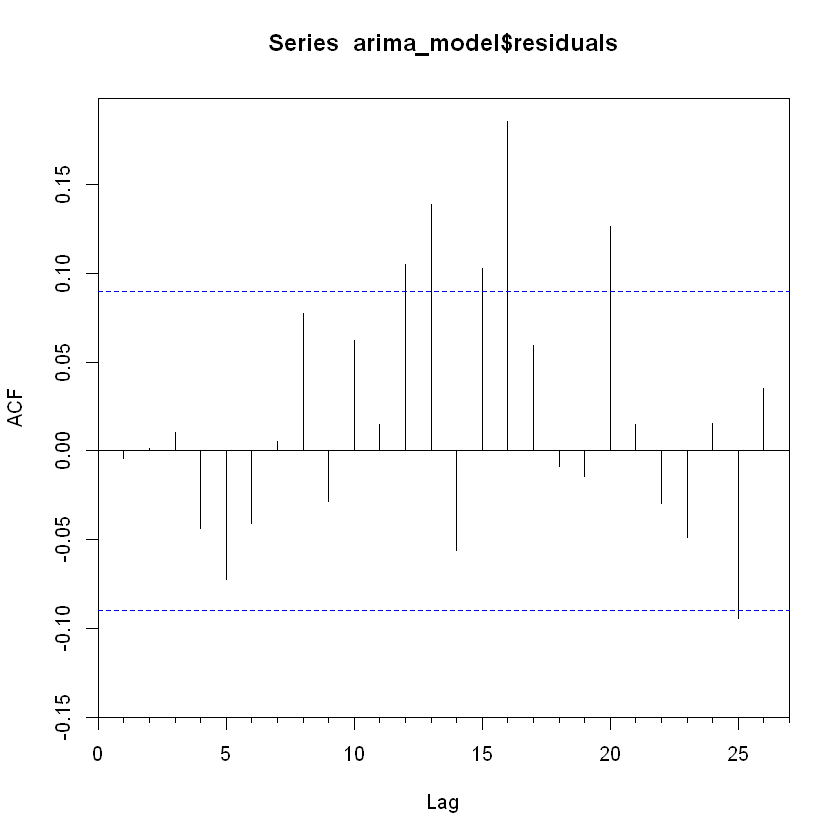


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2214 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 1.2286 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0551 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


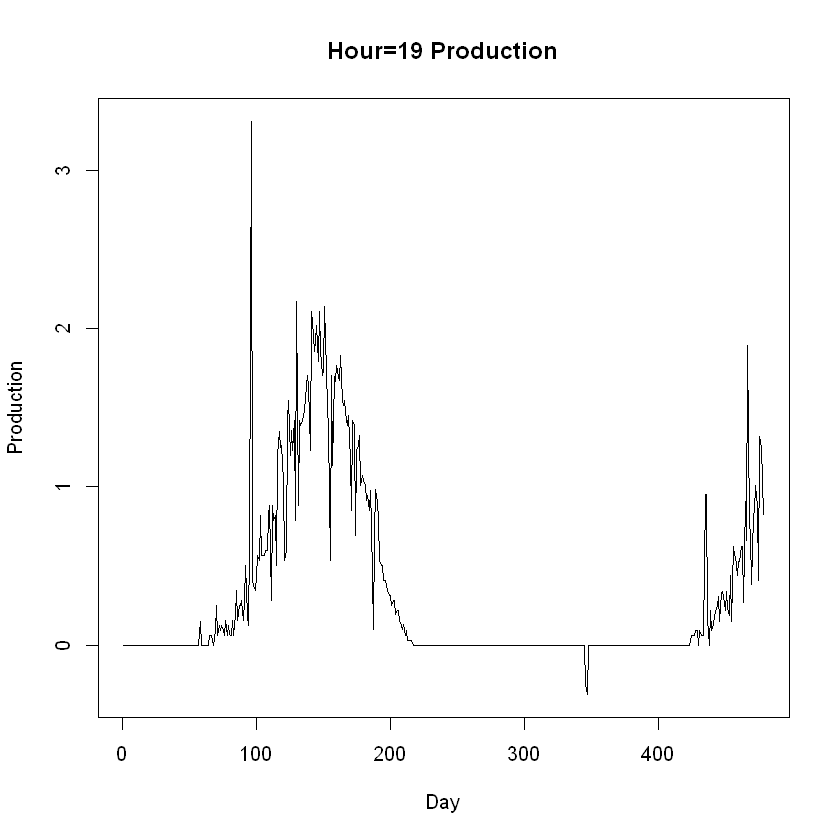


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -66.11766
 ARIMA(0,0,0) with non-zero mean : 141.226
 ARIMA(1,0,0) with non-zero mean : 43.07004
 ARIMA(0,0,1) with non-zero mean : -50.40953
 ARIMA(0,0,0) with zero mean     : 139.2274
 ARIMA(1,0,2) with non-zero mean : -46.21685
 ARIMA(2,0,1) with non-zero mean : -45.93034
 ARIMA(3,0,2) with non-zero mean : -48.55544
 ARIMA(2,0,3) with non-zero mean : Inf
 ARIMA(1,0,1) with non-zero mean : -48.13558
 ARIMA(1,0,3) with non-zero mean : -44.87816
 ARIMA(3,0,1) with non-zero mean : -50.56632
 ARIMA(3,0,3) with non-zero mean : -62.39402
 ARIMA(2,0,2) with zero mean     : -67.85403
 ARIMA(1,0,2) with zero mean     : -47.70404
 ARIMA(2,0,1) with zero mean     : -47.41598
 ARIMA(3,0,2) with zero mean     : -50.06451
 ARIMA(2,0,3) with zero mean     : Inf
 ARIMA(1,0,1) with zero mean     : -49.61527
 ARIMA(1,0,3) with zero mean     : -46.37199
 ARIMA(3,0,1) with zero mean     : -52.07011
 ARIMA(3,0

Series: diff_series 
ARIMA(2,0,2) with zero mean 

Coefficients:
         ar1      ar2      ma1     ma2
      1.1125  -0.1401  -1.8620  0.8791
s.e.  0.0552   0.0532   0.0294  0.0280

sigma^2 estimated as 0.04995:  log likelihood=39.07
AIC=-68.15   AICc=-68.02   BIC=-47.3

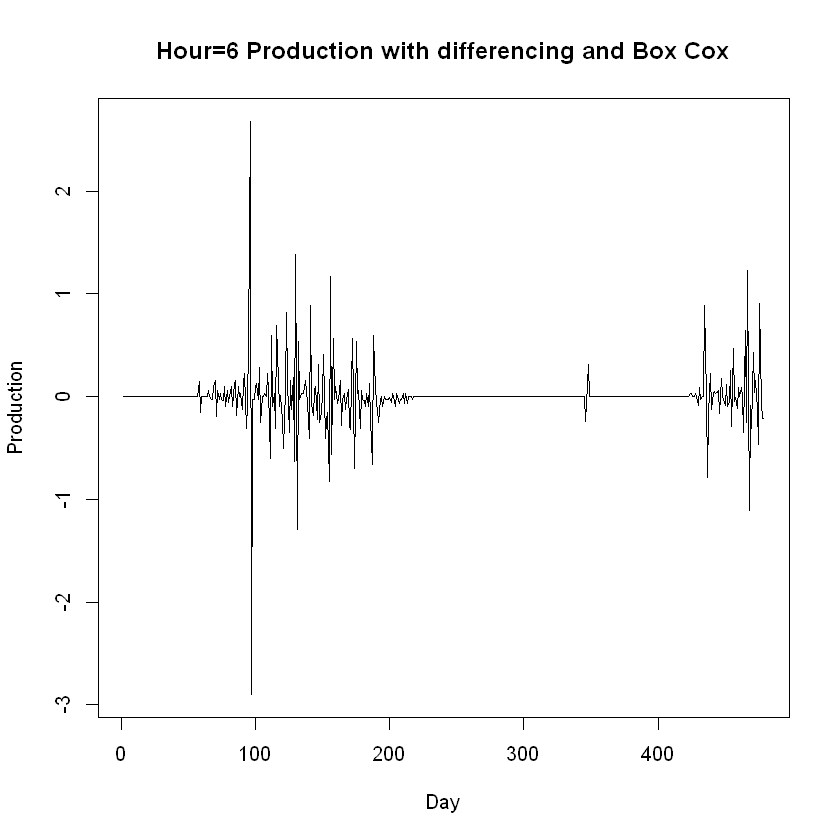


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with zero mean
Q* = 13.611, df = 6, p-value = 0.0343

Model df: 4.   Total lags used: 10



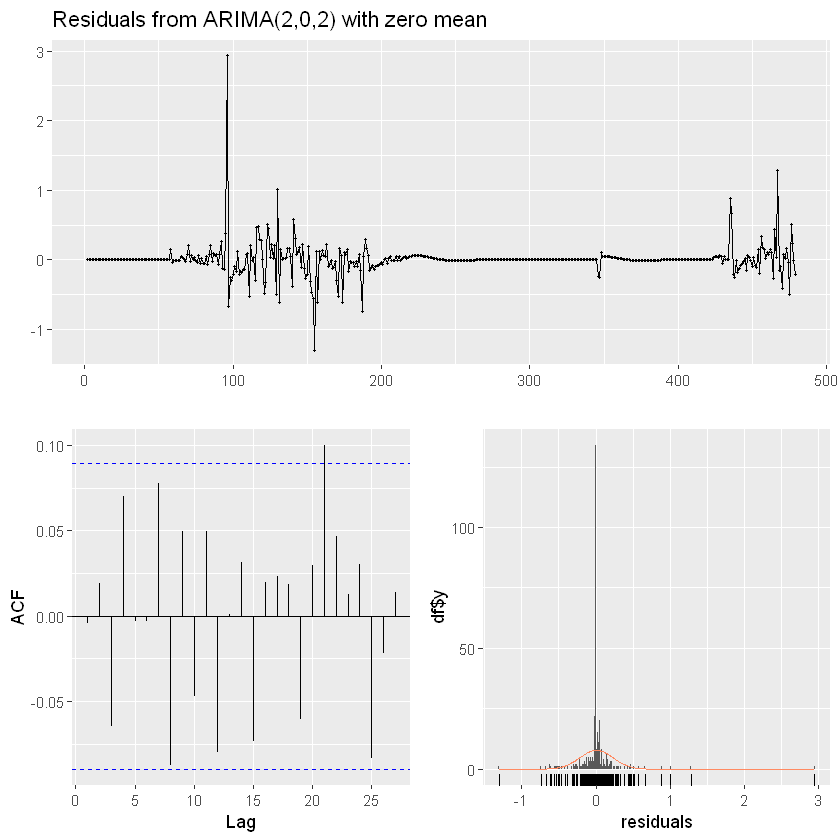

date,hour,production,arima,actual,residual
2022-05-27,0,NA,0.000000,NA,NA
2022-05-27,1,NA,0.000000,NA,NA
2022-05-27,2,NA,0.000000,NA,NA
2022-05-27,3,NA,0.000000,NA,NA
2022-05-27,4,NA,0.000000,NA,NA
2022-05-27,5,NA,1.020527,NA,NA
2022-05-27,6,NA,7.568404,NA,NA
2022-05-27,7,NA,28.429896,NA,NA
2022-05-27,8,NA,34.408378,NA,NA
2022-05-27,9,NA,35.777058,NA,NA


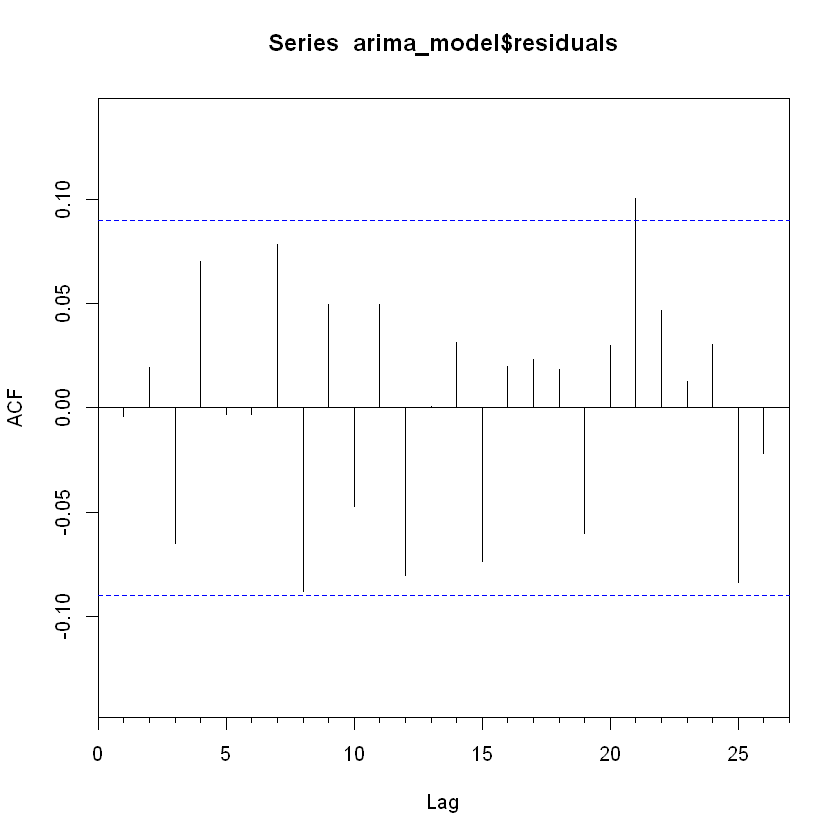


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1025 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.135 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0063 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


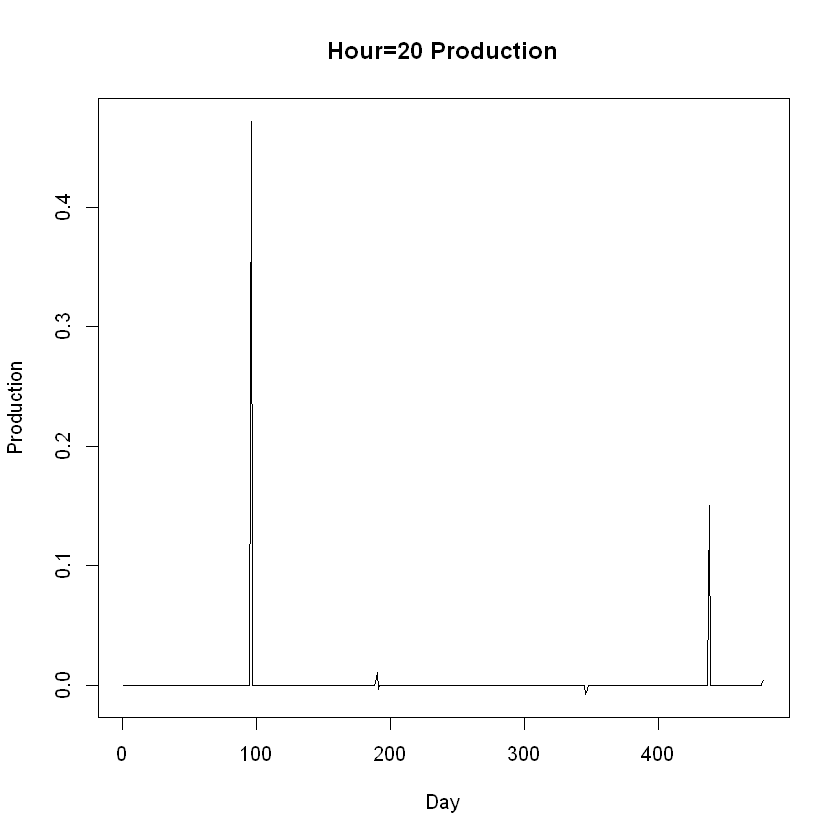


 ARIMA(0,0,0) with zero mean     : -1930.626
 ARIMA(0,0,0) with non-zero mean : -1928.609
 ARIMA(0,0,1) with zero mean     : Inf
 ARIMA(0,0,1) with non-zero mean : Inf
 ARIMA(0,0,2) with zero mean     : Inf
 ARIMA(0,0,2) with non-zero mean : Inf
 ARIMA(0,0,3) with zero mean     : Inf
 ARIMA(0,0,3) with non-zero mean : Inf
 ARIMA(0,0,4) with zero mean     : Inf
 ARIMA(0,0,4) with non-zero mean : Inf
 ARIMA(0,0,5) with zero mean     : Inf
 ARIMA(0,0,5) with non-zero mean : Inf
 ARIMA(1,0,0) with zero mean     : -2065.787
 ARIMA(1,0,0) with non-zero mean : -2063.762
 ARIMA(1,0,1) with zero mean     : Inf
 ARIMA(1,0,1) with non-zero mean : Inf
 ARIMA(1,0,2) with zero mean     : Inf
 ARIMA(1,0,2) with non-zero mean : Inf
 ARIMA(1,0,3) with zero mean     : Inf
 ARIMA(1,0,3) with non-zero mean : Inf
 ARIMA(1,0,4) with zero mean     : Inf
 ARIMA(1,0,4) with non-zero mean : Inf
 ARIMA(2,0,0) with zero mean     : -2119.819
 ARIMA(2,0,0) with non-zero mean : -2117.785
 ARIMA(2,0,1) with zero mea

Series: diff_series 
ARIMA(5,0,0) with zero mean 

Coefficients:
          ar1      ar2      ar3      ar4      ar5
      -0.8315  -0.6638  -0.4969  -0.3306  -0.1650
s.e.   0.0451   0.0570   0.0603   0.0568   0.0449

sigma^2 estimated as 0.0006055:  log likelihood=1094.6
AIC=-2177.19   AICc=-2177.01   BIC=-2152.17

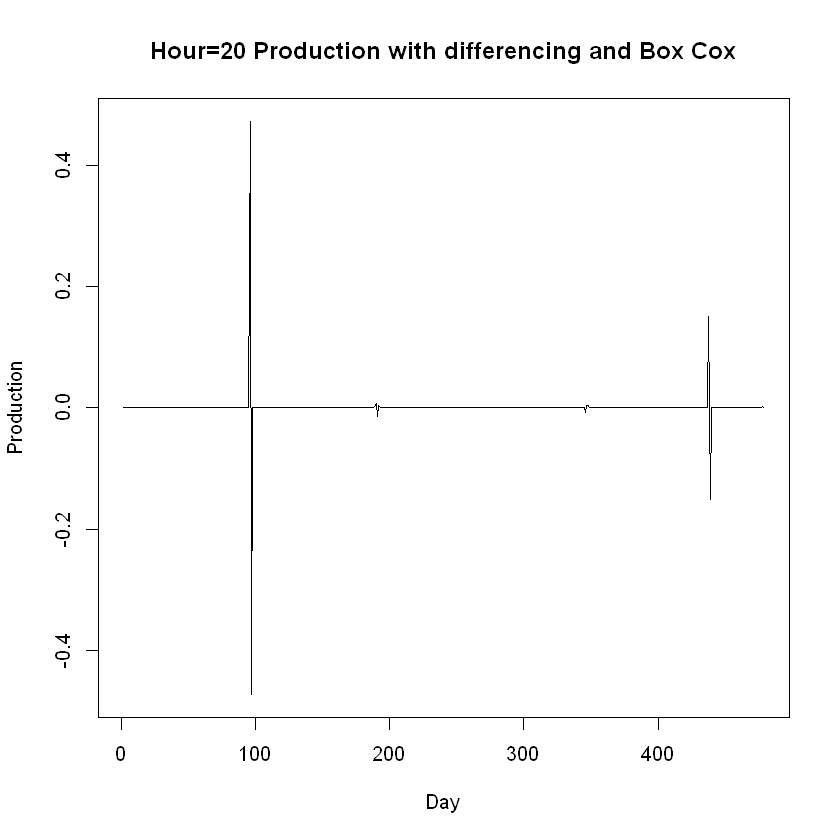


	Ljung-Box test

data:  Residuals from ARIMA(5,0,0) with zero mean
Q* = 24.771, df = 5, p-value = 0.0001543

Model df: 5.   Total lags used: 10



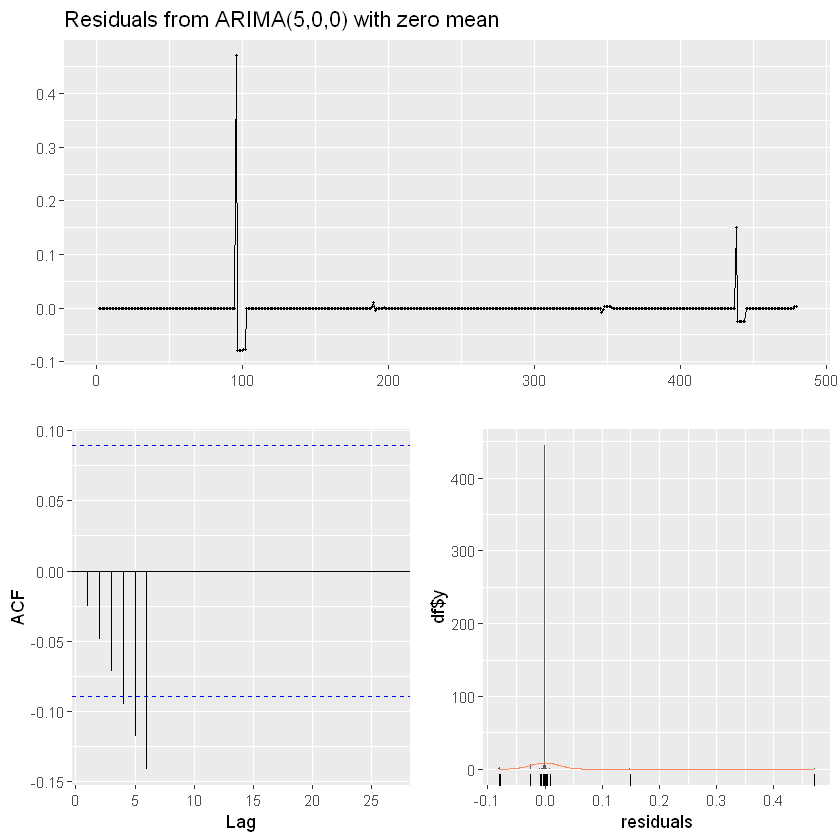

date,hour,production,arima,actual,residual
2022-05-27,0,NA,0.000000000,NA,NA
2022-05-27,1,NA,0.000000000,NA,NA
2022-05-27,2,NA,0.000000000,NA,NA
2022-05-27,3,NA,0.000000000,NA,NA
2022-05-27,4,NA,0.000000000,NA,NA
2022-05-27,5,NA,1.020527487,NA,NA
2022-05-27,6,NA,7.568404316,NA,NA
2022-05-27,7,NA,28.429895619,NA,NA
2022-05-27,8,NA,34.408377641,NA,NA
2022-05-27,9,NA,35.777058175,NA,NA


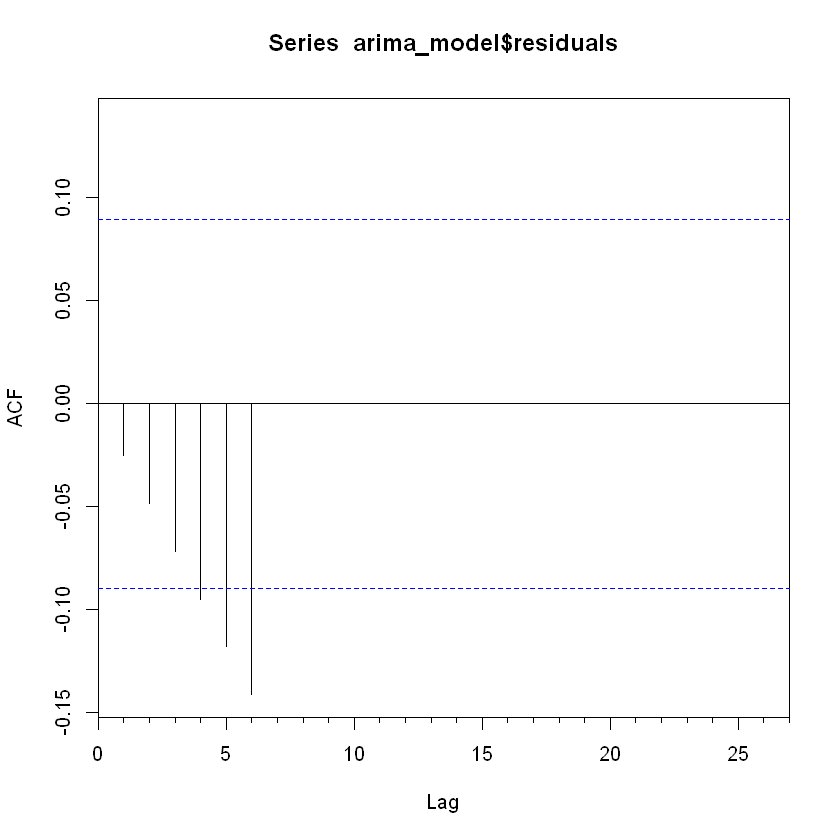

In [18]:
todays_date = as.Date("2022-05-26")
weather_file='2022-05-26_weather.csv'
production_file='2022-05-26_production.csv'
weather <- fread(weather_file)
prod <- fread(production_file)

str(weather)
str(prod)
weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")
weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
prod$date <- as.Date(prod$date, format = "%Y-%m-%d")
merged <- merge(weather, prod, by = c("date","hour"), all = T)
merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
show_na <-merged[rowSums(is.na(merged)) > 0, ]
# show_na








forecast_date=todays_date+1

# create a template for forecast date
forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
forecast_table[,arima:=NA]
forecast_table$arima=as.numeric(forecast_table$arima)
forecast_table[,actual:=NA]
forecast_table$actual=as.numeric(forecast_table$actual)
forecast_table[,residual:=NA]
forecast_table$residual=as.numeric(forecast_table$residual)


forecast_date=todays_date+1

# create a template for forecast date
forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
forecast_table[,arima:=NA]
forecast_table$arima=as.numeric(forecast_table$arima)
forecast_table[,actual:=NA]
forecast_table$actual=as.numeric(forecast_table$actual)
forecast_table[,residual:=NA]
forecast_table$residual=as.numeric(forecast_table$residual)


for (i in c(1:5)) {
  forecast_table$arima[i] =0 
}



#merged5
production_hour5_ts<-ts(merged5[!is.na(production)]$production,frequency=1)
ts.plot(production_hour5_ts, xlab = "Day", ylab = "Production",main="Hour=5 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour5_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour5_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour5_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(box_prod,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=5 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
arima_forecast=InvBoxCox(as.numeric(format(arima_forecast$mean[3],scientific = FALSE)),as.numeric(lambda)) 
forecast_table$arima[6]=(arima_forecast)
forecast_table

#merged6
production_hour6_ts<-ts(merged6[!is.na(production)]$production,frequency=1)
ts.plot(production_hour6_ts, xlab = "Day", ylab = "Production",main="Hour=6 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour6_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour6_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour6_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour6_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[7]=sum(arima_forecast$mean)+merged6[nrow(merged6)-3,]$production



#merged7

production_hour7_ts<-ts(merged7[!is.na(production)]$production,frequency=1)
ts.plot(production_hour7_ts, xlab = "Day", ylab = "Production",main="Hour=7 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour7_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour7_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour7_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour7_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[8]=sum(arima_forecast$mean)+merged7[nrow(merged7)-3,]$production

#merged8

production_hour8_ts<-ts(merged8[!is.na(production)]$production,frequency=1)
ts.plot(production_hour8_ts, xlab = "Day", ylab = "Production",main="Hour=8 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour8_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour8_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour8_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour8_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=8 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)

forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[9]=sum(arima_forecast$mean)+merged8[nrow(merged8)-3,]$production



#merged9

production_hour9_ts<-ts(merged9[!is.na(production)]$production,frequency=1)
ts.plot(production_hour9_ts, xlab = "Day", ylab = "Production",main="Hour=9 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour9_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour9_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour9_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour9_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[10]=sum(arima_forecast$mean)+merged9[nrow(merged9)-3,]$production



#merged10
production_hour10_ts<-ts(merged10[!is.na(production)]$production,frequency=1)
ts.plot(production_hour10_ts, xlab = "Day", ylab = "Production",main="Hour=7 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour10_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour10_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour10_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour10_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=10 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[11]=sum(arima_forecast$mean)+merged10[nrow(merged10)-3,]$production


#merged11

production_hour11_ts<-ts(merged11[!is.na(production)]$production,frequency=1)
ts.plot(production_hour11_ts, xlab = "Day", ylab = "Production",main="Hour=11 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour11_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour11_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour11_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour11_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[12]=sum(arima_forecast$mean)+merged11[nrow(merged11)-3,]$production

#merged12 

production_hour12_ts<-ts(merged12[!is.na(production)]$production,frequency=1)
ts.plot(production_hour12_ts, xlab = "Day", ylab = "Production",main="Hour=12 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour12_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour12_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour12_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour12_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[13]=sum(arima_forecast$mean)+merged12[nrow(merged12)-3,]$production


#merged13
production_hour13_ts<-ts(merged13[!is.na(production)]$production,frequency=1)
ts.plot(production_hour13_ts, xlab = "Day", ylab = "Production",main="Hour=7 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour13_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour13_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour13_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour13_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[14]=sum(arima_forecast$mean)+merged13[nrow(merged13)-3,]$production


#merged14
production_hour14_ts<-ts(merged14[!is.na(production)]$production,frequency=1)
ts.plot(production_hour14_ts, xlab = "Day", ylab = "Production",main="Hour=14 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour14_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour14_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour14_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour14_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=14 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[15]=sum(arima_forecast$mean)+merged14[nrow(merged14)-3,]$production



#merged15
production_hour15_ts<-ts(merged15[!is.na(production)]$production,frequency=1)
ts.plot(production_hour15_ts, xlab = "Day", ylab = "Production",main="Hour=15 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour15_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour15_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour15_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour15_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=15 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[16]=sum(arima_forecast$mean)+merged15[nrow(merged15)-3,]$production


#merged16

production_hour16_ts<-ts(merged16[!is.na(production)]$production,frequency=1)
ts.plot(production_hour16_ts, xlab = "Day", ylab = "Production",main="Hour=16 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour16_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour16_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour16_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour16_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=16 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[17]=sum(arima_forecast$mean)+merged16[nrow(merged16)-3,]$production



#merged17
production_hour17_ts<-ts(merged17[!is.na(production)]$production,frequency=1)
ts.plot(production_hour17_ts, xlab = "Day", ylab = "Production",main="Hour=17 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour17_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour17_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour17_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour17_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=17 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[18]=sum(arima_forecast$mean)+merged17[nrow(merged17)-3,]$production


#merged18
production_hour18_ts<-ts(merged18[!is.na(production)]$production,frequency=1)
ts.plot(production_hour18_ts, xlab = "Day", ylab = "Production",main="Hour=18 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour18_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour18_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour18_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour18_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=18 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[19]=sum(arima_forecast$mean)+merged18[nrow(merged18)-3,]$production

#merged19
production_hour19_ts<-ts(merged19[!is.na(production)]$production,frequency=1)
ts.plot(production_hour19_ts, xlab = "Day", ylab = "Production",main="Hour=19 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour19_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour19_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour19_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour19_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=6 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[20]=sum(arima_forecast$mean)+merged19[nrow(merged19)-3,]$production

forecast_table

#merged20
production_hour20_ts<-ts(merged20[!is.na(production)]$production,frequency=1)
ts.plot(production_hour20_ts, xlab = "Day", ylab = "Production",main="Hour=20 Production")
#data is not stationary and as can be seen from the plot variance is changing so box cox box transformation is required
require(urca)
unt_test=ur.kpss(production_hour20_ts) 
summary(unt_test)

#Box-Cox transformation is done
lambda <- BoxCox.lambda(production_hour20_ts, method ="guerrero", lower = -1, upper = 2)
box_prod<-BoxCox(production_hour20_ts,lambda)

unt_test=ur.kpss(box_prod) 
summary(unt_test)

#differencing is done
diff_series<-diff(production_hour20_ts,1)
unt_test=ur.kpss(diff_series) 
summary(unt_test)

ts.plot(diff_series, xlab = "Day", ylab = "Production",main="Hour=20 Production with differencing and Box Cox")
arima_model=auto.arima(diff_series,seasonal=F,stepwise=F,approximation=F,trace=T)
arima_model
checkresiduals(arima_model)
Acf(arima_model$residuals)


forecast_ahead=3
arima_forecast=forecast(arima_model,h=forecast_ahead)
forecast_table$arima[21]=sum(arima_forecast$mean)+merged20[nrow(merged20)-3,]$production

for (i in c(22:24)) {
  forecast_table$arima[i]=0
}

forecast_table


## 5.3- SARIMA

An extension of arima, the sarima model, is used to model seasonality that the arima model does not take into account. The parameters for SARIMA(p,d,q)x(P,D,Q,s) model are as follows:<br|
* **p and seasonal P:** indicate number of autoregressive terms (lags of the stationarized series)
* **d and seasonal D:** indicate differencing that must be done to stationarize series
* **q and seasonal Q:** indicate number of moving average terms (lags of the forecast errors)
* **s:** indicates seasonal length in the data

Since it is anticipated that the production of solar panels will vary from month to month or from season to season, the sarima model has also been applied in the project.<br> 
**Approach:** SARIMA model can only model one seasonality. In case there is more than one seasonality in the data, wrapping is applied both to the whole data and to the data separately for each hour. The auto.arima function is used in both approaches, therefore parameters are determined automatically. Before applying the SARIMA, it was checked whether the data was stationary or not with the KPSS test. Since SARIMA takes seasonality into account, a prior differencing process is not applied to make the data stationary. We have made 3 days ahead production forecast because we have the production data until 2 days before the day we are and we make the forecast for the next day. When new data came in every day, all the days up to that day were used to train the model. So the expanding window approach was applied. According to results of the auto.arima function, the best models are as follows:    

### 5.3.1- SARIMA for each hour

In [19]:
forecast_date=todays_date+1

production=fread(production_file)

latest_available_prod_date=as.Date(max(production$date))
n_days=as.numeric(forecast_date-latest_available_prod_date)

forecasted_production=tail(production,n_days*24)
forecasted_production[,date:=date+n_days]
forecasted_production[,production:=NA]

production_with_forecast=rbind(production,forecasted_production)

# create a template for forecast date
# forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
forecast_sarima_sep <- c()

for (i in 0:23){
  value <- production_with_forecast[hour==i]
  x <- paste("prod",i, sep="")
  eval(call("<-", as.name(x), value))
}

forecast_table[,sarima:=NA]
forecast_table$sarima=as.numeric(forecast_table$sarima)

for (i in 0:23){
  x <- paste("prod",i, sep="")
  value <- ts(eval(parse( text=paste("prod", i, sep = "")))[!is.na(production)]$production,frequency=30)
  ser<-paste("series_",i, sep="")
  eval(call("<-", as.name(ser), value))
  sarima_model=auto.arima(eval(parse( text=paste("series_", i, sep = ""))),seasonal=T,stepwise=T,approximation=T,trace=T)
  forecast_ahead=nrow(forecast_table)/24
  sarima_forecast=forecast(sarima_model,h=forecast_ahead)
  #forecast_table[hour==i,"sarima"]=as.numeric(format(sarima_forecast$mean,scientific = FALSE))
  forecast_sarima_sep <- append(forecast_sarima_sep, as.numeric(format(sarima_forecast$mean,scientific = FALSE)))
}

forecast_sarima_sep


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)(1,0,1)[30] with drift         : -2492.269
 ARIMA(0,1,0)            with drift         : -2390.438
 ARIMA(1,1,0)(1,0,0)[30] with drift         : -2446.485
 ARIMA(0,1,1)(0,0,1)[30] with drift         : -2510.198
 ARIMA(0,1,0)                               : -2392.321
 ARIMA(0,1,1)            with drift         : -2511.696
 ARIMA(0,1,1)(1,0,0)[30] with drift         : -2479.254
 ARIMA(0,1,1)(1,0,1)[30] with drift         : -2477.434
 ARIMA(1,1,1)            with drift         : -2510.141
 ARIMA(0,1,2)            with drift         : -2511.995
 ARIMA(0,1,2)(1,0,0)[30] with drift         : -2479.489
 ARIMA(0,1,2)(0,0,1)[30] with drift         : -2510.433
 ARIMA(0,1,2)(1,0,1)[30] with drift         : Inf
 ARIMA(1,1,2)            with drift         : -2524.225
 ARIMA(1,1,2)(1,0,0)[30] with drift         : -2491.63
 ARIMA(1,1,2)(0,0,1)[30] with drift         : -2522.637
 ARIMA(1,1,2)(1,0,1)[30] with drift         : -248

[1]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.1336565
 [7]  6.6077950 26.2335700 34.0727200 33.6897200 34.1962200 34.6448500
[13] 33.4826600 31.9864400 29.8544100 28.6381200 26.3060400 15.7204400
[19]  8.2887970  0.9860559  0.0000000  0.0000000  0.0000000  0.0000000

### 5.3.2- SARIMA Unseperated

In [20]:
# SARIMA unseparated 
production=fread(production_file)
weather=fread(weather_file)
forecast_date=todays_date+1

latest_available_prod_date=as.Date(max(production$date))
n_days=as.numeric(forecast_date-latest_available_prod_date)

forecasted_production=tail(production,n_days*24)
forecasted_production[,date:=date+n_days]
forecasted_production[,production:=NA]

require(urca)
unt_test=ur.kpss(ts(production$production,frequency=24)) 
summary(unt_test)

production_with_forecast=rbind(production,forecasted_production)
# forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)

production_with_forecast=production_with_forecast[order(date,hour)]
production_series=ts(production_with_forecast[!is.na(production)]$production,frequency=24)

sarima_model=auto.arima(production_series,seasonal=T,stepwise=T,approximation=T,trace=T)

forecast_ahead=nrow(forecast_table)
sarima_forecast=forecast(sarima_model,h=forecast_ahead)

forecast_sarima_unsep = as.numeric(format(tail(sarima_forecast$mean,24),scientific = FALSE))


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 13 lags. 

Value of test-statistic is: 2.8543 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)(1,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[24] with drift         : 72513.01
 ARIMA(1,0,0)(1,1,0)[24] with drift         : 60284.15
 ARIMA(0,0,1)(0,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[24]                    : 72511.29
 ARIMA(1,0,0)(0,1,0)[24] with drift         : 62930.87
 ARIMA(1,0,0)(2,1,0)[24] with drift         : 59024.57
 ARIMA(1,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(1,0,0)(1,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(2,1,0)[24] with drift         : 69264.03
 ARIMA(2,0,0)(2,1,0)[24] with drift         : 58837.65
 ARIMA(2,0,0)(1,1,0)[24] with drift         : 60091.42
 ARIMA(2,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(2,0,0)(1,1,1)[24] with drift         : Inf
 ARIMA(3,0,0)(2,1,0)[24] with drift         : 58826.77
 ARIMA(3,0,0)(1,1,0)[24] with drift         : 60079.41
 ARIMA(3,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(3,0,0)(1,1,1)[24] with drift    

## 5.4- Decomposition

It is an alternative approach to decompose the time series into trend cycle, seasonal component and remainder component, then build models to predict the remainder component.<br>
As the data are collected hourly, we expected them to have a seasonality of 24-row windows. That is, we expect high correlations between the same hours of different days. This is validated by the ACF of the data.<br>

So the frequency parameter of the decompose function was set to 24, to apply decomposition.<br>

After the series was decomposed and we were left with the remainder component to build a model for, separation of the data into hours was done again. Then the remainder series was separated accordingly and the obtained series were merged with their corresponding part of the data. Now we had twenty four data tables with the remainder from the composition added as columns. Then, likewise various models were built for the productions at each of the hours, now the models were fitted to predict the remainder components.<br>

One thing that is important to notice is that although the remainder series was stationary before the partition into hours, considering the series separately for each hour made them non-stationary for most of the hours. To handle this situation, cube root transformations were applied, yet it stationarized the data only to some extent. So the results that were going to come from below models were not expected to work well. But for the sake of trying and as we were to apply aggregation to the models and do post processing, the models were still built.<br>

Two models were fitted for each hour, one of which falls under the family of linear regression and the other is ARIMA, implemented by the auto.arima function.

**Data visualization and input variable selection for linear regression:**
The trend and hourly seasonality effects were already handled by the decomposition phase. So the series in hand were to be explained by i) the independent variables related to the weather and ii) still time series objects like lagged target variable/errors. So it needed to be evaluated as to which of these candidates to include in the ultimate models.
The shapes the data show is important in deciding in what form an input variable is to be added to the model to predict the target. In that sense, ggpairs was used while deciding which input variables to add to the model, like it is in the regular linear regression phase. When, for instance, an input variable appears to have a nonlinear relationship with the production, it would be wise to consider the second or third powers of that input variable. This worked relatively well in the case of hour 17, 18 and 19, where squared avg_dw performed as a good regressor.
 
A general method used was training a model with month input attribute along with the four columns related to weather as a baseline. Then the regressors that turned out to be not significantly informative were removed. On the other hand, the input variables that had high correlations with the target -and with the residuals- were added, and also their pairwise interactions were tried. For the lagged targets, the ACF and PACF graphs were checked.
 
After a model was trained, if it performed well, the process continued like this. The regressors that were not informative were removed and if needed, other regressors were added.
 
So a variety of models were trained iteratively by this process. Finally, the ones that met the below requirements best were selected as the final models.


**Model evaluation for linear regression:**
Checking the linear regression assumptions is vital. So, although many of the input variable combinations were tried and a diversity of R^2 or weighted mean absolute percentage error measures were considered, another significant criteria in the model selection phase was how much the model met the assumptions of the linear regression. So, for instance, even though a model performed better according to its adjusted R^2 value, if another model that performed slightly less in terms of the adjusted R^2 leaves residuals that are closer to having constant variance, the latter model is to be preferred. This convention was pursued in selecting amongst rival linear models.


**Predictions with decomposed data:**
As the data were decomposed, after we obtained predictions from the linear regression and ARIMA models, we needed to add the trend cycle and seasonal components back. Because the decomposition was of additive type, the re-trending and re-seasonalizing processes were made by the addition of all, as follows:
Ŷ = Tt + St + Rt, where Rt is the cube of the forecast obtained from the model.


Classes 'data.table' and 'data.frame':	419040 obs. of  6 variables:
 $ date    : IDate, format: "2021-02-01" "2021-02-01" ...
 $ hour    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ lat     : num  36.2 36.2 36.2 36.2 36.2 ...
 $ lon     : num  33 33 33 33 33 33 33 33 33 33 ...
 $ variable: chr  "DSWRF" "DSWRF" "DSWRF" "DSWRF" ...
 $ value   : num  0 0 0 0 0 0 0 0 0 3 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes 'data.table' and 'data.frame':	11328 obs. of  3 variables:
 $ date      : IDate, format: "2021-02-01" "2021-02-01" ...
 $ hour      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ production: num  0 0 0 0 0 0 0 0 0.189 1.35 ...
 - attr(*, ".internal.selfref")=<externalptr> 


[1] 9

[1] "2021-02-20" "2021-08-09" "2021-08-10" "2021-08-11" "2022-01-13"
[6] "2022-01-14" "2022-05-25" "2022-05-26" "2022-05-27"

[1] 481

[1] 479

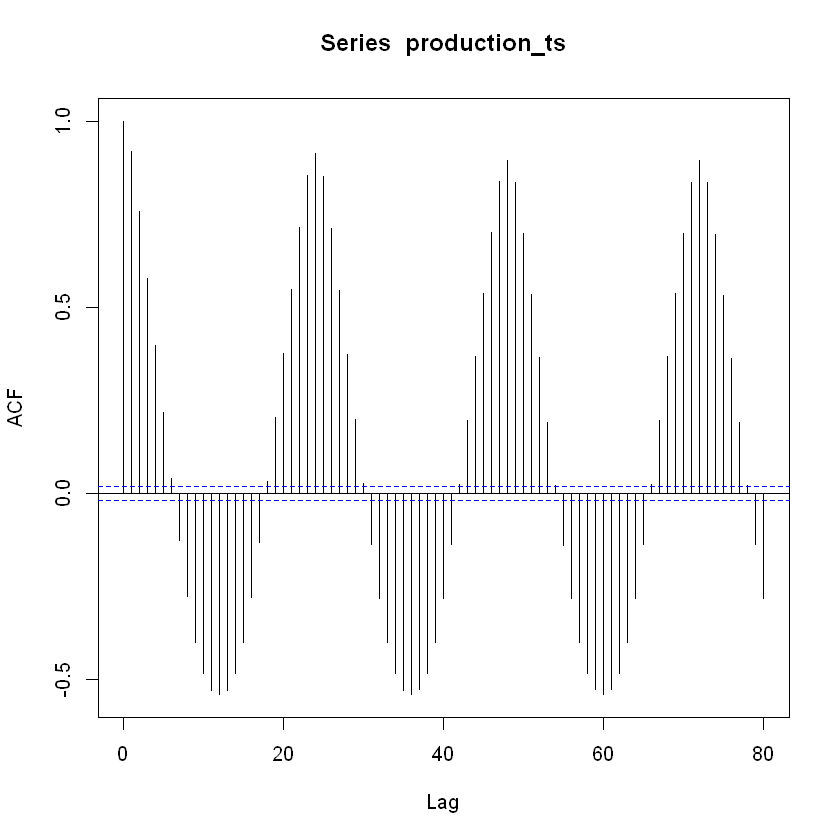


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 13 lags. 

Value of test-statistic is: 4e-04 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 13 lags. 

Value of test-statistic is: 0.5338 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


NULL

[1]  2.1094228  2.0758037  2.0821502  2.0206179  1.9973345  1.9961710
  [7]  2.0247595  2.1290292  2.0133221  2.0292418  1.9966066  2.0628020
 [13]  1.9881254  2.0199424  2.1152483  2.0948693  1.9972928  2.1287994
 [19]  1.9527260  1.8315360  1.8096633  1.8035354  1.8441188  1.7735650
 [25]  1.7118566  1.7208991  1.7248062  1.6905394  1.9333946  1.9523070
 [31]  1.6275469  1.6157695  1.6717872  1.6017146  1.6258962  1.9078349
 [37]  1.6146888  1.7413192  1.6531638  1.6520908  2.0531311  2.0151484
 [43]  1.7512796  1.8123819  1.7431198  1.7069013  1.6338615  1.5454681
 [49]  1.6481505  2.0276756  1.7271933  1.6278981  1.6043413  1.3654331
 [55]  1.3584395  1.3314281  1.4544248  1.6656874  1.9055733  1.5377598
 [61]  1.2952437  1.6824922  1.7413833  1.1481842  0.9794539  0.7479417
 [67]  1.6956800  1.8540285  1.3024147 -0.3135221 -0.3970382  0.7610432
 [73]  1.1059806  1.2851143  1.5544781  1.3134845  1.5592399  1.2666386
 [79] -0.8120808 -0.8058733 -0.7525134  1.0955440  1.0641983  0.9634119
 [85] -0.7986987  1.1443524  1.4035967  1.3536357  0.5929289  0.6725906
 [91]  1.2118035  1.1551217  1.2085024  0.7662743 -1.1372637 -0.9386875
 [97] -1.2912182 -1.0224191 -0.9552896 -1.3590433 -1.5863925 -1.5895952
[103] -1.5820206 -1.3435266 -1.4834485 -1.3951514 -1.4329394 -1.5200285
[109] -1.5964746 -1.0927453 -1.4036972 -1.6869441 -1.5769600 -1.4282466
[115] -0.9245982 -1.6838417 -1.6479806 -1.4175037 -1.5924565 -1.6404903
[121] -1.4922479 -1.6500640 -1.8217617 -1.2818452 -1.7352208 -1.7193795
[127] -1.6109392 -1.5484557 -1.4986972 -1.4669863 -0.9591473 -1.5815904
[133] -1.6340371 -1.5394598 -1.4177559 -1.7303337 -1.7092519 -1.7496286
[139] -1.8528227 -1.8016559 -1.7885597 -1.7149991 -1.4115236 -1.8935401
[145] -1.8429614 -1.8351425 -1.8476780 -1.9073801 -1.8984141 -1.8802102
[151] -1.8532090 -1.8305968 -1.8250720 -1.7020479 -1.5379845 -1.9051860
[157] -1.8258639 -1.6033844 -1.9128102 -1.8831698 -1.6586685 -1.7296887
[163] -1.7983508 -1.8193373 -1.8792098 -1.8549887 -1.8756063 -1.8922551
[169] -1.8672386 -1.6527534 -1.5521829 -1.8762890 -1.8634845 -1.7820451
[175] -1.6341152 -1.8885746 -1.8935342 -1.2982156 -1.8735553 -1.8505032
[181] -1.8470317 -1.8427466 -1.8237340 -1.8013179 -1.7840820  0.5913594
[187] -1.6398205 -1.6972043 -1.6788915 -1.5785281 -1.7409241 -1.8182107
[193] -1.8018676 -1.8389021 -1.8430718 -1.8262575 -1.8000456 -1.7708133
[199] -1.7520549 -1.7567148 -1.7531927 -1.7335390 -1.7527712 -1.7545805
[205] -1.7372815 -1.7251369 -1.7357931 -1.7374476 -1.7413215 -1.7315820
[211] -1.7354296 -1.7234350 -1.6771392 -1.7824564 -1.7543951 -1.7181693
[217] -1.7209574 -1.7200435 -1.7067088 -1.6737051 -1.4974247 -1.6747822
[223] -1.2107932 -1.6174195 -1.6536333 -0.9647847 -0.7825269 -1.7052454
[229] -1.6552235 -1.6072385 -1.5980882 -1.6026676 -1.3807486  0.6700636
[235] -1.6839873 -1.6623032 -1.6478136 -1.6287599 -1.5973460  0.6399631
[241] -1.0878147 -1.6034951 -1.5889408 -1.6122333 -1.6100449 -1.6011148
[247] -1.5988171 -1.5804541 -1.5652832 -1.5381264 -1.5297079 -1.4664957
[253] -1.4264264  1.2309775  1.1086312 -1.3898079  0.2902527 -1.4205076
[259] -1.2994338 -1.3586635 -1.4198569 -1.4096669 -1.3827470 -1.3758774
[265] -1.2640385 -0.8370813 -1.0599660  1.7356346  1.2516766 -1.1767078
[271]  1.4887734  1.6154475  2.0895404  1.3661516 -0.8499449 -1.1589114
[277] -0.7823417 -1.1293318 -1.1106251 -1.0307938 -0.3830726  1.5783006
[283] -1.1964074 -0.9029589  1.4079786  1.2627179  0.8174002 -0.6175792
[289]  1.0964286  1.7245401  1.8696047  1.2463839  1.2181216  1.5797267
[295]  1.6279453  1.7377345  1.4369443  1.4835257  1.7990923  1.4917502
[301]  1.5212852  1.2459502  1.0440565  0.8397730  1.7069156  1.6579272
[307]  1.7540332  2.0637171  1.9338329  1.9104813  1.3694921  1.8206989
[313]  1.0580369  1.4173843  1.6761044  2.1164349  1.9852046  1.7494913
[319]  2.0538985  1.9325396  2.0432802  1.7503825  1.0627922  1.3245884
[325]  0.9130367  0.9168114  1.6297409  2.0776200  2.0685794  2.0078851
[331]  1.7941268  2.1640548  1.8718549  1.

    Point Forecast     Lo 80      Hi 80     Lo 95     Hi 95
480       -1.38573 -2.435051 -0.3364084 -2.990528 0.2190688

    Point Forecast     Lo 80      Hi 80     Lo 95     Hi 95
480      -1.364519 -2.448593 -0.2804453 -3.022467 0.2934288

    Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
480      0.4723562 -0.7739081 1.718621 -1.433641 2.378353

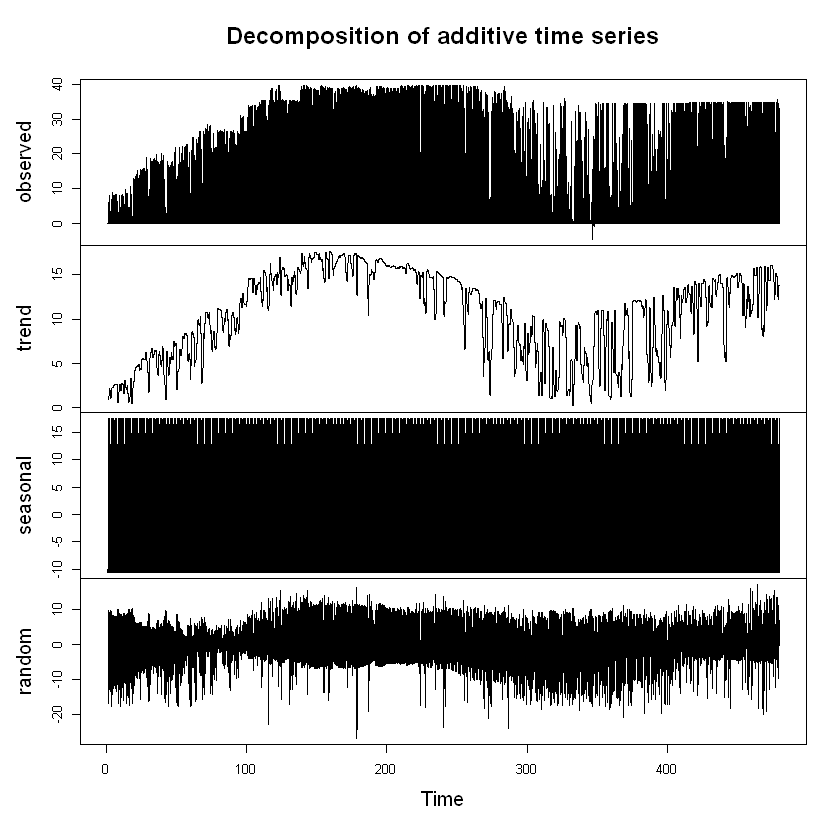

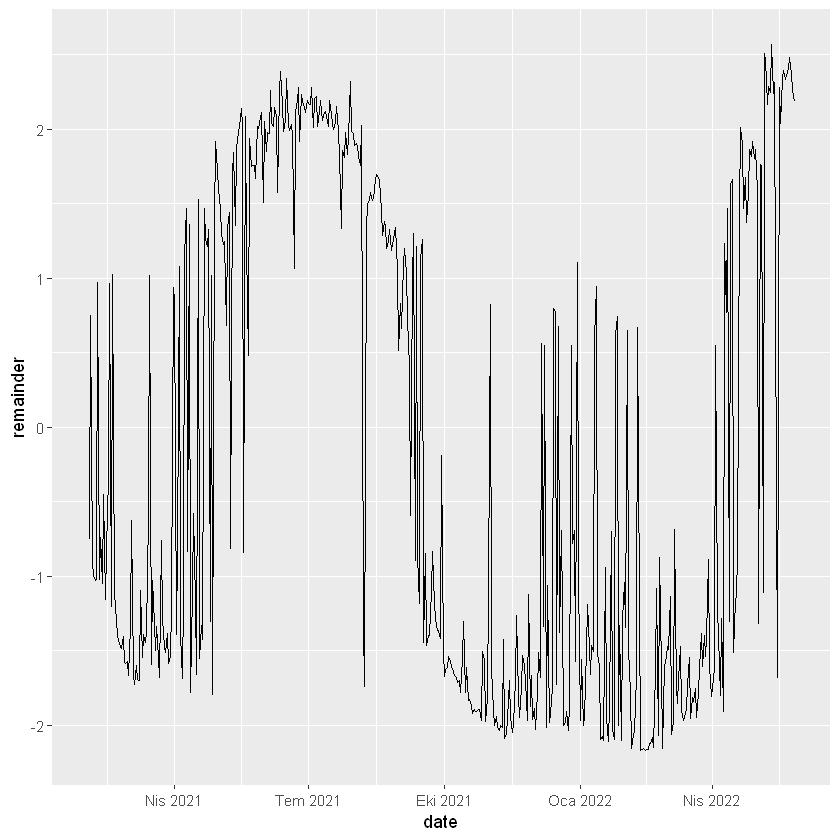

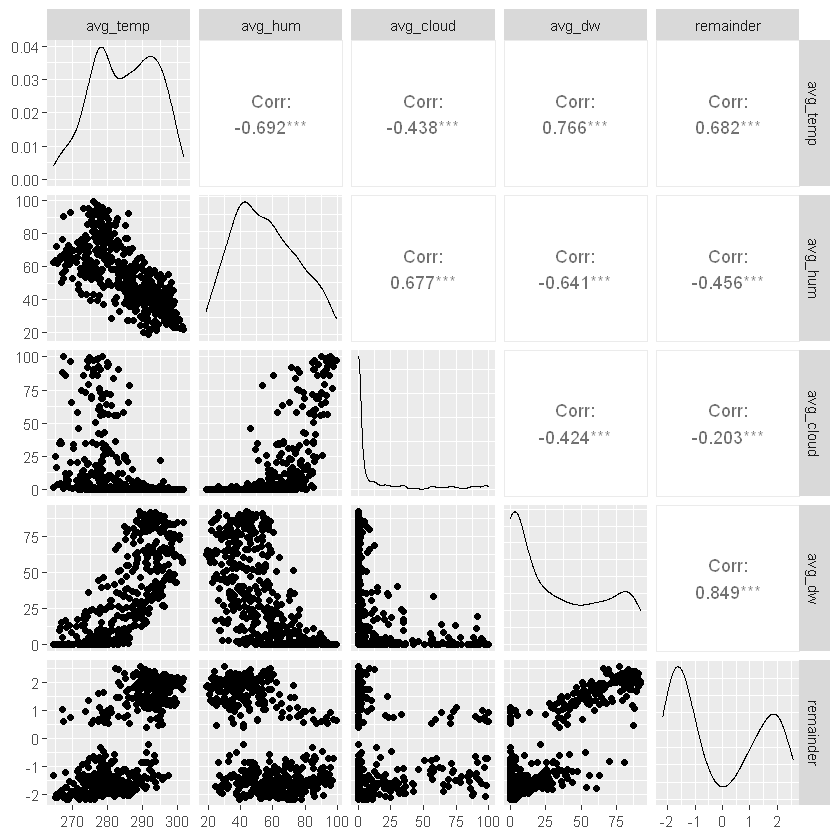

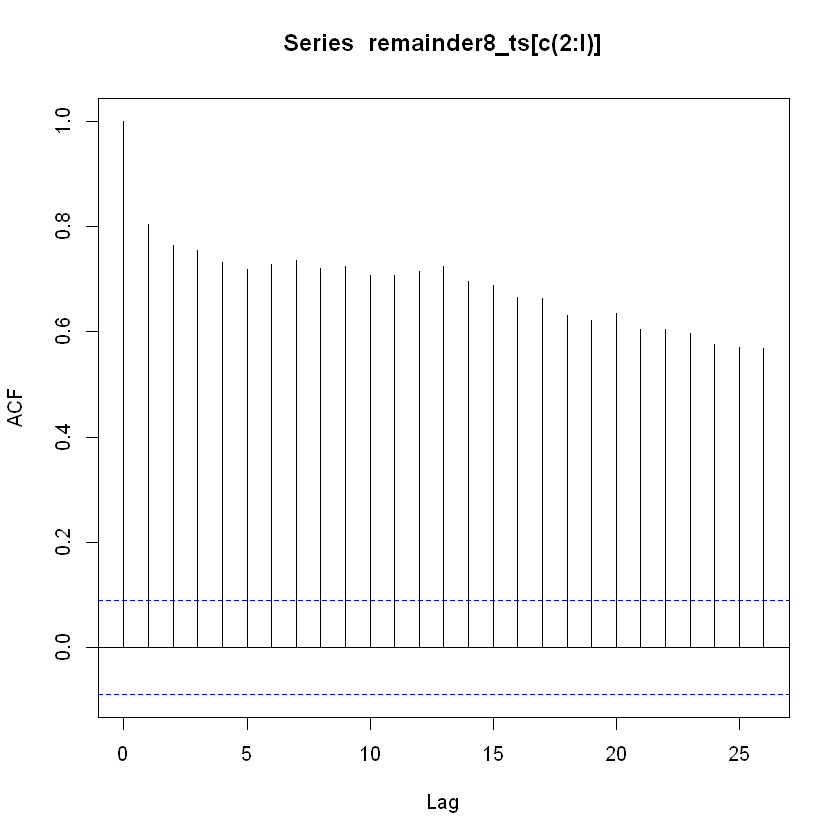


Call:
lm(formula = as.formula(formula8), data = merged8[-nrow(merged8)])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1393 -0.3633 -0.0378  0.3051  2.7821 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -8.039574   2.892119  -2.780 0.005662 ** 
monthAralık     0.430738   0.323837   1.330 0.184142    
monthEkim      -0.492064   0.270573  -1.819 0.069623 .  
monthEylül     -0.237483   0.216106  -1.099 0.272380    
monthHaziran   -1.213884   0.272195  -4.460 1.03e-05 ***
monthKasım     -0.083654   0.302845  -0.276 0.782498    
monthMart      -0.304076   0.291118  -1.045 0.296798    
monthMayıs     -0.944934   0.223982  -4.219 2.96e-05 ***
monthNisan     -0.366397   0.196872  -1.861 0.063369 .  
monthOcak       0.209179   0.343029   0.610 0.542297    
monthŞubat      0.402582   0.316688   1.271 0.204290    
monthTemmuz    -0.564011   0.219361  -2.571 0.010449 *  
avg_temp        0.021057   0.009757   2.158 0.031443 *  
avg_cloud       0.0

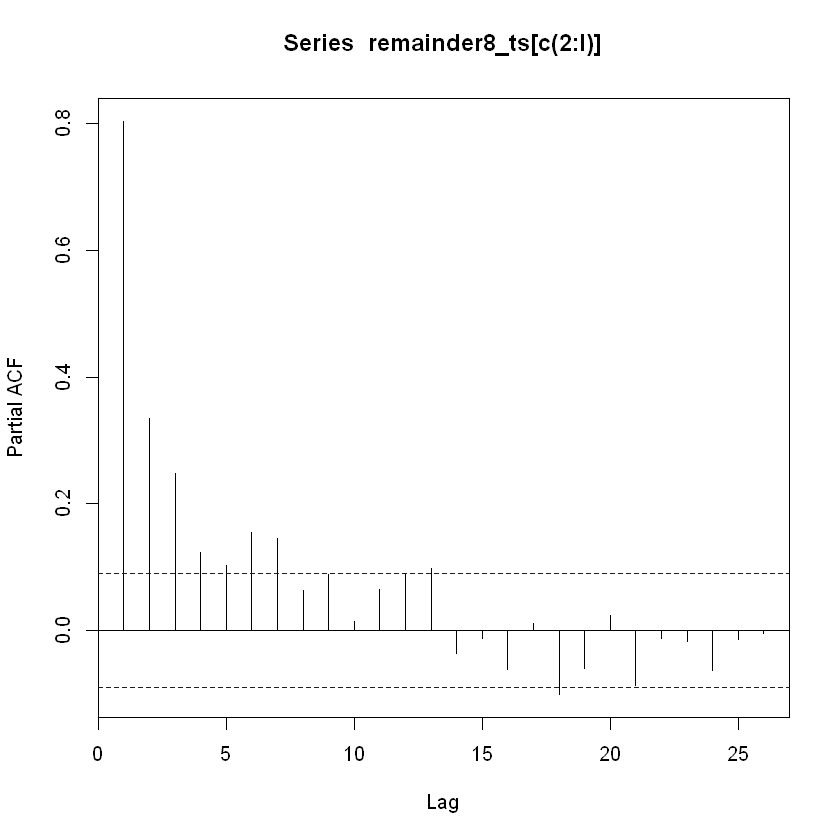


	Breusch-Godfrey test for serial correlation of order up to 20

data:  Residuals
LM test = 43.438, df = 20, p-value = 0.001789


Series: merged8$remainder 
ARIMA(2,1,1) 

Coefficients:
         ar1      ar2      ma1
      0.1526  -0.0140  -0.8248
s.e.  0.0546   0.0513   0.0303

sigma^2 estimated as 0.7253:  log likelihood=-599.2
AIC=1206.41   AICc=1206.49   BIC=1223.08

Training set error measures:
                     ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.02754257 0.8481036 0.5701758 -4.758076 47.09886 0.9728618
                     ACF1
Training set -0.001561357


    Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
480       2.159898 1.011287 3.308509 0.4032495 3.916547

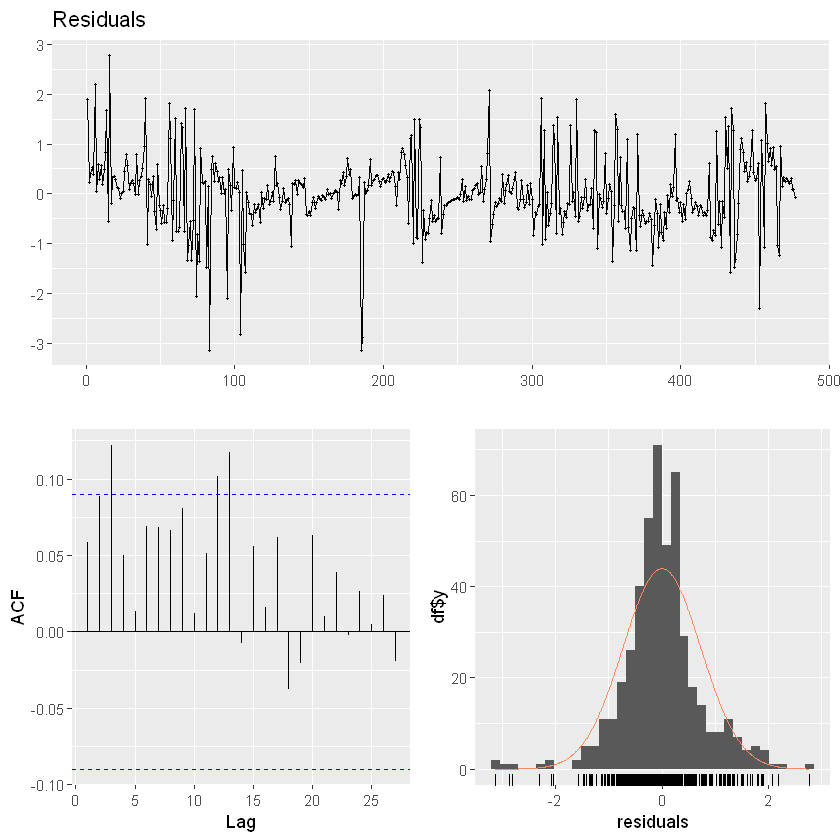

    Point Forecast     Lo 80    Hi 80      Lo 95   Hi 95
480       2.047479 0.7314836 3.363474 0.03483778 4.06012

    Point Forecast      Lo 80    Hi 80     Lo 95   Hi 95
480       1.415814 -0.2640728 3.095702 -1.153351 3.98498

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
480       1.060109 -0.638993 2.759211 -1.538443 3.658662

    Point Forecast      Lo 80  Hi 80     Lo 95    Hi 95
480       1.265581 -0.4123386 2.9435 -1.300575 3.831737

    Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
479       1.122799 -0.5398856 2.785483 -1.420058 3.665655

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
479      0.2388865 -1.443462 1.921235 -2.334044 2.811817

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
479      0.1837807 -1.726962 2.094523 -2.738448 3.106009

    Point Forecast     Lo 80    Hi 80     Lo 95   Hi 95
479      0.2664479 -1.813118 2.346014 -2.913974 3.44687

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
479      0.2340702 -1.675356 2.143496 -2.686145 3.154285

    Point Forecast     Lo 80    Hi 80     Lo 95   Hi 95
479      0.2270494 -1.234941 1.689039 -2.008871 2.46297

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
479      0.1230705 -1.295216 1.541357 -2.046011 2.292152

1         1         1 
 0.000000  0.000000  0.000000  0.000000  0.000000  2.335417  3.494333 12.072039 
        1         1         1         1         1         1         1         1 
35.768393 40.496888 32.722327 31.482204 31.983070 30.891298 29.639826 27.813370 
        1         1         1         1                                         
23.793185 16.969294 10.738282  4.179745  0.000000  0.000000  0.000000  0.000000

[1]  0.000000  0.000000  0.000000  0.000000  0.000000  0.532851  1.820435
 [8] 12.317970 33.771143 38.105872 33.981194 32.551842 33.278897 32.280882
[15] 29.652694 27.736191 23.202080 13.960535  6.308263  3.511235  0.000000
[22]  0.000000  0.000000  0.000000

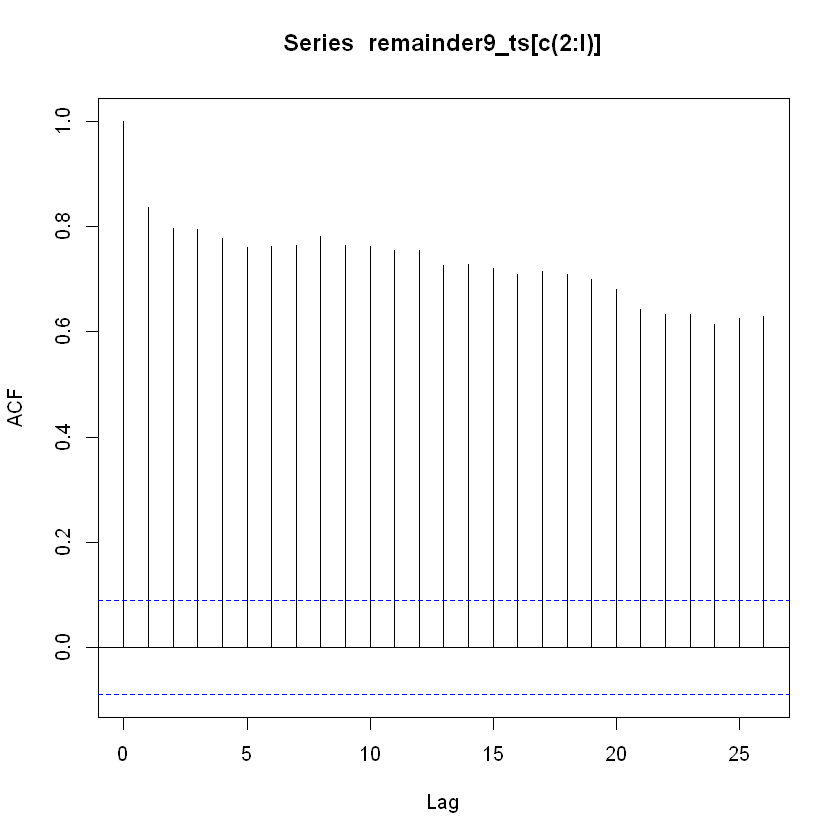

In [25]:
# decomposition
weather <- fread(weather_file)
prod <- fread(production_file)

str(weather)
str(prod)

weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")

weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
prod$date <- as.Date(prod$date, format = "%Y-%m-%d")

merged <- merge(weather, prod, by = c("date","hour"), all = T)
merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
show_na <-merged[rowSums(is.na(merged)) > 0, ]

nrow(show_na)/24
unique(show_na$date)
nrow(merged)/24

merged[,month:=months(as.Date(date))]
for (i in c(0:4,21:23)){
  merged[merged$hour==i]$production=0
}
merged$month=as.factor(merged$month)
merged$hour=as.factor(merged$hour)
days<-unique((as.Date(show_na$date)))

# merged_initial <- copy(merged)
a='production ~ +CLOUD_LOW_LAYER_36.25_33+CLOUD_LOW_LAYER_36.25_33.25+CLOUD_LOW_LAYER_36.25_33.5+CLOUD_LOW_LAYER_36.5_33+CLOUD_LOW_LAYER_36.5_33.25+CLOUD_LOW_LAYER_36.5_33.5+CLOUD_LOW_LAYER_36.75_33+CLOUD_LOW_LAYER_36.75_33.25+CLOUD_LOW_LAYER_36.75_33.5+DSWRF_36.25_33+DSWRF_36.25_33.25+DSWRF_36.25_33.5+DSWRF_36.5_33+DSWRF_36.5_33.25+DSWRF_36.5_33.5+DSWRF_36.75_33+DSWRF_36.75_33.25+DSWRF_36.75_33.5+REL_HUMIDITY_36.25_33+REL_HUMIDITY_36.25_33.25+REL_HUMIDITY_36.25_33.5+REL_HUMIDITY_36.5_33+REL_HUMIDITY_36.5_33.25+REL_HUMIDITY_36.5_33.5+REL_HUMIDITY_36.75_33+REL_HUMIDITY_36.75_33.25+REL_HUMIDITY_36.75_33.5+TEMP_36.25_33+TEMP_36.25_33.25+TEMP_36.25_33.5+TEMP_36.5_33+TEMP_36.5_33.25+TEMP_36.5_33.5+TEMP_36.75_33+TEMP_36.75_33.25+TEMP_36.75_33.5+month'
for (i in 5:20){
  for (j in days[c(-1,-length(days))]){
    df=merged %>% filter(hour == i , as.Date(date )< as.Date(j))
    fit_<- lm(as.formula(a),df)
    merged[(merged$date==as.Date(j))&(merged$hour==i)]$production=predict(fit_,newdata=merged[(merged$date==as.Date(j))&(merged$hour==i)])
  }
}

merged <- merged[date != '2021-02-20']

merged[,month:=months(as.Date(date))]
merged$month=as.factor(merged$month)
merged$hour=as.factor(merged$hour)
merged[,trend:=ceiling((1:.N)/24)]
merged[,avg_temp:=rowMeans(merged[,c(30:38)])]
merged[,avg_hum:=rowMeans(merged[,c(21:29)])]
merged[,avg_cloud:=rowMeans(merged[,c(3:11)])]
merged[,avg_dw:=rowMeans(merged[,c(12:20)])]

library(glue)
for (i in 0:23){
  command_str = glue('merged{i} = merged[merged$hour=={i}]')
  eval(parse(text=command_str))
}
#head(merged13)
show_na13 <-merged13[rowSums(is.na(merged13)) > 0, ]


nthroot<-function(x, n){
  sign(x)*abs(x)^(1/n)
}

predictDecomposed <- function(remainder_pred, hour, decomposed){
  trend_component <- NA
  i <- length(decomposed$trend)
  while(1){
    if (!as.logical(is.na(decomposed$trend[i]))){
      trend_component <- decomposed$trend[i]
      break
    }
    i <- i-1
  }
  seasonal_component <- unique(decomposed$seasonal)[hour+1]
  overall_prediction <- trend_component + seasonal_component + remainder_pred
  return (overall_prediction)
}


# decomposition of all data (before the split wrt hours)
l <- nrow(merged) -24
production_ts <- ts(merged[1:l]$production)
acf(production_ts, lag.max=80)
#merged_ts<-ts(merged[1:l]$production, freq=24)
length(merged_ts)/24
merged_decomposed_additive = decompose(merged_ts,type="additive")
#merged_decomposed_additive
plot(merged_decomposed_additive)

remainders <- merged_decomposed_additive$random
unt_test=ur.kpss(remainders) 
summary(unt_test)
unt_test=ur.kpss(nthroot(remainders,3)) 
summary(unt_test)
remainders <- nthroot(remainders, 3)

# separate the remainders into hours
for (h in 0:23){
  command_str = glue("remainder{h} <- c()")
  eval(parse(text=command_str))
}

for (i in 0:length(remainders)){
  h = i%%24
  command_str = glue("remainder{h} <- append(remainder{h}, remainders[i])")
  eval(parse(text=command_str))
}
for (h in 0:23){
  command_str = glue("remainder{h} <- append(remainder{h}, NA)")
  eval(parse(text=command_str))
}

# add remainders as columns to the dataframes separated by hours
for (h in 0:23){
  command_str = glue("merged{h}[,remainder:=remainder{h}]")
  eval(parse(text=command_str))
}

# models and predictions

forecast_decomp_lm <- c(0, 0, 0, 0, 0)
forecast_decomp_arima <- c(0, 0, 0, 0, 0)

# hour = 5
#regression
#ggplot(merged5, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged5, columns=c(42:46))


remainder5_ts <- ts(remainder5[c(1:length(remainder5)-1)])
l <- length(remainder5) - 1
#acf(remainder5_ts[c(2:l)])
#pacf(remainder5_ts[c(2:l)])
merged5[,lag1_remainder:=shift(remainder,type="lag",n=1)]

formula5 = 'remainder ~ month + avg_temp + avg_cloud + lag1_remainder'

fit5<- lm(as.formula(formula5),merged5[-nrow(merged5)])
#summary(fit5)
#checkresiduals(fit5)

r_regression_5 <- predict(fit5,merged5[nrow(merged5)])^3
pred <- predictDecomposed(r_regression_5, 5, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_5 <- auto.arima(merged5$remainder)
#summary(auto_arima_5)
r_arima_5=forecast(auto_arima_5,h=1)
r_arima_5
pred <- predictDecomposed((r_arima_5$mean)^3, 5, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 6
#regression
#ggplot(merged6, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged6, columns=c(42:46))


remainder6_ts <- ts(remainder6[c(1:length(remainder6)-1)])
l <- length(remainder6) - 1
#acf(remainder6_ts[c(2:l)])
#pacf(remainder6_ts[c(2:l)])
merged6[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged6[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged6[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula6 = 'remainder ~ month + avg_temp + avg_cloud + avg_hum + lag1_remainder'

fit6<- lm(as.formula(formula6),merged6[-nrow(merged6)])
#summary(fit6)
#checkresiduals(fit6)

r_regression_6 <- predict(fit6,merged6[nrow(merged6)])^3
pred <- predictDecomposed(r_regression_6, 6, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_6 <- auto.arima(merged6$remainder)
#summary(auto_arima_6)
r_arima_6=forecast(auto_arima_6,h=1)
r_arima_6
pred <- predictDecomposed((r_arima_6$mean)^3, 6, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 7
#regression
#ggplot(merged7, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged7, columns=c(42:46))


remainder7_ts <- ts(remainder7[c(1:length(remainder7)-1)])
l <- length(remainder7) - 1
#acf(remainder7_ts[c(2:l)])
#pacf(remainder7_ts[c(2:l)])
merged7[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged7[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged7[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula7 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw + lag1_remainder'

fit7<- lm(as.formula(formula7),merged7[-nrow(merged7)])
#summary(fit7)
#checkresiduals(fit7)

r_regression_7 <- predict(fit7,merged7[nrow(merged7)])^3
pred <- predictDecomposed(r_regression_7, 7, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_7 <- auto.arima(merged7$remainder)
#summary(auto_arima_7)
r_arima_7=forecast(auto_arima_7,h=1)
r_arima_7
pred <- predictDecomposed((r_arima_7$mean)^3, 7, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 8
#regression
ggplot(merged8, aes(x=date, y=remainder))+geom_line()
ggpairs(data=merged8, columns=c(42:46))


remainder8_ts <- ts(remainder8[c(1:length(remainder8)-1)])
l <- length(remainder8) - 1
acf(remainder8_ts[c(2:l)])
pacf(remainder8_ts[c(2:l)])
merged8[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged8[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged8[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula8 = 'remainder ~ month + avg_temp + avg_cloud + avg_hum + avg_dw + lag1_remainder'

fit8<- lm(as.formula(formula8),merged8[-nrow(merged8)])
summary(fit8)
checkresiduals(fit8)

r_regression_8 <- predict(fit8,merged8[nrow(merged8)])^3
pred <- predictDecomposed(r_regression_8, 8, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_8 <- auto.arima(merged8$remainder)
summary(auto_arima_8)
r_arima_8=forecast(auto_arima_8,h=1)
r_arima_8
pred <- predictDecomposed((r_arima_8$mean)^3, 8, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 9
#regression
#ggplot(merged9, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged9, columns=c(42:46))



remainder9_ts <- ts(remainder9[c(1:length(remainder9)-1)])
l <- length(remainder9) - 1
#acf(remainder9_ts[c(2:l)])
#pacf(remainder9_ts[c(2:l)])
merged9[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged9[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged9[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula9 = 'remainder ~ month + avg_temp + avg_dw + lag1_remainder'

fit9<- lm(as.formula(formula9),merged9[-nrow(merged9)])
#summary(fit9)
#checkresiduals(fit9)

r_regression_9 <- predict(fit9,merged9[nrow(merged9)])^3
pred <- predictDecomposed(r_regression_9, 9, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_9 <- auto.arima(merged9$remainder)
#summary(auto_arima_9)
r_arima_9=forecast(auto_arima_9,h=1)
r_arima_9
pred <- predictDecomposed((r_arima_9$mean)^3, 9, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 10
#regression
#ggplot(merged10, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged10, columns=c(42:46))



remainder10_ts <- ts(remainder10[c(1:length(remainder10)-1)])
l <- length(remainder10) - 1
#acf(remainder10_ts[c(2:l)])
#pacf(remainder10_ts[c(2:l)])
merged10[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged10[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged10[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula10 = 'remainder ~ month + avg_temp + avg_dw + lag1_remainder'

fit10<- lm(as.formula(formula10),merged10[-nrow(merged10)])
#summary(fit10)
#checkresiduals(fit10)

r_regression_10 <- predict(fit10,merged10[nrow(merged10)])^3
pred <- predictDecomposed(r_regression_10, 10, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_10 <- auto.arima(merged10$remainder)
#summary(auto_arima_10)
r_arima_10=forecast(auto_arima_10,h=1)
r_arima_10
pred <- predictDecomposed((r_arima_10$mean)^3, 10, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 11
#regression
#ggplot(merged11, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged11, columns=c(42:46))



remainder11_ts <- ts(remainder11[c(1:length(remainder11)-1)])
l <- length(remainder11) - 1
#acf(remainder11_ts[c(2:l)])
#pacf(remainder11_ts[c(2:l)])
merged11[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged11[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged11[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula11 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw + lag1_remainder + lag2_remainder + lag3_remainder'

fit11<- lm(as.formula(formula11),merged11[-nrow(merged11)])
#summary(fit11)
#checkresiduals(fit11)

r_regression_11 <- predict(fit11,merged11[nrow(merged11)])^3
pred <- predictDecomposed(r_regression_11, 11, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_11 <- auto.arima(merged11$remainder)
#summary(auto_arima_11)
r_arima_11=forecast(auto_arima_11,h=1)
r_arima_11
pred <- predictDecomposed((r_arima_11$mean)^3, 11, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 12
#regression
#ggplot(merged12, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged12, columns=c(42:46))



remainder12_ts <- ts(remainder12[c(1:length(remainder12)-1)])
l <- length(remainder12) - 1
#acf(remainder12_ts[c(2:l)])
#pacf(remainder12_ts[c(2:l)])
merged12[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged12[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged12[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula12 = 'remainder ~ month + avg_temp + avg_cloud + lag1_remainder + lag2_remainder + lag3_remainder'

fit12<- lm(as.formula(formula12),merged12[-nrow(merged12)])
#summary(fit12)
#checkresiduals(fit12)

r_regression_12 <- predict(fit12,merged12[nrow(merged12)])^3
pred <- predictDecomposed(r_regression_12, 12, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_12 <- auto.arima(merged12$remainder)
#summary(auto_arima_12)
r_arima_12=forecast(auto_arima_12,h=1)
r_arima_12
pred <- predictDecomposed((r_arima_12$mean)^3, 12, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 13
#regression
#ggplot(merged13, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged13, columns=c(42:46))

formula13 = 'remainder ~ month + avg_temp + avg_cloud + avg_hum + avg_dw'
formula13 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw'

remainder13_ts <- ts(remainder13[c(1:length(remainder13)-1)])
l <- length(remainder13) - 2
#acf(remainder13_ts[c(2:l)])
#pacf(remainder13_ts[c(2:l)])

merged13[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged13[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged13[,lag3_remainder:=shift(remainder,type="lag",n=3)]
merged13[,lag4_remainder:=shift(remainder,type="lag",n=4)]
merged13[,lag5_remainder:=shift(remainder,type="lag",n=5)]


formula13 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw'

fit13<- lm(as.formula(formula13),merged13[-nrow(merged13)])
#summary(fit13)
#checkresiduals(fit13)

r_regression_13 <- predict(fit13,merged13[nrow(merged13)])^3
pred <- predictDecomposed(r_regression_13, 13, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_13 <- auto.arima(merged13$remainder)
#summary(auto_arima_13)
r_arima_13=forecast(auto_arima_13,h=1)
r_arima_13
pred <- predictDecomposed((r_arima_13$mean)^3, 13, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)


# hour = 14
#regression
#ggplot(merged14, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged14, columns=c(42:46))



remainder14_ts <- ts(remainder14[c(1:length(remainder14)-1)])
l <- length(remainder14) - 2
#acf(remainder14_ts[c(2:l)])
#pacf(remainder14_ts[c(2:l)])
merged14[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged14[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged14[,lag3_remainder:=shift(remainder,type="lag",n=3)]


formula14 = 'remainder ~ month + avg_temp + avg_hum + avg_dw'

fit14<- lm(as.formula(formula14),merged14[-nrow(merged14)])
#summary(fit14)
#checkresiduals(fit14)

r_regression_14 <- predict(fit14,merged14[nrow(merged14)])^3
pred <- predictDecomposed(r_regression_14, 14, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_14 <- auto.arima(merged14$remainder)
#summary(auto_arima_14)
r_arima_14=forecast(auto_arima_14,h=1)
r_arima_14
pred <- predictDecomposed((r_arima_14$mean)^3, 14, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 15
#regression
#ggplot(merged15, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged15, columns=c(42:46))


remainder15_ts <- ts(remainder15[c(1:length(remainder15)-1)])
l <- length(remainder15) - 2
#acf(remainder15_ts[c(2:l)])
#pacf(remainder15_ts[c(2:l)])
merged15[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged15[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged15[,lag3_remainder:=shift(remainder,type="lag",n=3)]


formula15 = 'remainder ~ month + avg_dw + avg_temp + avg_hum + avg_dw*avg_temp'

fit15<- lm(as.formula(formula15),merged15[-nrow(merged15)])
#summary(fit15)
#checkresiduals(fit15)

r_regression_15 <- predict(fit15,merged15[nrow(merged15)])^3
pred <- predictDecomposed(r_regression_15, 15, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_15 <- auto.arima(merged15$remainder)
#summary(auto_arima_15)
r_arima_15=forecast(auto_arima_15,h=1)
r_arima_15
pred <- predictDecomposed((r_arima_15$mean)^3, 15, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 16
#regression
#ggplot(merged16, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged16, columns=c(42:46))


remainder16_ts <- ts(remainder16[c(1:length(remainder16)-1)])
l <- length(remainder16) - 2
#acf(remainder16_ts[c(2:l)])
#pacf(remainder16_ts[c(2:l)])
merged16[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged16[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged16[,lag3_remainder:=shift(remainder,type="lag",n=3)]


formula16 = 'remainder ~ month + avg_dw + avg_hum*avg_temp'

fit16<- lm(as.formula(formula16),merged16[-nrow(merged16)])
#summary(fit16)
#checkresiduals(fit16)

r_regression_16 <- predict(fit16,merged16[nrow(merged16)])^3
pred <- predictDecomposed(r_regression_16, 16, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_16 <- auto.arima(merged16$remainder)
#summary(auto_arima_16)
r_arima_16=forecast(auto_arima_16,h=1)
r_arima_16
pred <- predictDecomposed((r_arima_16$mean)^3, 16, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 17
#regression
#ggplot(merged17, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged17, columns=c(42:46))


remainder17_ts <- ts(remainder17[c(1:length(remainder17)-1)])
l <- length(remainder17) - 2
#acf(remainder17_ts[c(2:l)])
#pacf(remainder17_ts[c(2:l)])
merged17[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged17[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged17[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula17 = 'remainder ~ month + poly(avg_dw,2)'

fit17<- lm(as.formula(formula17),merged17[-nrow(merged17)])
#summary(fit17)
#checkresiduals(fit17)

r_regression_17 <- predict(fit17,merged17[nrow(merged17)])^3
pred <- predictDecomposed(r_regression_17, 17, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_17 <- auto.arima(merged17$remainder)
#summary(auto_arima_17)
r_arima_17=forecast(auto_arima_17,h=1)
r_arima_17
pred <- predictDecomposed((r_arima_17$mean)^3, 17, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 18
#regression
#ggplot(merged18, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged18, columns=c(42:46))



remainder18_ts <- ts(remainder18[c(1:length(remainder18)-1)])
l <- length(remainder18) - 2
#acf(remainder18_ts[c(2:l)])
#pacf(remainder18_ts[c(2:l)])
merged18[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged18[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged18[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula18 = 'remainder ~ month + avg_temp + avg_hum + avg_temp*avg_hum + poly(avg_dw,2)'

fit18<- lm(as.formula(formula18),merged18[-nrow(merged18)])
#summary(fit18)
#checkresiduals(fit18)

r_regression_18 <- predict(fit18,merged18[nrow(merged18)])^3
pred <- predictDecomposed(r_regression_18, 18, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_18 <- auto.arima(merged18$remainder)
#summary(auto_arima_18)
r_arima_18=forecast(auto_arima_18,h=1)
r_arima_18
pred <- predictDecomposed((r_arima_18$mean)^3, 18, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

# hour = 19
#regression
#ggplot(merged19, aes(x=date, y=remainder))+geom_line()
#ggpairs(data=merged19, columns=c(42:46))



remainder19_ts <- ts(remainder19[c(1:length(remainder19)-1)])
l <- length(remainder19) - 2
#acf(remainder19_ts[c(2:l)])
#pacf(remainder19_ts[c(2:l)])
merged19[,lag1_remainder:=shift(remainder,type="lag",n=1)]
merged19[,lag2_remainder:=shift(remainder,type="lag",n=2)]
merged19[,lag3_remainder:=shift(remainder,type="lag",n=3)]

formula19 = 'remainder ~ month + avg_temp + avg_cloud + poly(avg_hum,2) + avg_dw*avg_cloud'

fit19<- lm(as.formula(formula19),merged19[-nrow(merged19)])
#summary(fit19)
#checkresiduals(fit19)

r_regression_19 <- predict(fit19,merged19[nrow(merged19)])^3
pred <- predictDecomposed(r_regression_19, 19, merged_decomposed_additive)
forecast_decomp_lm <- append(forecast_decomp_lm, pred)

# arima
auto_arima_19 <- auto.arima(merged19$remainder)
#summary(auto_arima_19)
r_arima_19=forecast(auto_arima_19,h=1)
r_arima_19
pred <- predictDecomposed((r_arima_19$mean)^3, 19, merged_decomposed_additive)
forecast_decomp_arima <- append(forecast_decomp_arima, pred)

forecast_decomp_lm <- append(forecast_decomp_lm, c(0, 0, 0, 0))
forecast_decomp_arima <- append(forecast_decomp_arima, c(0, 0, 0, 0))

forecast_decomp_lm
forecast_decomp_arima

# 6- Results of all Models


In [29]:


todays_date = as.Date("2022-05-26")
weather_file='2022-05-26_weather.csv'
production_file='2022-05-26_production.csv'

# linear regression for separate hours
LinearRegression_Separated <- function(todays_date, weather_file, production_file){
  
  weather <- fread(weather_file)
  prod <- fread(production_file)
  
  # linear regression for each hour
  weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")
  
  weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
  prod$date <- as.Date(prod$date, format = "%Y-%m-%d")
  
  merged <- merge(weather, prod, by = c("date","hour"), all = T)
  merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
  show_na <-merged[rowSums(is.na(merged)) > 0, ]
  
  merged[,month:=months(as.Date(date))]
  for (i in c(0:4,21:23)){
    merged[merged$hour==i]$production=0
  }
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  days<-unique((as.Date(show_na$date)))
  
  # missing data imputation
  a='production ~ +CLOUD_LOW_LAYER_36.25_33+CLOUD_LOW_LAYER_36.25_33.25+CLOUD_LOW_LAYER_36.25_33.5+CLOUD_LOW_LAYER_36.5_33+CLOUD_LOW_LAYER_36.5_33.25+CLOUD_LOW_LAYER_36.5_33.5+CLOUD_LOW_LAYER_36.75_33+CLOUD_LOW_LAYER_36.75_33.25+CLOUD_LOW_LAYER_36.75_33.5+DSWRF_36.25_33+DSWRF_36.25_33.25+DSWRF_36.25_33.5+DSWRF_36.5_33+DSWRF_36.5_33.25+DSWRF_36.5_33.5+DSWRF_36.75_33+DSWRF_36.75_33.25+DSWRF_36.75_33.5+REL_HUMIDITY_36.25_33+REL_HUMIDITY_36.25_33.25+REL_HUMIDITY_36.25_33.5+REL_HUMIDITY_36.5_33+REL_HUMIDITY_36.5_33.25+REL_HUMIDITY_36.5_33.5+REL_HUMIDITY_36.75_33+REL_HUMIDITY_36.75_33.25+REL_HUMIDITY_36.75_33.5+TEMP_36.25_33+TEMP_36.25_33.25+TEMP_36.25_33.5+TEMP_36.5_33+TEMP_36.5_33.25+TEMP_36.5_33.5+TEMP_36.75_33+TEMP_36.75_33.25+TEMP_36.75_33.5+month'
  for (i in 5:20){
    for (j in days[c(-1,-length(days))]){
      df=merged %>% filter(hour == i , as.Date(date )< as.Date(j))
      fit_<- lm(as.formula(a),df)
      merged[(merged$date==as.Date(j))&(merged$hour==i)]$production=predict(fit_,newdata=merged[(merged$date==as.Date(j))&(merged$hour==i)])
    }
  }
  
  # add columns
  merged[,month:=months(as.Date(date))]
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  merged[,trend:=ceiling((1:.N)/24)]
  merged[,avg_temp:=rowMeans(merged[,c(30:38)])]
  merged[,avg_hum:=rowMeans(merged[,c(21:29)])]
  merged[,avg_cloud:=rowMeans(merged[,c(3:11)])]
  merged[,avg_dw:=rowMeans(merged[,c(12:20)])]
  
  # separation of data into hours
  for (i in 0:23){
    value <- merged[hour==i]
    x <- paste("merged",i, sep="")
    eval(call("<-", as.name(x), value))
  }
  
  addWindow <- function(col, type, m){
    if (type=="moving_average"){
      arr<-rollmean(col,m,align='right') 
      arr=c(rep(NA,m-1),arr) 
    }
    else if(type=="max_capacity"){
      arr<-rollmax(col,m,align='right') 
      arr=c(rep(NA,m-1),arr) 
    }
    arr[length(arr)] <- arr[length(arr)-1]
    return (arr)
  }
  merged5$ma_y = addWindow(merged5$production, type="moving_average", m=3)
  merged5$max_capacity = addWindow(merged5$production, type="max_capacity", m=7)
  merged6$ma_y = addWindow(merged6$production, type="moving_average", m=3)
  merged6$max_capacity = addWindow(merged6$production, type="max_capacity", m=7)
  merged7$ma_y = addWindow(merged7$production, type="moving_average", m=3)
  merged7$max_capacity = addWindow(merged7$production, type="max_capacity", m=7)
  merged8$ma_y = addWindow(merged8$production, type="moving_average", m=3)
  merged8$max_capacity = addWindow(merged8$production, type="max_capacity", m=7)
  merged9$ma_y = addWindow(merged9$production, type="moving_average", m=3)
  merged9$max_capacity = addWindow(merged9$production, type="max_capacity", m=7)
  merged10$ma_y = addWindow(merged10$production, type="moving_average", m=3)
  merged10$max_capacity = addWindow(merged10$production, type="max_capacity", m=7)
  merged11$ma_y = addWindow(merged11$production, type="moving_average", m=3)
  merged11$max_capacity = addWindow(merged11$production, type="max_capacity", m=7)
  merged12$ma_y = addWindow(merged12$production, type="moving_average", m=3)
  merged12$max_capacity = addWindow(merged12$production, type="max_capacity", m=7)
  merged13$ma_y = addWindow(merged13$production, type="moving_average", m=3)
  merged13$max_capacity = addWindow(merged13$production, type="max_capacity", m=7)
  merged14$ma_y = addWindow(merged14$production, type="moving_average", m=3)
  merged14$max_capacity = addWindow(merged14$production, type="max_capacity", m=7)
  merged15$ma_y = addWindow(merged15$production, type="moving_average", m=3)
  merged15$max_capacity = addWindow(merged15$production, type="max_capacity", m=7)
  merged16$ma_y = addWindow(merged16$production, type="moving_average", m=3)
  merged16$max_capacity = addWindow(merged16$production, type="max_capacity", m=7)
  merged17$ma_y = addWindow(merged17$production, type="moving_average", m=3)
  merged17$max_capacity = addWindow(merged17$production, type="max_capacity", m=7)
  merged18$ma_y = addWindow(merged18$production, type="moving_average", m=3)
  merged18$max_capacity = addWindow(merged18$production, type="max_capacity", m=7)
  merged19$ma_y = addWindow(merged19$production, type="moving_average", m=3)
  merged19$max_capacity = addWindow(merged19$production, type="max_capacity", m=7)
  
  
  merged5[,lag1_y:=shift(production,type="lag",n=1)]
  merged5[,lag14_y:=shift(production,type="lag",n=14)]
  merged6[,lag1_y:=shift(production,type="lag",n=1)]
  merged7[,lag1_y:=shift(production,type="lag",n=1)]
  merged8[,lag1_y:=shift(production,type="lag",n=1)]
  merged9[,lag1_y:=shift(production,type="lag",n=1)]
  merged10[,lag1_y:=shift(production,type="lag",n=1)]
  merged11[,lag1_y:=shift(production,type="lag",n=1)]
  merged12[,lag1_y:=shift(production,type="lag",n=1)]
  merged13[,lag1_y:=shift(production,type="lag",n=1)]
  merged14[,lag1_y:=shift(production,type="lag",n=1)]
  merged15[,lag1_y:=shift(production,type="lag",n=1)]
  merged16[,lag1_y:=shift(production,type="lag",n=1)]
  merged17[,lag1_y:=shift(production,type="lag",n=1)]
  merged18[,lag1_y:=shift(production,type="lag",n=1)]
  merged19[,lag1_y:=shift(production,type="lag",n=1)]
  
  # model building and predictions
  forecast_lm <- c(0, 0, 0, 0, 0)
  
  # hour=5
  forfit5=merged5 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-05-01"))
  formula5='production ~ +max_capacity*trend+avg_cloud+avg_temp+avg_hum+month+lag1_y+lag14_y'
  fit5<- lm(as.formula(formula5),forfit5)
  forecast_lm <- append(forecast_lm, predict(fit5,merged5[nrow(merged5)]))
  
  # hour=6
  forfit6=merged6 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-05-01"))
  formula6='production ~ +max_capacity*trend+avg_cloud+avg_temp+avg_hum+month+ma_y'
  fit6<- lm(as.formula(formula6),forfit6)
  forecast_lm <- append(forecast_lm, predict(fit6,merged6[nrow(merged6)]))
  
  #hour=7
  formula7="production~+I(avg_cloud^2)+I(avg_temp^2)+I(avg_hum^2)+max_capacity*trend+ma_y+month"
  fit7<- lm(as.formula(formula7),merged7)
  forecast_lm <- append(forecast_lm, predict(fit7,merged7[nrow(merged7)]))
  
  #hour=8
  formula8='production ~ +avg_cloud+avg_dw+avg_hum+avg_temp+month+max_capacity*trend+ma_y+lag1_y'
  fit8<- lm(as.formula(formula8),merged8)
  forecast_lm <- append(forecast_lm, predict(fit8,merged8[nrow(merged8)]))
  
  #hour=9
  forfit9=merged9 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-04-01"))
  forfit9[,log_prod:=log(forfit9$production)]
  forfit9[forfit9$production==0]$log_prod=NA
  formula9='log_prod ~+trend +avg_temp+avg_hum+month+ma_y+max_capacity*trend+avg_hum+lag1_y'
  fit9<- lm(as.formula(formula9),forfit9)
  forecast_lm <- append(forecast_lm, exp(predict(fit9,merged9[nrow(merged9)])))
  
  #hour=10
  forfit10=merged10 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2022-04-01"))
  forfit10[,diff_prod:=c(NA,diff(forfit10$production))]
  formula10='diff_prod ~+trend+month+avg_hum+avg_dw+avg_cloud+avg_temp+ma_y'
  fit10<- lm(as.formula(formula10),forfit10)
  forecast_lm <- append(forecast_lm, merged10$production[nrow(merged10)-3] + predict(fit10,merged10[nrow(merged10)]))
  
  #hour=11
  forfit11=merged10 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2022-04-01"))
  forfit11[,diff_prod:=c(NA,diff(forfit11$production))]
  formula11='production ~ma_y+month+avg_temp+avg_hum+avg_cloud+max_capacity+lag1_y'
  fit11<- lm(as.formula(formula11),forfit11)
  forecast_lm <- append(forecast_lm, predict(fit11,merged11[nrow(merged11)]))
  
  #hour=12
  formula12='production ~trend+month+avg_temp+avg_hum+avg_cloud+max_capacity+lag1_y'
  fit12<- lm(as.formula(formula12),merged12)
  forecast_lm <- append(forecast_lm, predict(fit12,merged12[nrow(merged12)]))
  
  #hour=13
  formula13='production ~trend+month+avg_temp+avg_hum+lag1_y+ma_y' 
  fit13 <- lm(as.formula(formula13),merged13)
  forecast_lm <- append(forecast_lm, predict(fit13,merged13[nrow(merged13)]))
  
  #hour=14
  formula14='production ~month+avg_temp+avg_hum+ma_y+avg_temp+avg_dw+lag1_y' 
  fit14 <- lm(as.formula(formula14),merged14)
  forecast_lm <- append(forecast_lm, predict(fit14,merged14[nrow(merged14)]))
  
  #hour=15
  formula15 = 'diff_prod ~ month+avg_hum+ma_y+avg_dw+lag1_y+max_capacity'
  merged15[,diff_prod:=c(NA,diff(merged15$production))]
  fit15<- lm(as.formula(formula15),merged15)
  forecast_lm <- append(forecast_lm, merged15$production[nrow(merged15)-3] + predict(fit15,merged15[nrow(merged15)]))
  
  #hour=16
  formula16='production ~trend+month+avg_temp+lag1_y+ma_y+I(avg_hum^2)+avg_dw+max_capacity*avg_hum' 
  fit16<- lm(as.formula(formula16),merged16)
  forecast_lm <- append(forecast_lm, predict(fit16,merged16[nrow(merged16)]))
  
  #hour=17
  formula17='production ~trend+month+avg_temp+lag1_y+ma_y+I(avg_hum^2)+avg_dw'
  fit17<- lm(as.formula(formula17),merged17)
  forecast_lm <- append(forecast_lm, predict(fit17,merged17[nrow(merged17)]))
  
  #hour=18
  formula18='production ~month+avg_temp+lag1_y+ma_y+avg_dw+I(avg_dw^2)'
  fit18<- lm(as.formula(formula18),merged18)
  forecast_lm <- append(forecast_lm, predict(fit18,merged18[nrow(merged18)]))
  
  #hour=19
  forfit19=merged19 %>% filter( as.Date(date )<todays_date&as.Date(date )>=as.Date("2021-04-01"))
  formula19='production ~month+lag1_y+ma_y'
  fit19<- lm(as.formula(formula19),forfit19)
  forecast_lm <- append(forecast_lm, predict(fit19,merged19[nrow(merged19)]))
  
  forecast_lm <- append(forecast_lm, c(0, 0, 0, 0))
  return(forecast_lm) 
}



# SARIMA for separate hours
SARIMA_Separated <- function(todays_date, production_file){
  
  # SARIMA for each hour
  
  forecast_date=todays_date+1
  
  production=fread(production_file)
  
  latest_available_prod_date=as.Date(max(production$date))
  n_days=as.numeric(forecast_date-latest_available_prod_date)
  
  forecasted_production=tail(production,n_days*24)
  forecasted_production[,date:=date+n_days]
  forecasted_production[,production:=NA]
  
  production_with_forecast=rbind(production,forecasted_production)
  
  # create a template for forecast date
  # forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
  forecast_sarima_sep <- c()
  
  for (i in 0:23){
    value <- production_with_forecast[hour==i]
    x <- paste("prod",i, sep="")
    eval(call("<-", as.name(x), value))
  }
  
  forecast_table[,sarima:=NA]
  forecast_table$sarima=as.numeric(forecast_table$sarima)
  
  for (i in 0:23){
    x <- paste("prod",i, sep="")
    value <- ts(eval(parse( text=paste("prod", i, sep = "")))[!is.na(production)]$production,frequency=30)
    ser<-paste("series_",i, sep="")
    eval(call("<-", as.name(ser), value))
    sarima_model=auto.arima(eval(parse( text=paste("series_", i, sep = ""))),seasonal=T,stepwise=T,approximation=T,trace=T)
    forecast_ahead=nrow(forecast_table)/24
    sarima_forecast=forecast(sarima_model,h=forecast_ahead)
    #forecast_table[hour==i,"sarima"]=as.numeric(format(sarima_forecast$mean,scientific = FALSE))
    forecast_sarima_sep <- append(forecast_sarima_sep, as.numeric(format(sarima_forecast$mean,scientific = FALSE)))
  }
  
  return(forecast_sarima_sep)
}


# SARIMA unseparated 
SARIMA_Unseparated <- function(todays_date, production_file){
  
  production=fread(production_file)
  weather=fread(weather_file)
  forecast_date=todays_date+1
  
  latest_available_prod_date=as.Date(max(production$date))
  n_days=as.numeric(forecast_date-latest_available_prod_date)
  
  forecasted_production=tail(production,n_days*24)
  forecasted_production[,date:=date+n_days]
  forecasted_production[,production:=NA]
  
  production_with_forecast=rbind(production,forecasted_production)
  # forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
  
  production_with_forecast=production_with_forecast[order(date,hour)]
  production_series=ts(production_with_forecast[!is.na(production)]$production,frequency=24)
  
  sarima_model=auto.arima(production_series,seasonal=T,stepwise=T,approximation=T,trace=T)
  
  forecast_ahead=nrow(forecast_table)
  sarima_forecast=forecast(sarima_model,h=forecast_ahead)
  
  forecast_sarima_unsep = as.numeric(format(tail(sarima_forecast$mean,24),scientific = FALSE))
  
  return (forecast_sarima_unsep)
}


Decomposition <- function(todays_date, weather_file, production_file){
  
  # decomposition
  weather <- fread(weather_file)
  prod <- fread(production_file)
  
  weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")
  
  weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
  prod$date <- as.Date(prod$date, format = "%Y-%m-%d")
  
  merged <- merge(weather, prod, by = c("date","hour"), all = T)
  merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
  show_na <-merged[rowSums(is.na(merged)) > 0, ]
  
  merged[,month:=months(as.Date(date))]
  for (i in c(0:4,21:23)){
    merged[merged$hour==i]$production=0
  }
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  days<-unique((as.Date(show_na$date)))
  
  a='production ~ +CLOUD_LOW_LAYER_36.25_33+CLOUD_LOW_LAYER_36.25_33.25+CLOUD_LOW_LAYER_36.25_33.5+CLOUD_LOW_LAYER_36.5_33+CLOUD_LOW_LAYER_36.5_33.25+CLOUD_LOW_LAYER_36.5_33.5+CLOUD_LOW_LAYER_36.75_33+CLOUD_LOW_LAYER_36.75_33.25+CLOUD_LOW_LAYER_36.75_33.5+DSWRF_36.25_33+DSWRF_36.25_33.25+DSWRF_36.25_33.5+DSWRF_36.5_33+DSWRF_36.5_33.25+DSWRF_36.5_33.5+DSWRF_36.75_33+DSWRF_36.75_33.25+DSWRF_36.75_33.5+REL_HUMIDITY_36.25_33+REL_HUMIDITY_36.25_33.25+REL_HUMIDITY_36.25_33.5+REL_HUMIDITY_36.5_33+REL_HUMIDITY_36.5_33.25+REL_HUMIDITY_36.5_33.5+REL_HUMIDITY_36.75_33+REL_HUMIDITY_36.75_33.25+REL_HUMIDITY_36.75_33.5+TEMP_36.25_33+TEMP_36.25_33.25+TEMP_36.25_33.5+TEMP_36.5_33+TEMP_36.5_33.25+TEMP_36.5_33.5+TEMP_36.75_33+TEMP_36.75_33.25+TEMP_36.75_33.5+month'
  for (i in 5:20){
    for (j in days[c(-1,-length(days))]){
      df=merged %>% filter(hour == i , as.Date(date )< as.Date(j))
      fit_<- lm(as.formula(a),df)
      merged[(merged$date==as.Date(j))&(merged$hour==i)]$production=predict(fit_,newdata=merged[(merged$date==as.Date(j))&(merged$hour==i)])
    }
  }
  
  merged <- merged[date != '2021-02-20']
  
  merged[,month:=months(as.Date(date))]
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  merged[,trend:=ceiling((1:.N)/24)]
  merged[,avg_temp:=rowMeans(merged[,c(30:38)])]
  merged[,avg_hum:=rowMeans(merged[,c(21:29)])]
  merged[,avg_cloud:=rowMeans(merged[,c(3:11)])]
  merged[,avg_dw:=rowMeans(merged[,c(12:20)])]
  
  library(glue)
  for (i in 0:23){
    command_str = glue('merged{i} = merged[merged$hour=={i}]')
    eval(parse(text=command_str))
  }
  head(merged13)
  show_na13 <-merged13[rowSums(is.na(merged13)) > 0, ]
  
  nthroot<-function(x, n){
    sign(x)*abs(x)^(1/n)
  }
  
  predictDecomposed <- function(remainder_pred, hour, decomposed){
    trend_component <- NA
    i <- length(decomposed$trend)
    while(1){
      if (!as.logical(is.na(decomposed$trend[i]))){
        trend_component <- decomposed$trend[i]
        break
      }
      i <- i-1
    }
    seasonal_component <- unique(decomposed$seasonal)[hour+1]
    overall_prediction <- trend_component + seasonal_component + remainder_pred
    return (overall_prediction)
  }
  
  # decomposition of all data (before the split wrt hours)
  l <- nrow(merged) -24
  merged_ts<-ts(merged[1:l]$production, freq=24)
  merged_decomposed_additive = decompose(merged_ts,type="additive")
  
  remainders <- merged_decomposed_additive$random
  remainders <- nthroot(remainders, 3)
  
  # separate the remainders into hours
  for (h in 0:23){
    command_str = glue("remainder{h} <- c()")
    eval(parse(text=command_str))
  }
  for (i in 0:length(remainders)){
    h = i%%24
    command_str = glue("remainder{h} <- append(remainder{h}, remainders[i])")
    eval(parse(text=command_str))
  }
  for (h in 0:23){
    command_str = glue("remainder{h} <- append(remainder{h}, NA)")
    eval(parse(text=command_str))
  }
  # add remainders as columns to the dataframes separated by hours
  for (h in 0:23){
    command_str = glue("merged{h}[,remainder:=remainder{h}]")
    eval(parse(text=command_str))
  }
  
  # models and predictions
  forecast_decomp_lm <- c(0, 0, 0, 0, 0)
  forecast_decomp_arima <- c(0, 0, 0, 0, 0)
  
  # hour = 5
  #regression
  merged5[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula5 = 'remainder ~ month + avg_temp + avg_cloud + lag1_remainder'
  fit5<- lm(as.formula(formula5),merged5[-nrow(merged5)])
  r_regression_5 <- predict(fit5,merged5[nrow(merged5)])^3
  pred <- predictDecomposed(r_regression_5, 5, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_5 <- auto.arima(merged5$remainder)
  r_arima_5=forecast(auto_arima_5,h=1)
  pred <- predictDecomposed((r_arima_5$mean)^3, 5, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 6
  #regression
  merged6[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula6 = 'remainder ~ month + avg_temp + avg_cloud + avg_hum + lag1_remainder'
  fit6<- lm(as.formula(formula6),merged6[-nrow(merged6)])
  r_regression_6 <- predict(fit6,merged6[nrow(merged6)])^3
  pred <- predictDecomposed(r_regression_6, 6, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_6 <- auto.arima(merged6$remainder)
  r_arima_6=forecast(auto_arima_6,h=1)
  pred <- predictDecomposed((r_arima_6$mean)^3, 6, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 7
  #regression
  merged7[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula7 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw + lag1_remainder'
  fit7<- lm(as.formula(formula7),merged7[-nrow(merged7)])
  r_regression_7 <- predict(fit7,merged7[nrow(merged7)])^3
  pred <- predictDecomposed(r_regression_7, 7, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_7 <- auto.arima(merged7$remainder)
  r_arima_7=forecast(auto_arima_7,h=1)
  pred <- predictDecomposed((r_arima_7$mean)^3, 7, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 8
  #regression
  merged8[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula8 = 'remainder ~ month + avg_temp + avg_cloud + avg_hum + avg_dw + lag1_remainder'
  fit8<- lm(as.formula(formula8),merged8[-nrow(merged8)])
  r_regression_8 <- predict(fit8,merged8[nrow(merged8)])^3
  pred <- predictDecomposed(r_regression_8, 8, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_8 <- auto.arima(merged8$remainder)
  r_arima_8=forecast(auto_arima_8,h=1)
  pred <- predictDecomposed((r_arima_8$mean)^3, 8, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 9
  #regression
  merged9[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula9 = 'remainder ~ month + avg_temp + avg_dw + lag1_remainder'
  fit9<- lm(as.formula(formula9),merged9[-nrow(merged9)])
  r_regression_9 <- predict(fit9,merged9[nrow(merged9)])^3
  pred <- predictDecomposed(r_regression_9, 9, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_9 <- auto.arima(merged9$remainder)
  r_arima_9=forecast(auto_arima_9,h=1)
  pred <- predictDecomposed((r_arima_9$mean)^3, 9, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 10
  #regression
  merged10[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  formula10 = 'remainder ~ month + avg_temp + avg_dw + lag1_remainder'
  fit10<- lm(as.formula(formula10),merged10[-nrow(merged10)])
  r_regression_10 <- predict(fit10,merged10[nrow(merged10)])^3
  pred <- predictDecomposed(r_regression_10, 10, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_10 <- auto.arima(merged10$remainder)
  r_arima_10=forecast(auto_arima_10,h=1)
  pred <- predictDecomposed((r_arima_10$mean)^3, 10, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 11
  #regression
  merged11[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  merged11[,lag2_remainder:=shift(remainder,type="lag",n=2)]
  merged11[,lag3_remainder:=shift(remainder,type="lag",n=3)]
  formula11 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw + lag1_remainder + lag2_remainder + lag3_remainder'
  fit11<- lm(as.formula(formula11),merged11[-nrow(merged11)])
  r_regression_11 <- predict(fit11,merged11[nrow(merged11)])^3
  pred <- predictDecomposed(r_regression_11, 11, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_11 <- auto.arima(merged11$remainder)
  r_arima_11=forecast(auto_arima_11,h=1)
  pred <- predictDecomposed((r_arima_11$mean)^3, 11, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 12
  #regression
  merged12[,lag1_remainder:=shift(remainder,type="lag",n=1)]
  merged12[,lag2_remainder:=shift(remainder,type="lag",n=2)]
  merged12[,lag3_remainder:=shift(remainder,type="lag",n=3)]
  formula12 = 'remainder ~ month + avg_temp + avg_cloud + lag1_remainder + lag2_remainder + lag3_remainder'
  fit12<- lm(as.formula(formula12),merged12[-nrow(merged12)])
  r_regression_12 <- predict(fit12,merged12[nrow(merged12)])^3
  pred <- predictDecomposed(r_regression_12, 12, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_12 <- auto.arima(merged12$remainder)
  r_arima_12=forecast(auto_arima_12,h=1)
  pred <- predictDecomposed((r_arima_12$mean)^3, 12, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 13
  #regression
  formula13 = 'remainder ~ month + avg_temp + avg_cloud + avg_dw'
  fit13<- lm(as.formula(formula13),merged13[-nrow(merged13)])
  r_regression_13 <- predict(fit13,merged13[nrow(merged13)])^3
  pred <- predictDecomposed(r_regression_13, 13, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_13 <- auto.arima(merged13$remainder)
  r_arima_13=forecast(auto_arima_13,h=1)
  pred <- predictDecomposed((r_arima_13$mean)^3, 13, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 14
  #regression
  formula14 = 'remainder ~ month + avg_temp + avg_hum + avg_dw'
  fit14<- lm(as.formula(formula14),merged14[-nrow(merged14)])
  r_regression_14 <- predict(fit14,merged14[nrow(merged14)])^3
  pred <- predictDecomposed(r_regression_14, 14, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_14 <- auto.arima(merged14$remainder)
  r_arima_14=forecast(auto_arima_14,h=1)
  pred <- predictDecomposed((r_arima_14$mean)^3, 14, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 15
  #regression
  formula15 = 'remainder ~ month + avg_dw + avg_temp + avg_hum + avg_dw*avg_temp'
  fit15<- lm(as.formula(formula15),merged15[-nrow(merged15)])
  r_regression_15 <- predict(fit15,merged15[nrow(merged15)])^3
  pred <- predictDecomposed(r_regression_15, 15, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_15 <- auto.arima(merged15$remainder)
  r_arima_15=forecast(auto_arima_15,h=1)
  pred <- predictDecomposed((r_arima_15$mean)^3, 15, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 16
  #regression
  formula16 = 'remainder ~ month + avg_dw + avg_hum*avg_temp'
  fit16<- lm(as.formula(formula16),merged16[-nrow(merged16)])
  r_regression_16 <- predict(fit16,merged16[nrow(merged16)])^3
  pred <- predictDecomposed(r_regression_16, 16, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_16 <- auto.arima(merged16$remainder)
  r_arima_16=forecast(auto_arima_16,h=1)
  pred <- predictDecomposed((r_arima_16$mean)^3, 16, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 17
  #regression
  formula17 = 'remainder ~ month + poly(avg_dw,2)'
  fit17<- lm(as.formula(formula17),merged17[-nrow(merged17)])
  r_regression_17 <- predict(fit17,merged17[nrow(merged17)])^3
  pred <- predictDecomposed(r_regression_17, 17, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_17 <- auto.arima(merged17$remainder)
  r_arima_17=forecast(auto_arima_17,h=1)
  pred <- predictDecomposed((r_arima_17$mean)^3, 17, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 18
  #regression
  formula18 = 'remainder ~ month + avg_temp + avg_hum + avg_temp*avg_hum + poly(avg_dw,2)'
  fit18<- lm(as.formula(formula18),merged18[-nrow(merged18)])
  r_regression_18 <- predict(fit18,merged18[nrow(merged18)])^3
  pred <- predictDecomposed(r_regression_18, 18, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_18 <- auto.arima(merged18$remainder)
  r_arima_18=forecast(auto_arima_18,h=1)
  pred <- predictDecomposed((r_arima_18$mean)^3, 18, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  # hour = 19
  #regression
  formula19 = 'remainder ~ month + avg_temp + avg_cloud + poly(avg_hum,2) + avg_dw*avg_cloud'
  fit19<- lm(as.formula(formula19),merged19[-nrow(merged19)])
  r_regression_19 <- predict(fit19,merged19[nrow(merged19)])^3
  pred <- predictDecomposed(r_regression_19, 19, merged_decomposed_additive)
  forecast_decomp_lm <- append(forecast_decomp_lm, pred)
  # arima
  auto_arima_19 <- auto.arima(merged19$remainder)
  r_arima_19=forecast(auto_arima_19,h=1)
  pred <- predictDecomposed((r_arima_19$mean)^3, 19, merged_decomposed_additive)
  forecast_decomp_arima <- append(forecast_decomp_arima, pred)
  
  forecast_decomp_lm <- append(forecast_decomp_lm, c(0, 0, 0, 0))
  forecast_decomp_arima <- append(forecast_decomp_arima, c(0, 0, 0, 0))
  
  results = data.table(linear_regression=forecast_decomp_lm, ARIMA=forecast_decomp_arima)
  return (results)
}


ARIMA_Separated <- function(todays_date, weather_file, production_file){
  
  weather <- fread(weather_file)
  prod <- fread(production_file)
  
  weather <- dcast(weather, date + hour ~ variable + lat + lon, value.var = "value")
  weather$date <- as.Date(weather$date, format = "%m/%d/%Y")
  prod$date <- as.Date(prod$date, format = "%Y-%m-%d")
  merged <- merge(weather, prod, by = c("date","hour"), all = T)
  merged=merged %>% filter( as.Date(date )<=as.Date(todays_date+1))
  show_na <-merged[rowSums(is.na(merged)) > 0, ]
  
  merged[,month:=months(as.Date(date))]
  for (i in c(0:4,21:23)){
    merged[merged$hour==i]$production=0
  }
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  days<-unique((as.Date(show_na$date)))
  
  merged[,month:=months(as.Date(date))]
  merged$month=as.factor(merged$month)
  merged$hour=as.factor(merged$hour)
  
  merged0 = (merged[merged$hour==0]) 
  merged1 = (merged[merged$hour==1]) 
  merged2 = (merged[merged$hour==2]) 
  merged3 = (merged[merged$hour==3]) 
  merged4 = (merged[merged$hour==4]) 
  merged5 = (merged[merged$hour==5]) 
  merged6 = (merged[merged$hour==6]) 
  merged7 = (merged[merged$hour==7]) 
  merged8 = (merged[merged$hour==8]) 
  merged9 = (merged[merged$hour==9]) 
  merged10 = (merged[merged$hour==10]) 
  merged11 = (merged[merged$hour==11]) 
  merged12 = (merged[merged$hour==12]) 
  merged13 = (merged[merged$hour==13]) 
  merged14 = (merged[merged$hour==14]) 
  merged15 = (merged[merged$hour==15]) 
  merged16 = (merged[merged$hour==16]) 
  merged17 = (merged[merged$hour==17]) 
  merged18 = (merged[merged$hour==18]) 
  merged19 = (merged[merged$hour==19]) 
  merged20 = (merged[merged$hour==20]) 
  merged21 = (merged[merged$hour==21]) 
  merged22 = (merged[merged$hour==22]) 
  merged23 = (merged[merged$hour==23]) 
  
  forecast_date=todays_date+1
  
  # create a template for forecast date
  forecast_table=data.table(date=forecast_date,hour=0:23,production=NA)
  forecast_table[,arima:=NA]
  forecast_table$arima=as.numeric(forecast_table$arima)
  forecast_table[,actual:=NA]
  forecast_table$actual=as.numeric(forecast_table$actual)
  forecast_table[,residual:=NA]
  forecast_table$residual=as.numeric(forecast_table$residual)
  
  
  for (i in c(1:5)) {
    forecast_table$arima[i] =0 
  }
  
  #merged5
  production_hour5_ts<-ts(merged5[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour5_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour5_ts,lambda)
  diff_series<-diff(box_prod,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  arima_forecast=InvBoxCox(as.numeric(format(arima_forecast$mean[3],scientific = FALSE)),as.numeric(lambda)) 
  forecast_table$arima[6]=(arima_forecast)
  
  #merged6
  production_hour6_ts<-ts(merged6[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour6_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour6_ts,lambda)
  unt_test=ur.kpss(box_prod) 
  diff_series<-diff(production_hour6_ts,1)
  unt_test=ur.kpss(diff_series) 
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[7]=sum(arima_forecast$mean)+merged6[nrow(merged6)-3,]$production
  
  #merged7
  production_hour7_ts<-ts(merged7[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour7_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour7_ts,lambda)
  diff_series<-diff(production_hour7_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[8]=sum(arima_forecast$mean)+merged7[nrow(merged7)-3,]$production
  
  #merged8
  production_hour8_ts<-ts(merged8[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour8_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour8_ts,lambda)
  diff_series<-diff(production_hour8_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[9]=sum(arima_forecast$mean)+merged8[nrow(merged8)-3,]$production
  
  #merged9
  production_hour9_ts<-ts(merged9[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour9_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour9_ts,lambda)
  diff_series<-diff(production_hour9_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[10]=sum(arima_forecast$mean)+merged9[nrow(merged9)-3,]$production
  
  #merged10
  production_hour10_ts<-ts(merged10[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour10_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour10_ts,lambda)
  diff_series<-diff(production_hour10_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[11]=sum(arima_forecast$mean)+merged10[nrow(merged10)-3,]$production
  
  #merged11
  production_hour11_ts<-ts(merged11[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour11_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour11_ts,lambda)
  diff_series<-diff(production_hour11_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[12]=sum(arima_forecast$mean)+merged11[nrow(merged11)-3,]$production
  
  #merged12 
  production_hour12_ts<-ts(merged12[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour12_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour12_ts,lambda)
  diff_series<-diff(production_hour12_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[13]=sum(arima_forecast$mean)+merged12[nrow(merged12)-3,]$production
  
  #merged13
  production_hour13_ts<-ts(merged13[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour13_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour13_ts,lambda)
  diff_series<-diff(production_hour13_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[14]=sum(arima_forecast$mean)+merged13[nrow(merged13)-3,]$production
  
  #merged14
  production_hour14_ts<-ts(merged14[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour14_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour14_ts,lambda)
  diff_series<-diff(production_hour14_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[15]=sum(arima_forecast$mean)+merged14[nrow(merged14)-3,]$production
  
  #merged15
  production_hour15_ts<-ts(merged15[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour15_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour15_ts,lambda)
  diff_series<-diff(production_hour15_ts,1)
  unt_test=ur.kpss(diff_series) 
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[16]=sum(arima_forecast$mean)+merged15[nrow(merged15)-3,]$production
  
  #merged16
  production_hour16_ts<-ts(merged16[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour16_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour16_ts,lambda)
  diff_series<-diff(production_hour16_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[17]=sum(arima_forecast$mean)+merged16[nrow(merged16)-3,]$production
  
  #merged17
  production_hour17_ts<-ts(merged17[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour17_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour17_ts,lambda)
  diff_series<-diff(production_hour17_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[18]=sum(arima_forecast$mean)+merged17[nrow(merged17)-3,]$production
  
  #merged18
  production_hour18_ts<-ts(merged18[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour18_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour18_ts,lambda)
  diff_series<-diff(production_hour18_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[19]=sum(arima_forecast$mean)+merged18[nrow(merged18)-3,]$production
  
  #merged19
  production_hour19_ts<-ts(merged19[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour19_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour19_ts,lambda)
  diff_series<-diff(production_hour19_ts,1)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=T,approximation=T,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[20]=sum(arima_forecast$mean)+merged19[nrow(merged19)-3,]$production
  
  #merged20
  production_hour20_ts<-ts(merged20[!is.na(production)]$production,frequency=1)
  lambda <- BoxCox.lambda(production_hour20_ts, method ="guerrero", lower = -1, upper = 2)
  box_prod<-BoxCox(production_hour20_ts,lambda)
  diff_series<-diff(production_hour20_ts,1)
  unt_test=ur.kpss(diff_series) 
  summary(unt_test)
  arima_model=auto.arima(diff_series,seasonal=F,stepwise=F,approximation=F,trace=T)
  forecast_ahead=3
  arima_forecast=forecast(arima_model,h=forecast_ahead)
  forecast_table$arima[21]=sum(arima_forecast$mean)+merged20[nrow(merged20)-3,]$production
  
  for (i in c(22:24)) {
    forecast_table$arima[i]=0
  }
  
  return (forecast_table$arima)
}


summarizeForecasts <- function(todays_date, weather_file, production_file, compare_days_before=0){
  lm_sep = LinearRegression_Separated(todays_date, weather_file, production_file)
  sarima_sep = SARIMA_Separated(todays_date, production_file)
  sarima_unsep = SARIMA_Unseparated(todays_date, production_file)
  arima_sep = ARIMA_Separated(todays_date, weather_file, production_file)
  decomposed = Decomposition(todays_date, weather_file, production_file)
  lm_decomposed = decomposed$linear_regression
  arima_decomposed = decomposed$ARIMA
  
  forecast_table=data.table(date=as.Date(todays_date+1),hour=0:23)
  forecast_table[,linear_regression:=lm_sep]
  forecast_table[,SARIMA_separated:=sarima_sep]
  forecast_table[,SARIMA_unseparated:=sarima_unsep]
  forecast_table[,ARIMA_separated:=arima_sep]
  forecast_table[,remainder_lm:=lm_decomposed]
  forecast_table[,remainder_ARIMA:=arima_decomposed]
  l = length(forecast_table)
  forecast_table[,mean:=rowMeans(forecast_table[,c(3:8)])]
  
  if (compare_days_before>0){
    production_data = fread(production_file)
    for (i in 1:compare_days_before){
      day = as.Date(todays_date-i-1)
      prods = production_data[production_data$date==day]$production
      cmd_str = glue("forecast_table[,days_before{i+2}:=prods]")
      eval(parse(text=cmd_str))
    }
  }
  return (forecast_table)
}

res1 = LinearRegression_Separated(todays_date, weather_file, production_file)
res2 = SARIMA_Separated(todays_date, production_file)
res3 = SARIMA_Unseparated(todays_date, production_file)
res4 = decomp = Decomposition(todays_date, weather_file, production_file)
decomp$ARIMA
decomp$linear_regression

forecasts <- summarizeForecasts(todays_date, weather_file, production_file, compare_days_before = 2)
forecasts






 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)(1,0,1)[30] with drift         : -2492.269
 ARIMA(0,1,0)            with drift         : -2390.438
 ARIMA(1,1,0)(1,0,0)[30] with drift         : -2446.485
 ARIMA(0,1,1)(0,0,1)[30] with drift         : -2510.198
 ARIMA(0,1,0)                               : -2392.321
 ARIMA(0,1,1)            with drift         : -2511.696
 ARIMA(0,1,1)(1,0,0)[30] with drift         : -2479.254
 ARIMA(0,1,1)(1,0,1)[30] with drift         : -2477.434
 ARIMA(1,1,1)            with drift         : -2510.141
 ARIMA(0,1,2)            with drift         : -2511.995
 ARIMA(0,1,2)(1,0,0)[30] with drift         : -2479.489
 ARIMA(0,1,2)(0,0,1)[30] with drift         : -2510.433
 ARIMA(0,1,2)(1,0,1)[30] with drift         : Inf
 ARIMA(1,1,2)            with drift         : -2524.225
 ARIMA(1,1,2)(1,0,0)[30] with drift         : -2491.63
 ARIMA(1,1,2)(0,0,1)[30] with drift         : -2522.637
 ARIMA(1,1,2)(1,0,1)[30] with drift         : -248


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)(1,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[24] with drift         : 72513.01
 ARIMA(1,0,0)(1,1,0)[24] with drift         : 60284.15
 ARIMA(0,0,1)(0,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(0,1,0)[24]                    : 72511.29
 ARIMA(1,0,0)(0,1,0)[24] with drift         : 62930.87
 ARIMA(1,0,0)(2,1,0)[24] with drift         : 59024.57
 ARIMA(1,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(1,0,0)(1,1,1)[24] with drift         : Inf
 ARIMA(0,0,0)(2,1,0)[24] with drift         : 69264.03
 ARIMA(2,0,0)(2,1,0)[24] with drift         : 58837.65
 ARIMA(2,0,0)(1,1,0)[24] with drift         : 60091.42
 ARIMA(2,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(2,0,0)(1,1,1)[24] with drift         : Inf
 ARIMA(3,0,0)(2,1,0)[24] with drift         : 58826.77
 ARIMA(3,0,0)(1,1,0)[24] with drift         : 60079.41
 ARIMA(3,0,0)(2,1,1)[24] with drift         : Inf
 ARIMA(3,0,0)(1,1,1)[24] with drift    

[1]  0.000000  0.000000  0.000000  0.000000  0.000000  0.532851  1.820435
 [8] 12.317970 33.771143 38.105872 33.981194 32.551842 33.278897 32.280882
[15] 29.652694 27.736191 23.202080 13.960535  6.308263  3.511235  0.000000
[22]  0.000000  0.000000  0.000000

[1]  0.000000  0.000000  0.000000  0.000000  0.000000  2.335417  3.494333
 [8] 12.072039 35.768393 40.496888 32.722327 31.482204 31.983070 30.891298
[15] 29.639826 27.813370 23.793185 16.969294 10.738282  4.179745  0.000000
[22]  0.000000  0.000000  0.000000


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)(1,0,1)[30] with drift         : -2492.269
 ARIMA(0,1,0)            with drift         : -2390.438
 ARIMA(1,1,0)(1,0,0)[30] with drift         : -2446.485
 ARIMA(0,1,1)(0,0,1)[30] with drift         : -2510.198
 ARIMA(0,1,0)                               : -2392.321
 ARIMA(0,1,1)            with drift         : -2511.696
 ARIMA(0,1,1)(1,0,0)[30] with drift         : -2479.254
 ARIMA(0,1,1)(1,0,1)[30] with drift         : -2477.434
 ARIMA(1,1,1)            with drift         : -2510.141
 ARIMA(0,1,2)            with drift         : -2511.995
 ARIMA(0,1,2)(1,0,0)[30] with drift         : -2479.489
 ARIMA(0,1,2)(0,0,1)[30] with drift         : -2510.433
 ARIMA(0,1,2)(1,0,1)[30] with drift         : Inf
 ARIMA(1,1,2)            with drift         : -2524.225
 ARIMA(1,1,2)(1,0,0)[30] with drift         : -2491.63
 ARIMA(1,1,2)(0,0,1)[30] with drift         : -2522.637
 ARIMA(1,1,2)(1,0,1)[30] with drift         : -248

In [30]:
forecasts

date,hour,linear_regression,SARIMA_separated,SARIMA_unseparated,ARIMA_separated,remainder_lm,remainder_ARIMA,mean,days_before3,days_before4
2022-05-27,0,0.000000,0.0000000,0.01315202,0.0000000,0.000000,0.000000,0.002192003,0.00,0.00
2022-05-27,1,0.000000,0.0000000,0.02332639,0.0000000,0.000000,0.000000,0.003887732,0.00,0.00
2022-05-27,2,0.000000,0.0000000,0.03119726,0.0000000,0.000000,0.000000,0.005199543,0.00,0.00
2022-05-27,3,0.000000,0.0000000,0.03728615,0.0000000,0.000000,0.000000,0.006214358,0.00,0.00
2022-05-27,4,0.000000,0.0000000,0.04199651,0.0000000,0.000000,0.000000,0.006999418,0.00,0.00
2022-05-27,5,0.117201,0.1336565,0.17737789,1.0045746,2.335417,0.532851,0.716846399,0.15,0.12
2022-05-27,6,5.187195,6.6077950,6.66872283,6.7534276,3.494333,1.820435,5.088651445,7.18,6.11
2022-05-27,7,23.767040,26.2335700,26.78862292,25.8680483,12.072039,12.317970,21.174548383,26.99,26.49
2022-05-27,8,36.323065,34.0727200,35.04514217,33.5785630,35.768393,33.771143,34.759837605,34.99,35.00
2022-05-27,9,36.245834,33.6897200,35.04644723,33.2011002,40.496888,38.105872,36.130976832,34.99,35.00


# 7-Model Comparison

**ARIMA Model:** ARIMA is a preferable method since it combines different models to build a better one to predict future values. It does not only consider the past values of the observations but also the error relations with the moving average. ARIMA works with stationary data which does not have trend and seasonality so we have tried to remove seasonality and trend by differencing. However, it does not consider the regressors’ effect specifically, although some of the unexplained errors might have been explained by input variables. In the model evaluation part, we have used the Akaike Information Criterion to make interpretations about model performance. Although it was not the perfect model, results we have found were reasonable to use that model. 


**Time Series Linear Regression:** It is a regression model which searches for relations between input variables and the target variable which is the production in this case. We had some weather related variables and since we believed that for each hour, the importance of the input variables may differ, we decided to build different models. However, finding the exact relation and required power transformation was not easy although we have tried various combinations based on logical dynamics. Model evaluations are done based on residual standard error and adjusted R^2 values. 

**SARIMA Model:** Likewise ARIMA, SARIMA model does not consider external effects like the weather data we have in our data. The main difference of SARIMA from ARIMA is that it is developed for taking seasonality into account. When SARIMA model is applied to the data not splitted into hours, it assigned seasonality to 24 as expected since we know that each hour has its own trend, which results in 24-hour seasonality. In some of the SARIMA models, which we applied separately for each hour, the seasonality parameter was assigned as 0 for some hours. this is because seasonality during the day is eliminated when we allocate each hour. Although the result of the SARIMA model is generally similar to the results of the ARIMA model, there are deviations in between. As in ARIMA model, the Akaike Information Criterion is used for model evaluation purposes.

**Models on The Remainders of The Decomposed Series:** As it was discussed above, although the remainder series as a whole was stated to be stationary by the KPSS test, this stationarity melted down as the series was separated into hours. Moreover, the transformations that were tried did not help to overcome this problem but they provided only a limited improvement. So the remainder series, as a whole, was transformed by a cube-root function and then it was separated into hours. As expected, the variance in the residuals were not stable enough to suffice the requirements of the linear regression. This was also a problem for the ARIMA models. Throughout the submission phase, the weighted mean percentage errors were obtained by all of the alternative models and these two models on the remainder series were almost always the worst ones in terms of WMAPE. So we had a good reason to exclude them from the evaluation. There was, however, another relatively good enough reason to consider them. It was to decrease the variance of the predictions. So we gave a chance to them on each one of the days and included/excluded them considering their recent performances.

#### WMAPE values for "2022-05-27" as an example
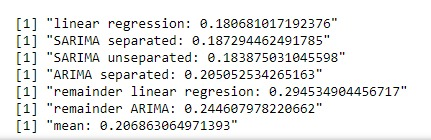

In [32]:
getResiduals <- function(production_file, date_forecast_done, forecast_table){
  check_day_str = toString(date_forecast_done+3)
  check_prod_file = paste(check_day_str, "production.csv", sep="_")
  actual_prod = fread(check_prod_file)
  actual = actual_prod[date == as.Date(date_forecast_done+1), "production"]
  
  comparison_table=data.table(date=as.Date(date_forecast_done+1),hour=0:23, actual=actual)
  
  lm_sep = forecast_table$linear_regression
  residual1 = lm_sep - actual
    
  sarima_sep = forecast_table$SARIMA_separated
  residual2 = sarima_sep - actual
    
  sarima_unsep = forecast_table$SARIMA_unseparated
  residual3 = sarima_unsep - actual
  
  arima_sep = forecast_table$ARIMA_separated
  residual4 = arima_sep - actual
  
  lm_decomposed = forecast_table$remainder_lm
  residual5 = lm_decomposed - actual
  
  arima_decomposed = forecast_table$remainder_ARIMA
  residual6 = arima_decomposed - actual
  
  means = forecast_table$mean
  residual7 = means - actual
  
  comparison_table[,linear_regression:=lm_sep]
  comparison_table[,residuals1:=residual1]
  comparison_table[,SARIMA_separated:=sarima_sep]
  comparison_table[,residuals2:=residual2]
  comparison_table[,SARIMA_unseparated:=sarima_unsep]
  comparison_table[,residuals3:=residual3]
  comparison_table[,ARIMA_separated:=arima_sep]
  comparison_table[,residuals4:=residual4]
  comparison_table[,remainder_lm:=lm_decomposed]
  comparison_table[,residuals5:=residual5]
  comparison_table[,remainder_ARIMA:=arima_decomposed]
  comparison_table[,residuals6:=residual6]
  comparison_table[,mean:=means]
  comparison_table[,residuals7:=residual7]
  
  return (comparison_table)
}

WMAPE <- function(pred, actual, residual=NULL){
  if (is.null(residual)){
    sum_abs_res <- sum(abs(pred-actual))
  }
  else{
    sum_abs_res <- sum(abs(residual))
  }
  sum_actual <- sum(actual)
  return (sum_abs_res/sum_actual)
}


getWMAPEs <- function(table){
  print(paste("linear regression:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals1)))
  print(paste("SARIMA separated:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals2)))
  print(paste("SARIMA unseparated:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals3)))
  print(paste("ARIMA separated:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals4)))
  print(paste("remainder linear regresion:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals5)))
  print(paste("remainder ARIMA:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals6)))
  print(paste("mean:", WMAPE(pred=NULL,actual=table$actual.production, residual=table$residuals7)))
}


forecasts <- summarizeForecasts(todays_date, weather_file, production_file, compare_days_before = 2)
forecasts
comparison_table = getResiduals(production_file, date_forecast_done=as.Date("2022-05-26"), forecasts)
comparison_table
getWMAPEs(comparison_table)



 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)(1,0,1)[30] with drift         : -2492.269
 ARIMA(0,1,0)            with drift         : -2390.438
 ARIMA(1,1,0)(1,0,0)[30] with drift         : -2446.485
 ARIMA(0,1,1)(0,0,1)[30] with drift         : -2510.198
 ARIMA(0,1,0)                               : -2392.321
 ARIMA(0,1,1)            with drift         : -2511.696
 ARIMA(0,1,1)(1,0,0)[30] with drift         : -2479.254
 ARIMA(0,1,1)(1,0,1)[30] with drift         : -2477.434
 ARIMA(1,1,1)            with drift         : -2510.141
 ARIMA(0,1,2)            with drift         : -2511.995
 ARIMA(0,1,2)(1,0,0)[30] with drift         : -2479.489
 ARIMA(0,1,2)(0,0,1)[30] with drift         : -2510.433
 ARIMA(0,1,2)(1,0,1)[30] with drift         : Inf
 ARIMA(1,1,2)            with drift         : -2524.225
 ARIMA(1,1,2)(1,0,0)[30] with drift         : -2491.63
 ARIMA(1,1,2)(0,0,1)[30] with drift         : -2522.637
 ARIMA(1,1,2)(1,0,1)[30] with drift         : -248

[1] "linear regression: 0.180681017192376"
[1] "SARIMA separated: 0.187294462491785"
[1] "SARIMA unseparated: 0.183875031045598"
[1] "ARIMA separated: 0.205052534265163"
[1] "remainder linear regresion: 0.294534904456717"
[1] "remainder ARIMA: 0.244607978220662"
[1] "mean: 0.206863064971393"


# 8- Submission Phase

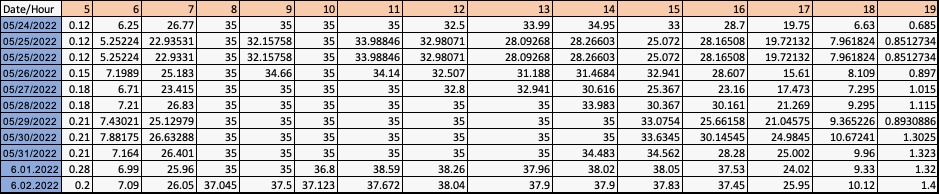
* Before the submission phase, we have built our models and evaluated our models by looking at the WMAPE values for each. Final model is chosen by splitting data into training and test data sets. To lose as less observation as possible, we tried to keep our training data set large enough while giving enough data to the test data set. We trained our model with these data points and tested them on the test data set. According to our results we have found, we decided to proceed with the one which performs better in terms of test error. Test error is an important measure to prevent the model from overfit.


* During the submission phase, we have made some changes in the models we have been using. While inspecting the data, we have realized that 35 is a maximum point and although our model predicts slightly larger than 35 at some hours, we have reduced them to 35. Nonetheless, with the new data, we have realized that maximum capacity has increased and production amounts were more than 35 for some hours. As a result of this increase, instead of reducing their values, we kept the result obtained from the model or increased these results slightly. 
    
    
* Simultaneously, we were looking at the production amount for each hour of the last 7 days to be aware of sudden jumps in the production. If something unexpected happens in the production amount, we try to protect our model from such an outlier point. Besides, since averaging decreases the variance, after some point, we run the every model and then calculate their average as final submission values.


# 9- Conclusion

In this project, we have built different time series models to predict the production of the KIVANÇ 2 GES solar energy panel. There are various time series models that can be applied to the data however, we have focused on the ones we have covered during the lectures. Time series regression, decomposition, ARIMA and SARIMA models are the models we have worked on and tried to improve. 


Every model is built by following certain steps. While applying these steps,  we got help from the plots. Visualization is one of the key steps of forecasting. We know that every model has advantages and disadvantages, so we tried to create as many reasonable models as we can to see model performance differences and to choose the best performing one.
    
    
WMAPE is the measurement of the model performance and the best result we obtained at the trial period was the outcome of the linear regression model. Linear regression models are built on every hour of the day and some of the input variables are added to the models. We began making predictions with the linear regression models, however, whenever we ended up with a relatively large WMAPE, we took the average of the predictions of the models. Besides, post processing is done for maximum capacity issues and in addition to these, with the help of the visualization, we have made slight adjustments. 
    
    
During this submission period, we have tried to make better predictions by implementing different concepts which are in the scope of the IE360 lecture. We have realized that it is possible to build more than one model and improving a model is a dynamic process as long as there is enough data.


# 10- References

1- Introduction to Time Series Analysis and Forecasting, Montgomery, Jennings, and Kulahci, 2008, Wiley


2- https://otexts.com/fpp2 